In [1]:
#使用几个benchmark数据集进行实验评估
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tarfile
import bz2

from catboost import CatBoostRegressor
from pandas import DataFrame, Series
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from bz2 import BZ2File as b2f
from libsvm.commonutil import svm_read_problem
from sklearn.svm import SVR
#屏蔽warning
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#读取相关数据库数据
def read_libsvm_data(dataset_name):
    y,x = svm_read_problem('./dataset/'+dataset_name+'/'+dataset_name+'.txt')
    #print(y)
    #print(x)
    #从字典中提取出来
    X = []
    for i in range(len(x)):
        xx =[]
        for key,value in x[i].items():
            xx.append(value)
        X.append(xx)
    
    X = DataFrame(X)
    y = Series(y)
    return y,X
    

In [3]:
"""
    A method which can be used for sklearn library training and xgboost, lightgbm and catboost 
"""
n_fold = 10 #10折交叉验证
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)
def train_model(X,  y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):
    """

    :param X: 训练集输入 数据类型：dataframe
    :param X_test: 测试集输入 数据类型：dataframe
    :param y: 训练集y 数据类型：Series
    :param params: 相关参数
    :param folds: 交叉验证折数
    :param model_type: lgb、xgb、cat、rfr或者sklearn
    :param plot_feature_importance: 是否plot feature importance
    :param model:
    :return:
    """
    oof = np.zeros(X.shape[0])  # 生成一个跟X行数一样长的零矩阵
    #prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()  # 生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'svr':
            
            model = model
            model.fit(X_train, y_train)
            
            #y_pred_valid = model.best_estimator_.predict(X_valid).reshape(-1, )
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)
        
        if model_type == 'rfr':
            """
                注意randomforest对nan敏感 需要做处理
            """
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                      verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)  # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            
            #y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000, eval_metric='RMSE',
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1, )  # reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)  # 每交叉验证一次得到一个loss分数，一共有n_fold个值

        #prediction += y_pred  # 每次预测的结果累加 可能需要.reshape(-1,)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1  # 第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)  # 将每次交叉验证的结果得到的变量importance保存

    #prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            return oof,feature_importance
            #return oof, prediction, feature_importance
        return oof
        #return oof, prediction

    else:
        return oof
        #return oof, prediction

## abalone数据集实验

In [4]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('abalone')

### 基学习器的训练

#### support vector regression

In [5]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:03:57 2019
Fold 1 started at Tue Dec 17 00:03:57 2019
Fold 2 started at Tue Dec 17 00:03:57 2019
Fold 3 started at Tue Dec 17 00:03:58 2019
Fold 4 started at Tue Dec 17 00:03:58 2019
Fold 5 started at Tue Dec 17 00:03:59 2019
Fold 6 started at Tue Dec 17 00:03:59 2019
Fold 7 started at Tue Dec 17 00:03:59 2019
Fold 8 started at Tue Dec 17 00:04:00 2019
Fold 9 started at Tue Dec 17 00:04:00 2019
CV mean score: 2.4050, std: 0.1915.


#### lightgbm

Fold 0 started at Tue Dec 17 00:04:01 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.57844	valid_1's rmse: 2.16202
Early stopping, best iteration is:
[914]	training's rmse: 1.6016	valid_1's rmse: 2.16001
Fold 1 started at Tue Dec 17 00:04:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 1.82114	valid_1's rmse: 2.21794
Fold 2 started at Tue Dec 17 00:04:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 1.89488	valid_1's rmse: 1.99238
Fold 3 started at Tue Dec 17 00:04:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[310]	training's rmse: 1.8355	valid_1's rmse: 2.08564
Fold 4 started at Tue Dec 17 00:04:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[761]	training's rmse

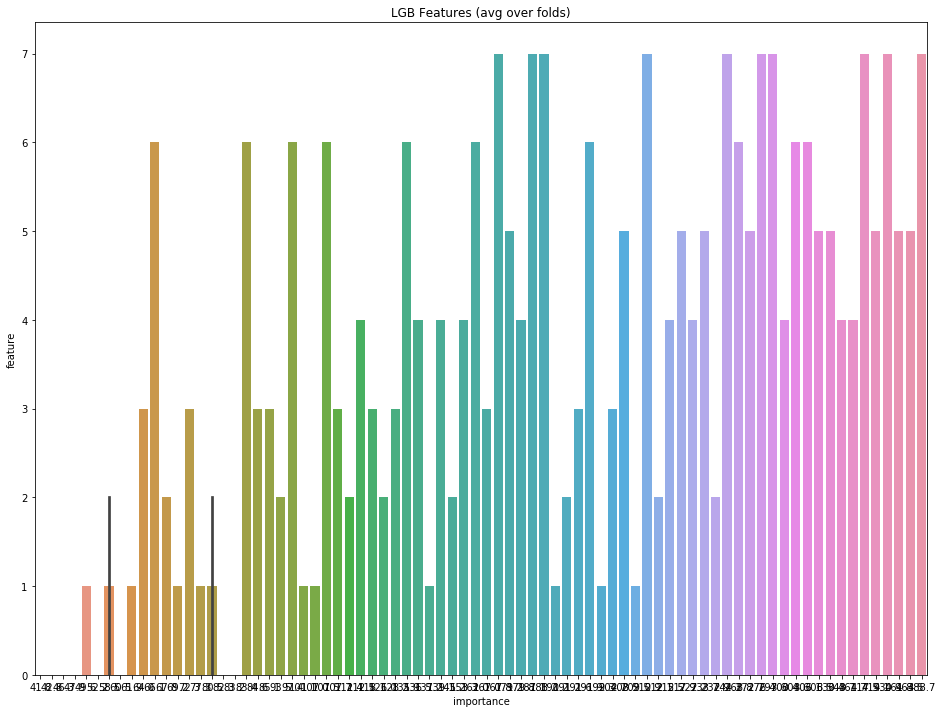

In [6]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:04:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.75254	valid_1's rmse: 2.16821
Early stopping, best iteration is:
[1400]	training's rmse: 1.68497	valid_1's rmse: 2.16602
Fold 1 started at Tue Dec 17 00:04:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 1.90822	valid_1's rmse: 2.2156
Fold 2 started at Tue Dec 17 00:04:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 1.98856	valid_1's rmse: 2.00472
Fold 3 started at Tue Dec 17 00:04:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 1.93556	valid_1's rmse: 2.05839
Fold 4 started at Tue Dec 17 00:04:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73209	valid_1's rmse: 2.3241

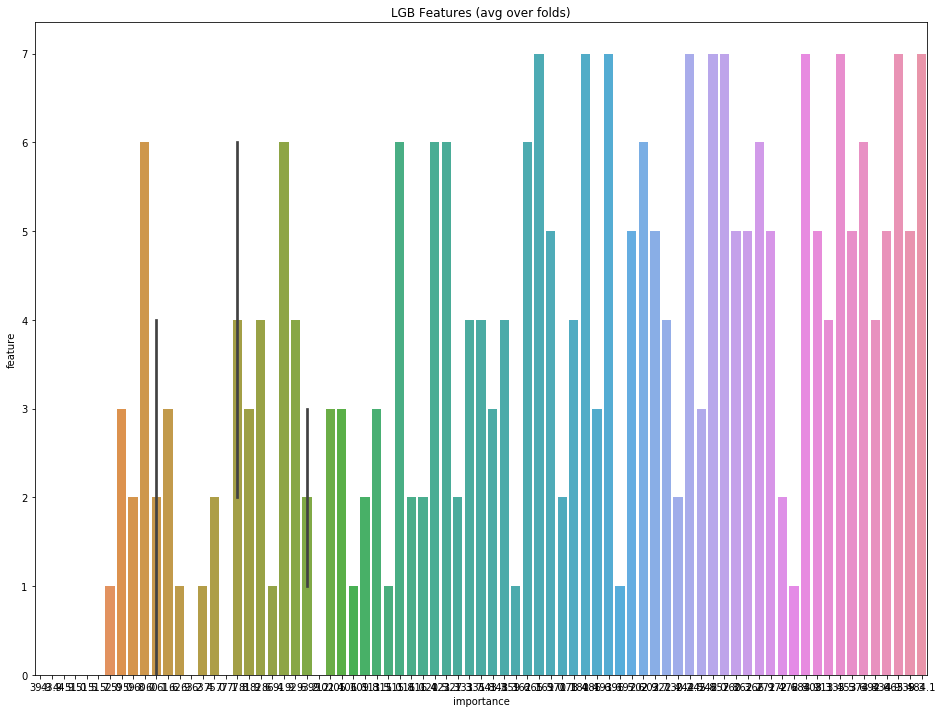

In [7]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:04:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.75254	valid_1's rmse: 2.16821
Early stopping, best iteration is:
[1400]	training's rmse: 1.68497	valid_1's rmse: 2.16602
Fold 1 started at Tue Dec 17 00:04:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 1.90822	valid_1's rmse: 2.2156
Fold 2 started at Tue Dec 17 00:04:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 1.98856	valid_1's rmse: 2.00472
Fold 3 started at Tue Dec 17 00:04:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 1.93556	valid_1's rmse: 2.05839
Fold 4 started at Tue Dec 17 00:04:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73209	valid_1's rmse: 2.3241

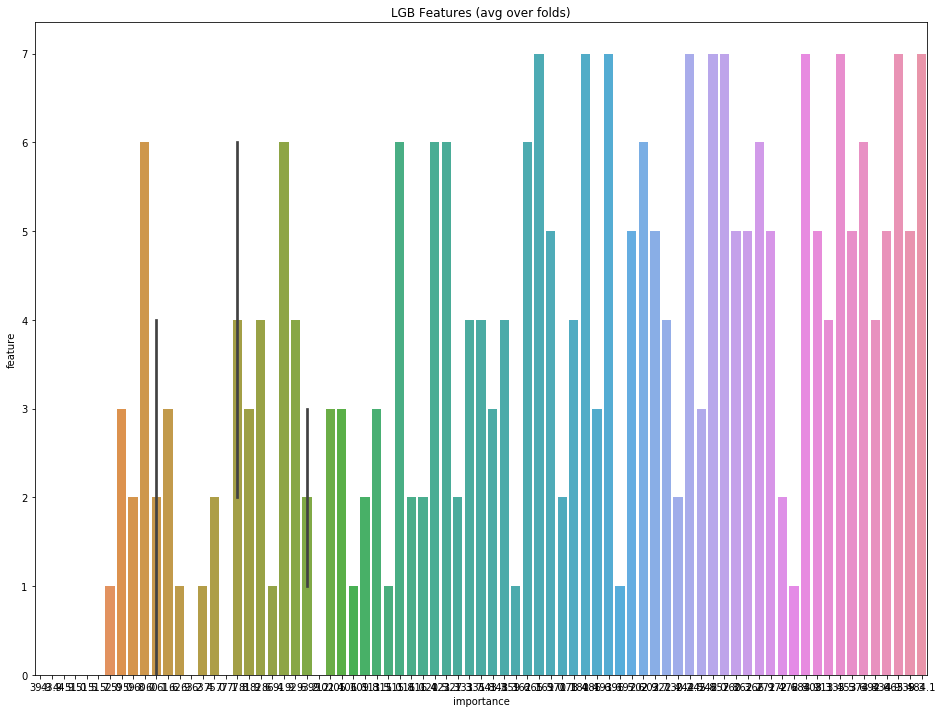

In [8]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

#### random forest regression

In [9]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:04:24 2019
Fold 1 started at Tue Dec 17 00:04:24 2019
Fold 2 started at Tue Dec 17 00:04:25 2019
Fold 3 started at Tue Dec 17 00:04:25 2019
Fold 4 started at Tue Dec 17 00:04:25 2019
Fold 5 started at Tue Dec 17 00:04:25 2019
Fold 6 started at Tue Dec 17 00:04:25 2019
Fold 7 started at Tue Dec 17 00:04:26 2019
Fold 8 started at Tue Dec 17 00:04:26 2019
Fold 9 started at Tue Dec 17 00:04:26 2019
CV mean score: 2.1657, std: 0.1499.


#### xgboost

In [10]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:04:26 2019
[0]	train-rmse:9.87657	valid_data-rmse:9.86869
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.45264	valid_data-rmse:2.18588
Stopping. Best iteration:
[574]	train-rmse:1.40481	valid_data-rmse:2.18364

Fold 1 started at Tue Dec 17 00:04:29 2019
[0]	train-rmse:9.87916	valid_data-rmse:9.84413
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.43432	valid_data-rmse:2.23184
Stopping. Best iteration:
[423]	train-rmse:1.50344	valid_data-rmse:2.22885

Fold 2 started at Tue Dec 17 00:04:31 2019
[0]	train-rmse:9.91161	valid_data-rmse:9.54428
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

#### catboost

In [11]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')

Fold 0 started at Tue Dec 17 00:04:51 2019
Fold 1 started at Tue Dec 17 00:05:36 2019
Fold 2 started at Tue Dec 17 00:05:52 2019
Fold 3 started at Tue Dec 17 00:06:08 2019
Fold 4 started at Tue Dec 17 00:06:25 2019
Fold 5 started at Tue Dec 17 00:07:42 2019
Fold 6 started at Tue Dec 17 00:08:04 2019
Fold 7 started at Tue Dec 17 00:08:57 2019
Fold 8 started at Tue Dec 17 00:09:36 2019
Fold 9 started at Tue Dec 17 00:10:38 2019
CV mean score: 2.1314, std: 0.1429.


### stacking

#### 所有结果均用于做stacking

In [12]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:11:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[272]	training's rmse: 1.87973	valid_1's rmse: 2.23268
Fold 1 started at Tue Dec 17 00:11:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 1.85193	valid_1's rmse: 2.23895
Fold 2 started at Tue Dec 17 00:11:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[235]	training's rmse: 1.93383	valid_1's rmse: 2.01824
Fold 3 started at Tue Dec 17 00:11:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 1.90429	valid_1's rmse: 2.11666
Fold 4 started at Tue Dec 17 00:11:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[355]	training's rmse: 1.82192	valid_1's rmse: 2.39192
Fold 5 started at Tu

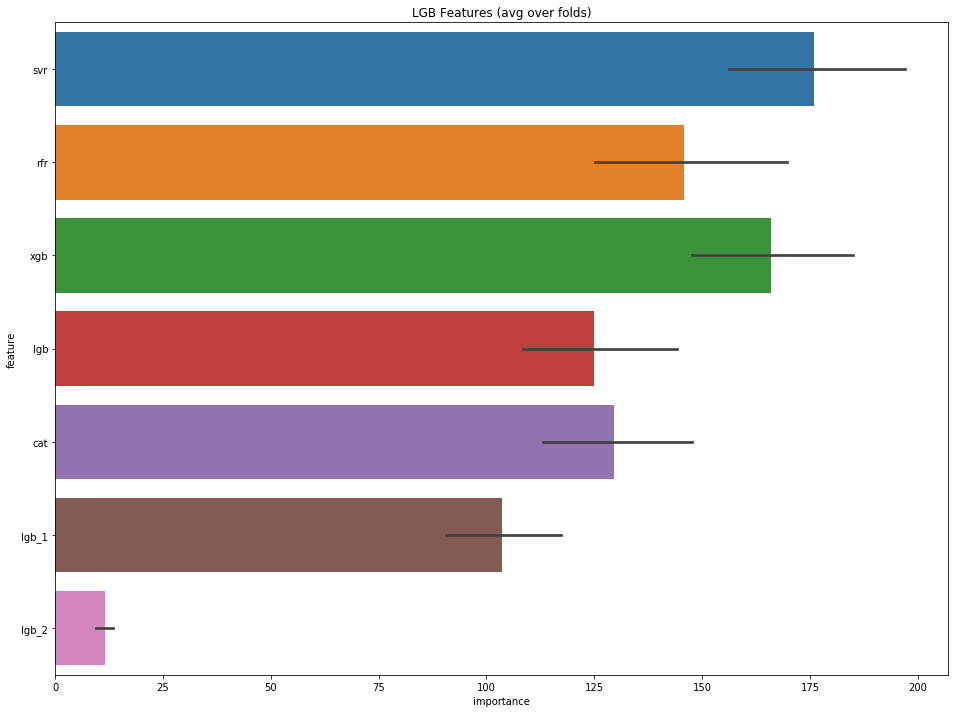

In [13]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:12:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 2.02873	valid_1's rmse: 2.18219
Fold 1 started at Tue Dec 17 00:12:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[442]	training's rmse: 2.01916	valid_1's rmse: 2.20932
Fold 2 started at Tue Dec 17 00:12:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.08333	valid_1's rmse: 1.98632
Fold 3 started at Tue Dec 17 00:12:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[293]	training's rmse: 2.06042	valid_1's rmse: 2.09853
Fold 4 started at Tue Dec 17 00:12:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[321]	training's rmse: 2.02755	valid_1's rmse: 2.35153
Fold 5 started at Tu

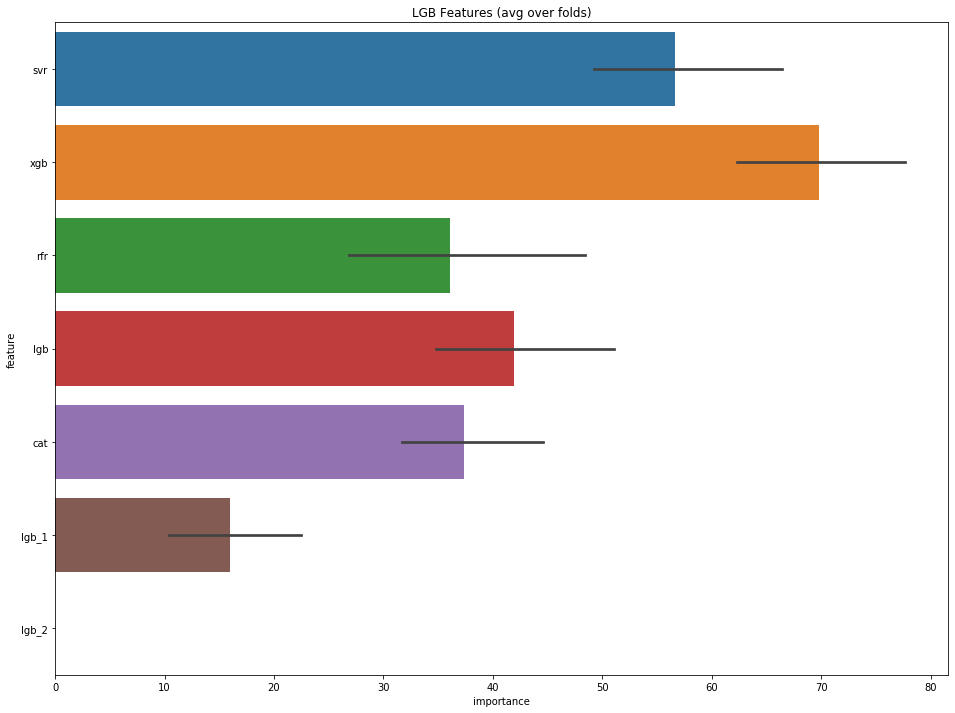

In [14]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [15]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:12:07 2019
Fold 1 started at Tue Dec 17 00:12:16 2019
Fold 2 started at Tue Dec 17 00:12:25 2019
Fold 3 started at Tue Dec 17 00:12:31 2019
Fold 4 started at Tue Dec 17 00:12:40 2019
Fold 5 started at Tue Dec 17 00:12:49 2019
Fold 6 started at Tue Dec 17 00:12:58 2019
Fold 7 started at Tue Dec 17 00:13:08 2019
Fold 8 started at Tue Dec 17 00:13:23 2019
Fold 9 started at Tue Dec 17 00:13:35 2019
CV mean score: 2.1126, std: 0.1437.


##### randomforest作为第二层融合模型

In [16]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:13:42 2019
Fold 1 started at Tue Dec 17 00:13:42 2019
Fold 2 started at Tue Dec 17 00:13:43 2019
Fold 3 started at Tue Dec 17 00:13:43 2019
Fold 4 started at Tue Dec 17 00:13:43 2019
Fold 5 started at Tue Dec 17 00:13:43 2019
Fold 6 started at Tue Dec 17 00:13:44 2019
Fold 7 started at Tue Dec 17 00:13:44 2019
Fold 8 started at Tue Dec 17 00:13:44 2019
Fold 9 started at Tue Dec 17 00:13:44 2019
CV mean score: 2.1678, std: 0.1338.


##### xgboost作为第二层融合模型

In [17]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:13:45 2019
[0]	train-rmse:9.87506	valid_data-rmse:9.86664
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.54604	valid_data-rmse:2.24824
Stopping. Best iteration:
[398]	train-rmse:1.6353	valid_data-rmse:2.24466

Fold 1 started at Tue Dec 17 00:13:47 2019
[0]	train-rmse:9.87785	valid_data-rmse:9.84365
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.55078	valid_data-rmse:2.23231
Stopping. Best iteration:
[434]	train-rmse:1.60382	valid_data-rmse:2.23152

Fold 2 started at Tue Dec 17 00:13:50 2019
[0]	train-rmse:9.9102	valid_data-rmse:9.54352
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [18]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:14:16 2019
Fold 1 started at Tue Dec 17 00:14:17 2019
Fold 2 started at Tue Dec 17 00:14:18 2019
Fold 3 started at Tue Dec 17 00:14:18 2019
Fold 4 started at Tue Dec 17 00:14:19 2019
Fold 5 started at Tue Dec 17 00:14:19 2019
Fold 6 started at Tue Dec 17 00:14:20 2019
Fold 7 started at Tue Dec 17 00:14:21 2019
Fold 8 started at Tue Dec 17 00:14:21 2019
Fold 9 started at Tue Dec 17 00:14:22 2019
CV mean score: 2.1755, std: 0.1741.


##### 岭回归做第二层融合模型

In [19]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:14:23 2019
Fold 1 started at Tue Dec 17 00:14:23 2019
Fold 2 started at Tue Dec 17 00:14:23 2019
Fold 3 started at Tue Dec 17 00:14:23 2019
Fold 4 started at Tue Dec 17 00:14:23 2019
Fold 5 started at Tue Dec 17 00:14:23 2019
Fold 6 started at Tue Dec 17 00:14:23 2019
Fold 7 started at Tue Dec 17 00:14:23 2019
Fold 8 started at Tue Dec 17 00:14:23 2019
Fold 9 started at Tue Dec 17 00:14:24 2019
CV mean score: 2.1112, std: 0.1401.


#### 去掉lgb的结果

In [20]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:14:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[281]	training's rmse: 1.91188	valid_1's rmse: 2.21657
Fold 1 started at Tue Dec 17 00:14:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[330]	training's rmse: 1.88455	valid_1's rmse: 2.21067
Fold 2 started at Tue Dec 17 00:14:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 1.9636	valid_1's rmse: 2.01404
Fold 3 started at Tue Dec 17 00:14:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 1.93242	valid_1's rmse: 2.08689
Fold 4 started at Tue Dec 17 00:14:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 1.8676	valid_1's rmse: 2.39259
Fold 5 started at Tue 

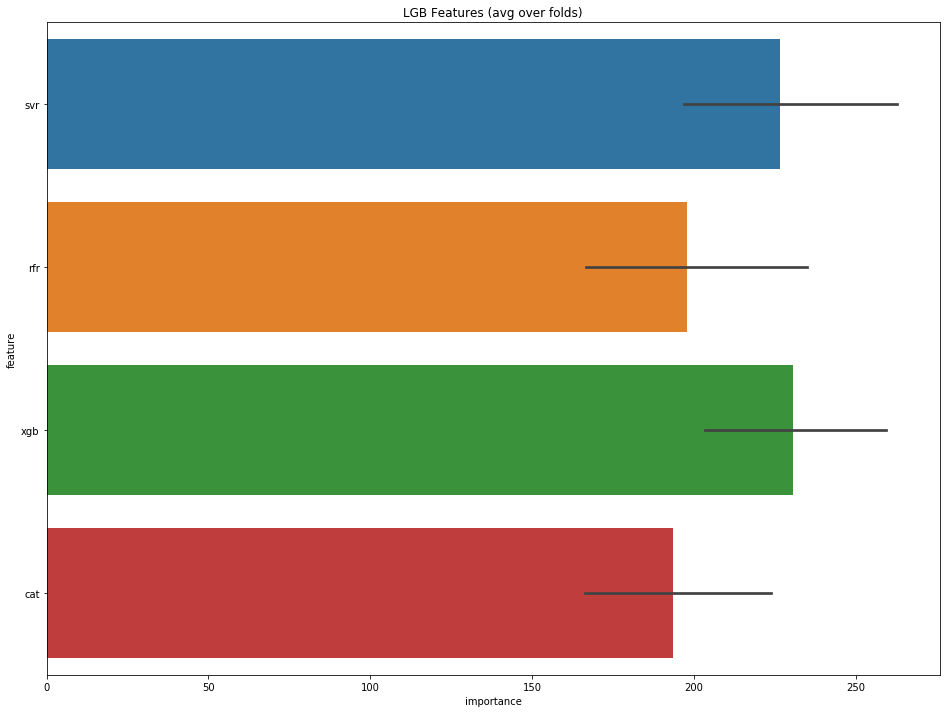

In [21]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:14:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.05022	valid_1's rmse: 2.18755
Fold 1 started at Tue Dec 17 00:14:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[659]	training's rmse: 2.00891	valid_1's rmse: 2.18772
Fold 2 started at Tue Dec 17 00:14:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 2.09021	valid_1's rmse: 1.99026
Fold 3 started at Tue Dec 17 00:14:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[289]	training's rmse: 2.06868	valid_1's rmse: 2.08739
Fold 4 started at Tue Dec 17 00:14:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 2.03064	valid_1's rmse: 2.35713
Fold 5 started at Tu

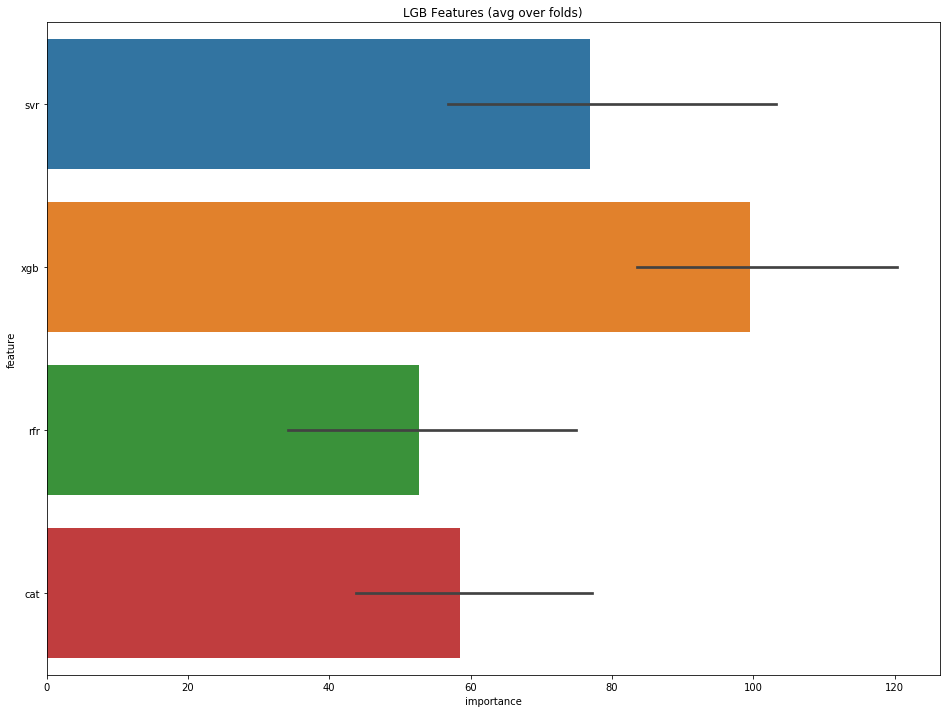

In [22]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [23]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:14:33 2019
Fold 1 started at Tue Dec 17 00:14:42 2019
Fold 2 started at Tue Dec 17 00:14:50 2019
Fold 3 started at Tue Dec 17 00:14:56 2019
Fold 4 started at Tue Dec 17 00:15:04 2019
Fold 5 started at Tue Dec 17 00:15:14 2019
Fold 6 started at Tue Dec 17 00:15:21 2019
Fold 7 started at Tue Dec 17 00:15:31 2019
Fold 8 started at Tue Dec 17 00:15:37 2019
Fold 9 started at Tue Dec 17 00:15:53 2019
CV mean score: 2.1151, std: 0.1487.


##### randomforest作为第二层融合模型

In [24]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:16:04 2019
Fold 1 started at Tue Dec 17 00:16:04 2019
Fold 2 started at Tue Dec 17 00:16:04 2019
Fold 3 started at Tue Dec 17 00:16:05 2019
Fold 4 started at Tue Dec 17 00:16:05 2019
Fold 5 started at Tue Dec 17 00:16:05 2019
Fold 6 started at Tue Dec 17 00:16:05 2019
Fold 7 started at Tue Dec 17 00:16:05 2019
Fold 8 started at Tue Dec 17 00:16:06 2019
Fold 9 started at Tue Dec 17 00:16:06 2019
CV mean score: 2.1620, std: 0.1523.


##### xgboost作为第二层融合模型

In [25]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:16:06 2019
[0]	train-rmse:9.87517	valid_data-rmse:9.86726
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.607	valid_data-rmse:2.21731
Stopping. Best iteration:
[403]	train-rmse:1.68519	valid_data-rmse:2.21305

Fold 1 started at Tue Dec 17 00:16:08 2019
[0]	train-rmse:9.878	valid_data-rmse:9.84377
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.61429	valid_data-rmse:2.22224
Stopping. Best iteration:
[500]	train-rmse:1.61429	valid_data-rmse:2.22224

Fold 2 started at Tue Dec 17 00:16:11 2019
[0]	train-rmse:9.91034	valid_data-rmse:9.54294
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse

##### svr 作为第二层融合模型

In [26]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:16:29 2019
Fold 1 started at Tue Dec 17 00:16:30 2019
Fold 2 started at Tue Dec 17 00:16:30 2019
Fold 3 started at Tue Dec 17 00:16:31 2019
Fold 4 started at Tue Dec 17 00:16:32 2019
Fold 5 started at Tue Dec 17 00:16:32 2019
Fold 6 started at Tue Dec 17 00:16:33 2019
Fold 7 started at Tue Dec 17 00:16:34 2019
Fold 8 started at Tue Dec 17 00:16:34 2019
Fold 9 started at Tue Dec 17 00:16:35 2019
CV mean score: 2.1767, std: 0.1747.


##### 岭回归做第二层融合模型

In [27]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:16:35 2019
Fold 1 started at Tue Dec 17 00:16:36 2019
Fold 2 started at Tue Dec 17 00:16:36 2019
Fold 3 started at Tue Dec 17 00:16:36 2019
Fold 4 started at Tue Dec 17 00:16:36 2019
Fold 5 started at Tue Dec 17 00:16:36 2019
Fold 6 started at Tue Dec 17 00:16:36 2019
Fold 7 started at Tue Dec 17 00:16:36 2019
Fold 8 started at Tue Dec 17 00:16:37 2019
Fold 9 started at Tue Dec 17 00:16:37 2019
CV mean score: 2.1125, std: 0.1419.


#### 去掉xgboost的结果

In [28]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:16:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[246]	training's rmse: 1.92637	valid_1's rmse: 2.22455
Fold 1 started at Tue Dec 17 00:16:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 1.87686	valid_1's rmse: 2.22982
Fold 2 started at Tue Dec 17 00:16:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[216]	training's rmse: 1.97042	valid_1's rmse: 2.04392
Fold 3 started at Tue Dec 17 00:16:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[366]	training's rmse: 1.87817	valid_1's rmse: 2.10648
Fold 4 started at Tue Dec 17 00:17:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 1.87971	valid_1's rmse: 2.38168
Fold 5 started at Tu

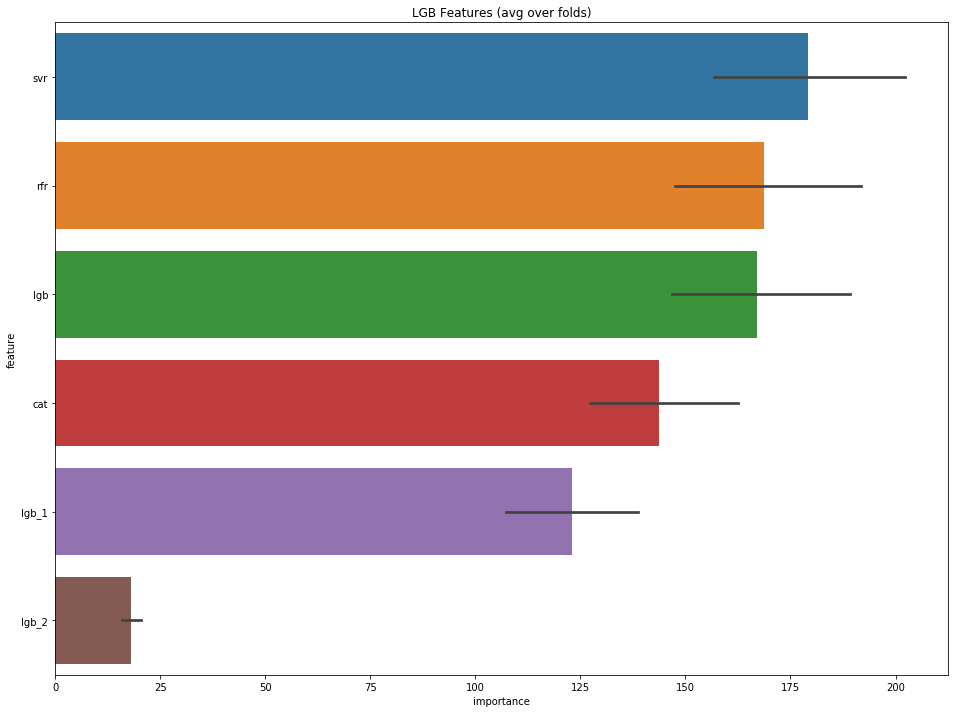

In [29]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:17:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 2.05438	valid_1's rmse: 2.17287
Fold 1 started at Tue Dec 17 00:17:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[459]	training's rmse: 2.03127	valid_1's rmse: 2.20359
Fold 2 started at Tue Dec 17 00:17:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 2.08779	valid_1's rmse: 2.00764
Fold 3 started at Tue Dec 17 00:17:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 2.07574	valid_1's rmse: 2.11313
Fold 4 started at Tue Dec 17 00:17:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[377]	training's rmse: 2.02975	valid_1's rmse: 2.34502
Fold 5 started at Tu

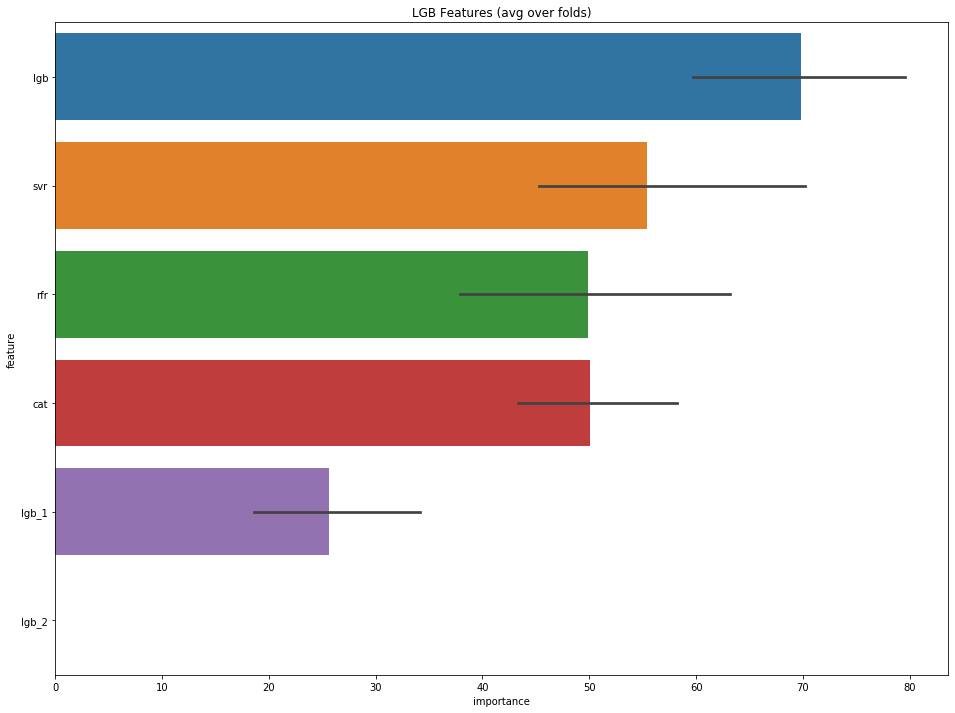

In [30]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [31]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:17:20 2019
Fold 1 started at Tue Dec 17 00:17:29 2019
Fold 2 started at Tue Dec 17 00:17:37 2019
Fold 3 started at Tue Dec 17 00:17:44 2019
Fold 4 started at Tue Dec 17 00:17:56 2019
Fold 5 started at Tue Dec 17 00:18:09 2019
Fold 6 started at Tue Dec 17 00:18:19 2019
Fold 7 started at Tue Dec 17 00:18:40 2019
Fold 8 started at Tue Dec 17 00:18:58 2019
Fold 9 started at Tue Dec 17 00:19:11 2019
CV mean score: 2.1174, std: 0.1420.


##### randomforest作为第二层融合模型

In [32]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:19:19 2019
Fold 1 started at Tue Dec 17 00:19:19 2019
Fold 2 started at Tue Dec 17 00:19:19 2019
Fold 3 started at Tue Dec 17 00:19:19 2019
Fold 4 started at Tue Dec 17 00:19:20 2019
Fold 5 started at Tue Dec 17 00:19:20 2019
Fold 6 started at Tue Dec 17 00:19:20 2019
Fold 7 started at Tue Dec 17 00:19:20 2019
Fold 8 started at Tue Dec 17 00:19:21 2019
Fold 9 started at Tue Dec 17 00:19:21 2019
CV mean score: 2.1636, std: 0.1385.


##### xgboost作为第二层融合模型

In [33]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:19:21 2019
[0]	train-rmse:9.87514	valid_data-rmse:9.86738
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58169	valid_data-rmse:2.22063
Stopping. Best iteration:
[434]	train-rmse:1.63262	valid_data-rmse:2.21905

Fold 1 started at Tue Dec 17 00:19:24 2019
[0]	train-rmse:9.87784	valid_data-rmse:9.8429
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.59035	valid_data-rmse:2.21612
Stopping. Best iteration:
[525]	train-rmse:1.57346	valid_data-rmse:2.21489

Fold 2 started at Tue Dec 17 00:19:27 2019
[0]	train-rmse:9.91024	valid_data-rmse:9.54245
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [34]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:19:51 2019
Fold 1 started at Tue Dec 17 00:19:51 2019
Fold 2 started at Tue Dec 17 00:19:52 2019
Fold 3 started at Tue Dec 17 00:19:52 2019
Fold 4 started at Tue Dec 17 00:19:53 2019
Fold 5 started at Tue Dec 17 00:19:54 2019
Fold 6 started at Tue Dec 17 00:19:54 2019
Fold 7 started at Tue Dec 17 00:19:55 2019
Fold 8 started at Tue Dec 17 00:19:56 2019
Fold 9 started at Tue Dec 17 00:19:56 2019
CV mean score: 2.1795, std: 0.1729.


##### 岭回归做第二层融合模型

In [35]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:19:57 2019
Fold 1 started at Tue Dec 17 00:19:57 2019
Fold 2 started at Tue Dec 17 00:19:57 2019
Fold 3 started at Tue Dec 17 00:19:57 2019
Fold 4 started at Tue Dec 17 00:19:57 2019
Fold 5 started at Tue Dec 17 00:19:58 2019
Fold 6 started at Tue Dec 17 00:19:58 2019
Fold 7 started at Tue Dec 17 00:19:58 2019
Fold 8 started at Tue Dec 17 00:19:58 2019
Fold 9 started at Tue Dec 17 00:19:58 2019
CV mean score: 2.1153, std: 0.1391.


#### 去掉svr的结果

In [36]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:19:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 1.92818	valid_1's rmse: 2.26192
Fold 1 started at Tue Dec 17 00:20:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 1.92864	valid_1's rmse: 2.23097
Fold 2 started at Tue Dec 17 00:20:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 1.95755	valid_1's rmse: 1.99724
Fold 3 started at Tue Dec 17 00:20:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 1.93666	valid_1's rmse: 2.11395
Fold 4 started at Tue Dec 17 00:20:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	training's rmse: 1.87975	valid_1's rmse: 2.39628
Fold 5 started at Tu

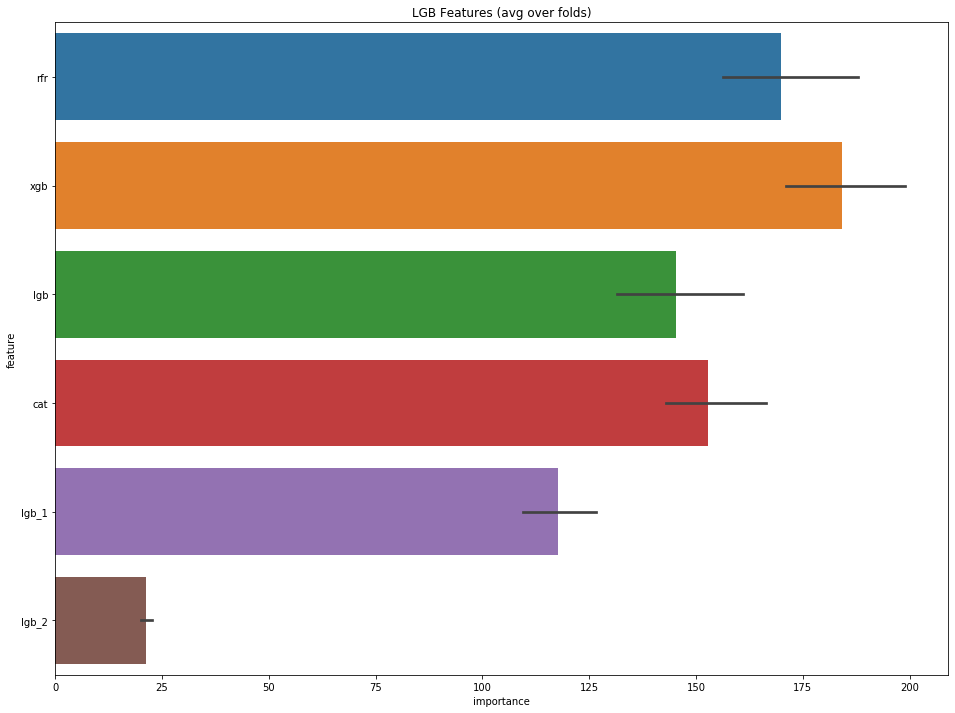

In [37]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:21:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[370]	training's rmse: 2.04796	valid_1's rmse: 2.18454
Fold 1 started at Tue Dec 17 00:21:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[382]	training's rmse: 2.03698	valid_1's rmse: 2.21956
Fold 2 started at Tue Dec 17 00:21:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[234]	training's rmse: 2.09884	valid_1's rmse: 1.98838
Fold 3 started at Tue Dec 17 00:21:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[677]	training's rmse: 2.03136	valid_1's rmse: 2.09199
Fold 4 started at Tue Dec 17 00:21:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[330]	training's rmse: 2.0391	valid_1's rmse: 2.33671
Fold 5 started at Tue

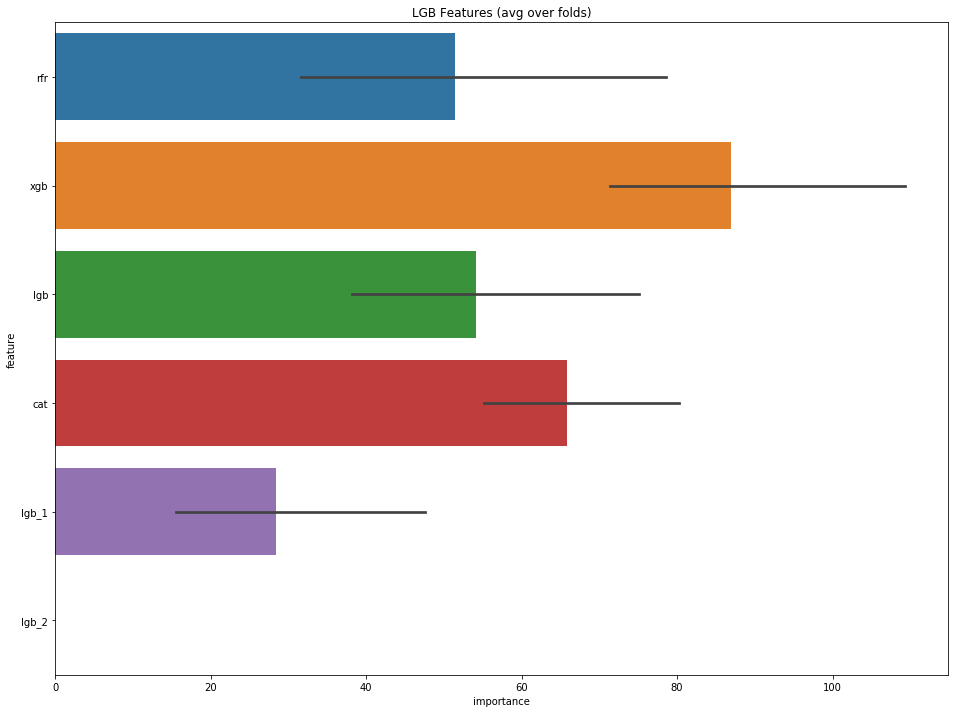

In [38]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [39]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:22:13 2019
Fold 1 started at Tue Dec 17 00:22:38 2019
Fold 2 started at Tue Dec 17 00:22:54 2019
Fold 3 started at Tue Dec 17 00:23:09 2019
Fold 4 started at Tue Dec 17 00:23:29 2019
Fold 5 started at Tue Dec 17 00:23:58 2019
Fold 6 started at Tue Dec 17 00:24:16 2019
Fold 7 started at Tue Dec 17 00:25:05 2019
Fold 8 started at Tue Dec 17 00:25:48 2019
Fold 9 started at Tue Dec 17 00:26:05 2019
CV mean score: 2.1120, std: 0.1450.


##### randomforest作为第二层融合模型

In [40]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:26:17 2019
Fold 1 started at Tue Dec 17 00:26:17 2019
Fold 2 started at Tue Dec 17 00:26:18 2019
Fold 3 started at Tue Dec 17 00:26:18 2019
Fold 4 started at Tue Dec 17 00:26:18 2019
Fold 5 started at Tue Dec 17 00:26:18 2019
Fold 6 started at Tue Dec 17 00:26:19 2019
Fold 7 started at Tue Dec 17 00:26:19 2019
Fold 8 started at Tue Dec 17 00:26:19 2019
Fold 9 started at Tue Dec 17 00:26:19 2019
CV mean score: 2.1652, std: 0.1528.


##### xgboost作为第二层融合模型

In [41]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:26:20 2019
[0]	train-rmse:9.87506	valid_data-rmse:9.86664
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.60029	valid_data-rmse:2.25553
Stopping. Best iteration:
[424]	train-rmse:1.65681	valid_data-rmse:2.24775

Fold 1 started at Tue Dec 17 00:26:22 2019
[0]	train-rmse:9.87785	valid_data-rmse:9.84365
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.60268	valid_data-rmse:2.24637
Stopping. Best iteration:
[436]	train-rmse:1.64828	valid_data-rmse:2.24405

Fold 2 started at Tue Dec 17 00:26:25 2019
[0]	train-rmse:9.9102	valid_data-rmse:9.54352
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [42]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:26:49 2019
Fold 1 started at Tue Dec 17 00:26:50 2019
Fold 2 started at Tue Dec 17 00:26:50 2019
Fold 3 started at Tue Dec 17 00:26:51 2019
Fold 4 started at Tue Dec 17 00:26:52 2019
Fold 5 started at Tue Dec 17 00:26:52 2019
Fold 6 started at Tue Dec 17 00:26:53 2019
Fold 7 started at Tue Dec 17 00:26:54 2019
Fold 8 started at Tue Dec 17 00:26:54 2019
Fold 9 started at Tue Dec 17 00:26:55 2019
CV mean score: 2.1641, std: 0.1730.


##### 岭回归做第二层融合模型

In [43]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:26:55 2019
Fold 1 started at Tue Dec 17 00:26:56 2019
Fold 2 started at Tue Dec 17 00:26:56 2019
Fold 3 started at Tue Dec 17 00:26:56 2019
Fold 4 started at Tue Dec 17 00:26:56 2019
Fold 5 started at Tue Dec 17 00:26:56 2019
Fold 6 started at Tue Dec 17 00:26:56 2019
Fold 7 started at Tue Dec 17 00:26:56 2019
Fold 8 started at Tue Dec 17 00:26:56 2019
Fold 9 started at Tue Dec 17 00:26:57 2019
CV mean score: 2.1117, std: 0.1416.


#### 去掉rfr的结果

In [44]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:26:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[272]	training's rmse: 1.90044	valid_1's rmse: 2.21843
Fold 1 started at Tue Dec 17 00:27:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 1.89122	valid_1's rmse: 2.2492
Fold 2 started at Tue Dec 17 00:27:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 1.96341	valid_1's rmse: 2.0022
Fold 3 started at Tue Dec 17 00:27:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 1.91585	valid_1's rmse: 2.10741
Fold 4 started at Tue Dec 17 00:27:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 1.85404	valid_1's rmse: 2.38036
Fold 5 started at Tue 

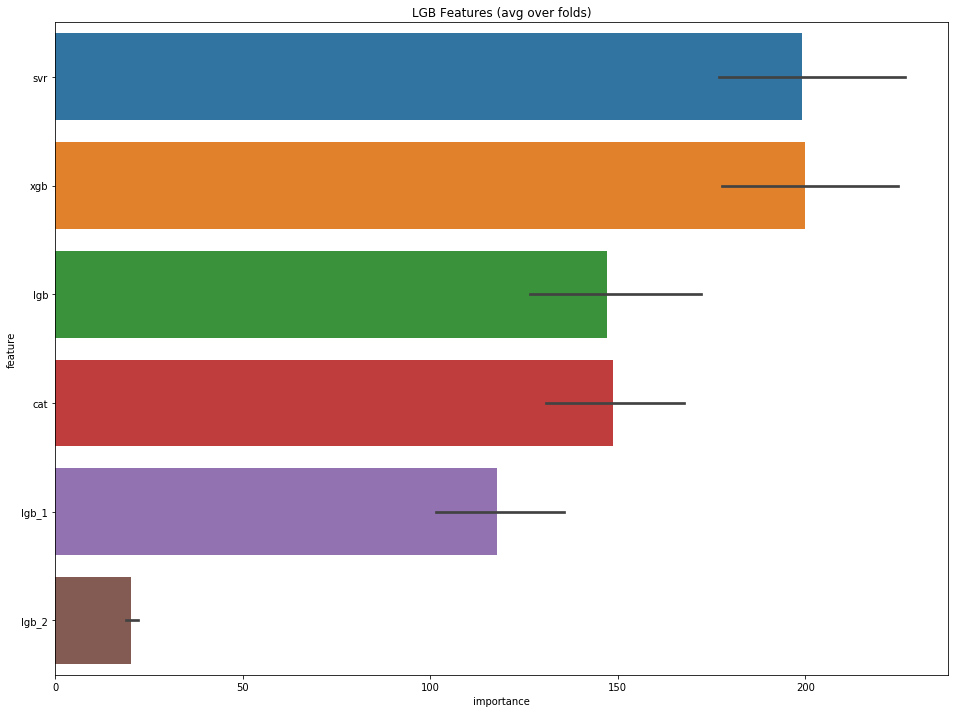

In [45]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:28:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[420]	training's rmse: 2.03184	valid_1's rmse: 2.18253
Fold 1 started at Tue Dec 17 00:28:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[309]	training's rmse: 2.04736	valid_1's rmse: 2.2116
Fold 2 started at Tue Dec 17 00:28:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 2.08369	valid_1's rmse: 1.9846
Fold 3 started at Tue Dec 17 00:28:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.98453	valid_1's rmse: 2.07959
Early stopping, best iteration is:
[1224]	training's rmse: 1.96796	valid_1's rmse: 2.07515
Fold 4 started at Tue Dec 17 00:28:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rms

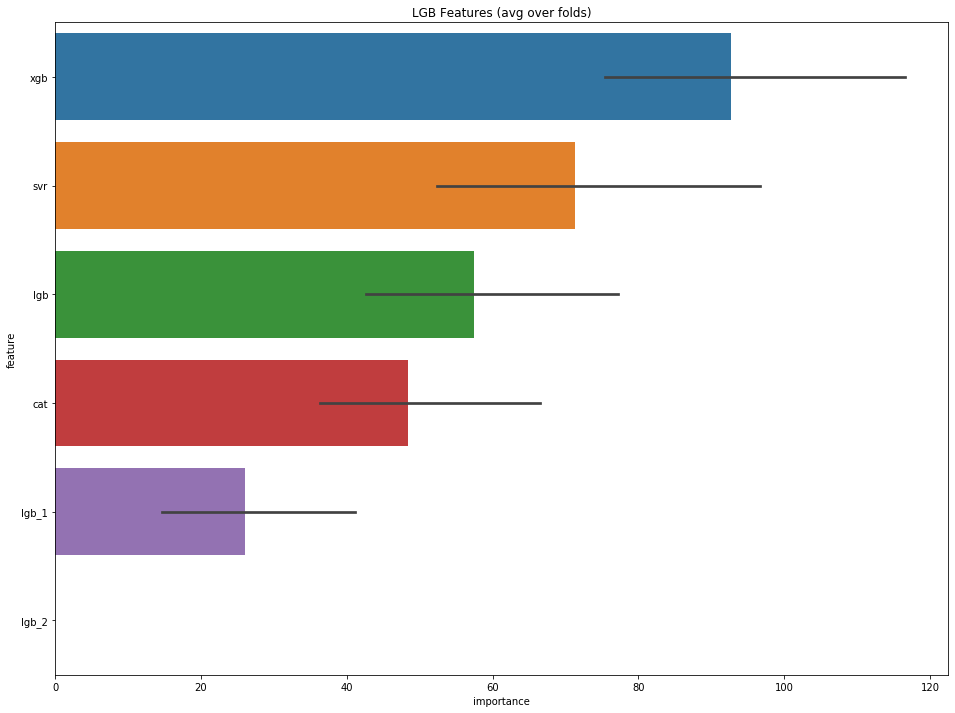

In [46]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [47]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:28:42 2019
Fold 1 started at Tue Dec 17 00:28:59 2019
Fold 2 started at Tue Dec 17 00:29:17 2019
Fold 3 started at Tue Dec 17 00:29:28 2019
Fold 4 started at Tue Dec 17 00:29:46 2019
Fold 5 started at Tue Dec 17 00:30:05 2019
Fold 6 started at Tue Dec 17 00:30:21 2019
Fold 7 started at Tue Dec 17 00:30:51 2019
Fold 8 started at Tue Dec 17 00:31:07 2019
Fold 9 started at Tue Dec 17 00:31:16 2019
CV mean score: 2.1105, std: 0.1409.


##### randomforest作为第二层融合模型

In [48]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:31:23 2019
Fold 1 started at Tue Dec 17 00:31:23 2019
Fold 2 started at Tue Dec 17 00:31:23 2019
Fold 3 started at Tue Dec 17 00:31:23 2019
Fold 4 started at Tue Dec 17 00:31:24 2019
Fold 5 started at Tue Dec 17 00:31:24 2019
Fold 6 started at Tue Dec 17 00:31:24 2019
Fold 7 started at Tue Dec 17 00:31:24 2019
Fold 8 started at Tue Dec 17 00:31:25 2019
Fold 9 started at Tue Dec 17 00:31:25 2019
CV mean score: 2.1518, std: 0.1298.


##### xgboost作为第二层融合模型

In [49]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:31:25 2019
[0]	train-rmse:9.87509	valid_data-rmse:9.86667
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58294	valid_data-rmse:2.24146
Stopping. Best iteration:
[442]	train-rmse:1.63014	valid_data-rmse:2.23905

Fold 1 started at Tue Dec 17 00:31:28 2019
[0]	train-rmse:9.87785	valid_data-rmse:9.84363
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58701	valid_data-rmse:2.2242
Stopping. Best iteration:
[481]	train-rmse:1.6001	valid_data-rmse:2.22258

Fold 2 started at Tue Dec 17 00:31:30 2019
[0]	train-rmse:9.9102	valid_data-rmse:9.54353
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [50]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:31:53 2019
Fold 1 started at Tue Dec 17 00:31:53 2019
Fold 2 started at Tue Dec 17 00:31:54 2019
Fold 3 started at Tue Dec 17 00:31:55 2019
Fold 4 started at Tue Dec 17 00:31:55 2019
Fold 5 started at Tue Dec 17 00:31:56 2019
Fold 6 started at Tue Dec 17 00:31:57 2019
Fold 7 started at Tue Dec 17 00:31:57 2019
Fold 8 started at Tue Dec 17 00:31:58 2019
Fold 9 started at Tue Dec 17 00:31:58 2019
CV mean score: 2.1716, std: 0.1730.


##### 岭回归做第二层融合模型

In [51]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:31:59 2019
Fold 1 started at Tue Dec 17 00:31:59 2019
Fold 2 started at Tue Dec 17 00:31:59 2019
Fold 3 started at Tue Dec 17 00:31:59 2019
Fold 4 started at Tue Dec 17 00:31:59 2019
Fold 5 started at Tue Dec 17 00:32:00 2019
Fold 6 started at Tue Dec 17 00:32:00 2019
Fold 7 started at Tue Dec 17 00:32:00 2019
Fold 8 started at Tue Dec 17 00:32:00 2019
Fold 9 started at Tue Dec 17 00:32:00 2019
CV mean score: 2.1103, std: 0.1399.


#### 去掉catboost的结果

In [52]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:32:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 1.89627	valid_1's rmse: 2.23984
Fold 1 started at Tue Dec 17 00:32:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 1.88934	valid_1's rmse: 2.22137
Fold 2 started at Tue Dec 17 00:32:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[216]	training's rmse: 1.96483	valid_1's rmse: 2.0132
Fold 3 started at Tue Dec 17 00:32:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[247]	training's rmse: 1.93107	valid_1's rmse: 2.12321
Fold 4 started at Tue Dec 17 00:32:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[306]	training's rmse: 1.86426	valid_1's rmse: 2.38179
Fold 5 started at Tue

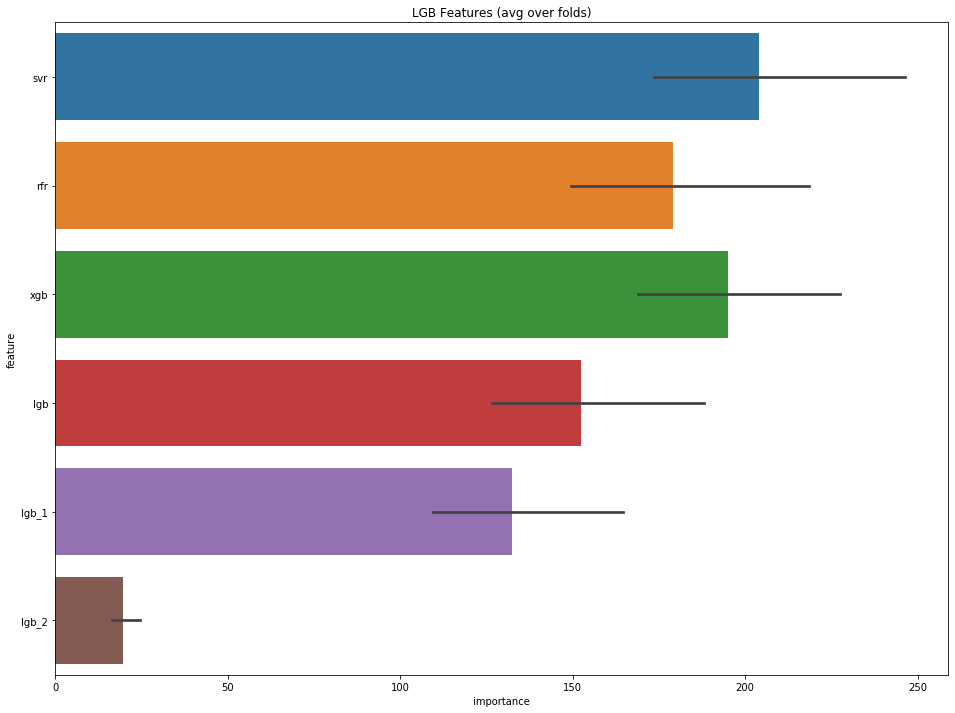

In [53]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:32:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.03918	valid_1's rmse: 2.18276
Fold 1 started at Tue Dec 17 00:32:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[448]	training's rmse: 2.02349	valid_1's rmse: 2.20957
Fold 2 started at Tue Dec 17 00:32:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 2.08413	valid_1's rmse: 1.97719
Fold 3 started at Tue Dec 17 00:33:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.9896	valid_1's rmse: 2.09464
Early stopping, best iteration is:
[839]	training's rmse: 2.00408	valid_1's rmse: 2.09111
Fold 4 started at Tue Dec 17 00:33:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	training's rms

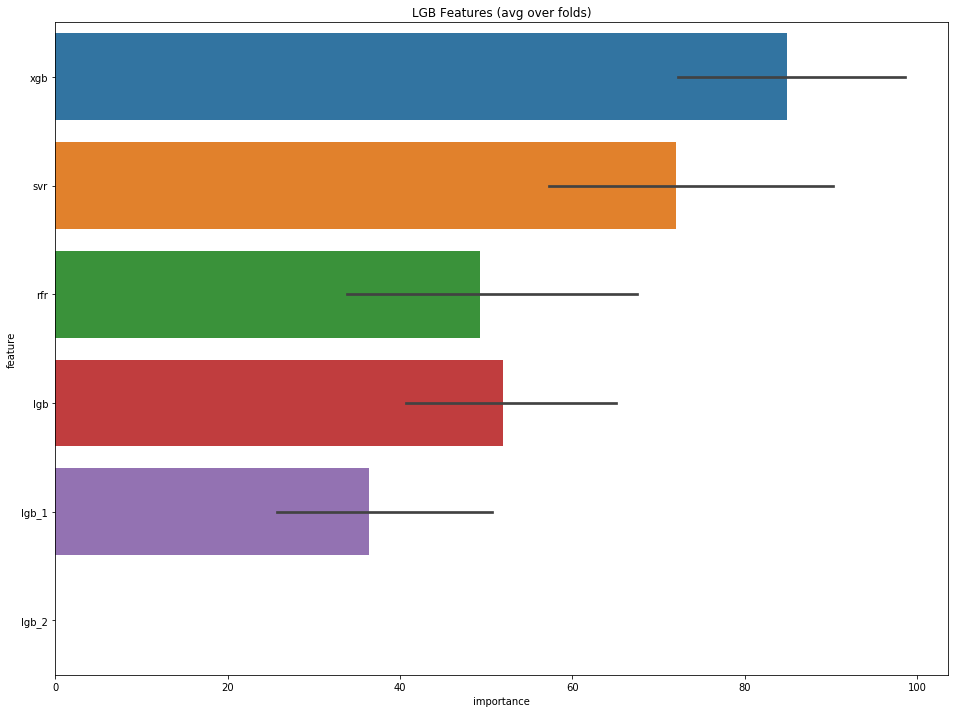

In [54]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [55]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:33:18 2019
Fold 1 started at Tue Dec 17 00:33:28 2019
Fold 2 started at Tue Dec 17 00:33:40 2019
Fold 3 started at Tue Dec 17 00:33:48 2019
Fold 4 started at Tue Dec 17 00:33:59 2019
Fold 5 started at Tue Dec 17 00:34:10 2019
Fold 6 started at Tue Dec 17 00:34:18 2019
Fold 7 started at Tue Dec 17 00:34:51 2019
Fold 8 started at Tue Dec 17 00:35:06 2019
Fold 9 started at Tue Dec 17 00:35:17 2019
CV mean score: 2.1102, std: 0.1418.


##### randomforest作为第二层融合模型

In [56]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:35:24 2019
Fold 1 started at Tue Dec 17 00:35:24 2019
Fold 2 started at Tue Dec 17 00:35:25 2019
Fold 3 started at Tue Dec 17 00:35:25 2019
Fold 4 started at Tue Dec 17 00:35:25 2019
Fold 5 started at Tue Dec 17 00:35:25 2019
Fold 6 started at Tue Dec 17 00:35:26 2019
Fold 7 started at Tue Dec 17 00:35:26 2019
Fold 8 started at Tue Dec 17 00:35:26 2019
Fold 9 started at Tue Dec 17 00:35:26 2019
CV mean score: 2.1633, std: 0.1455.


##### xgboost作为第二层融合模型

In [57]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:35:26 2019
[0]	train-rmse:9.87507	valid_data-rmse:9.86663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.56643	valid_data-rmse:2.26147
Stopping. Best iteration:
[410]	train-rmse:1.64184	valid_data-rmse:2.25225

Fold 1 started at Tue Dec 17 00:35:29 2019
[0]	train-rmse:9.87786	valid_data-rmse:9.84373
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58009	valid_data-rmse:2.22568
Stopping. Best iteration:
[488]	train-rmse:1.58864	valid_data-rmse:2.22467

Fold 2 started at Tue Dec 17 00:35:32 2019
[0]	train-rmse:9.91017	valid_data-rmse:9.54369
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [58]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:35:54 2019
Fold 1 started at Tue Dec 17 00:35:55 2019
Fold 2 started at Tue Dec 17 00:35:55 2019
Fold 3 started at Tue Dec 17 00:35:56 2019
Fold 4 started at Tue Dec 17 00:35:56 2019
Fold 5 started at Tue Dec 17 00:35:57 2019
Fold 6 started at Tue Dec 17 00:35:58 2019
Fold 7 started at Tue Dec 17 00:35:58 2019
Fold 8 started at Tue Dec 17 00:35:59 2019
Fold 9 started at Tue Dec 17 00:35:59 2019
CV mean score: 2.1768, std: 0.1760.


##### 岭回归做第二层融合模型

In [59]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:36:00 2019
Fold 1 started at Tue Dec 17 00:36:00 2019
Fold 2 started at Tue Dec 17 00:36:00 2019
Fold 3 started at Tue Dec 17 00:36:00 2019
Fold 4 started at Tue Dec 17 00:36:01 2019
Fold 5 started at Tue Dec 17 00:36:01 2019
Fold 6 started at Tue Dec 17 00:36:01 2019
Fold 7 started at Tue Dec 17 00:36:01 2019
Fold 8 started at Tue Dec 17 00:36:01 2019
Fold 9 started at Tue Dec 17 00:36:01 2019
CV mean score: 2.1114, std: 0.1411.


#### 去掉xgb和lgb的结果

In [60]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:36:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 1.96565	valid_1's rmse: 2.22193
Fold 1 started at Tue Dec 17 00:36:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 1.95885	valid_1's rmse: 2.19931
Fold 2 started at Tue Dec 17 00:36:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 2.01567	valid_1's rmse: 2.03808
Fold 3 started at Tue Dec 17 00:36:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[309]	training's rmse: 1.96861	valid_1's rmse: 2.07101
Fold 4 started at Tue Dec 17 00:36:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[411]	training's rmse: 1.90035	valid_1's rmse: 2.41122
Fold 5 started at Tu

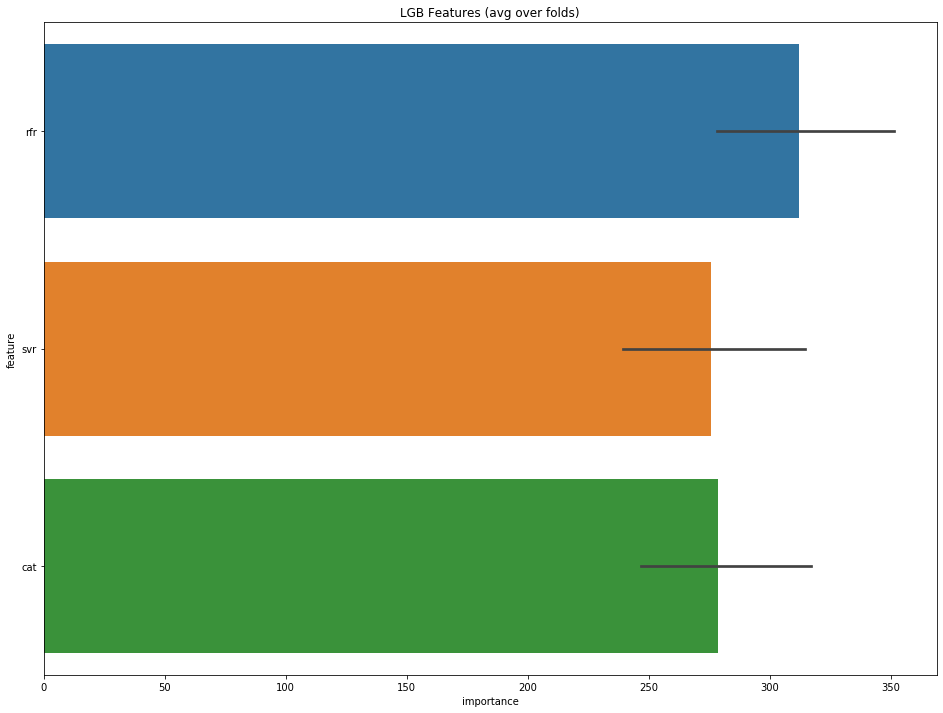

In [61]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:36:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[451]	training's rmse: 2.05725	valid_1's rmse: 2.18327
Fold 1 started at Tue Dec 17 00:37:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.01238	valid_1's rmse: 2.18285
Early stopping, best iteration is:
[876]	training's rmse: 2.02184	valid_1's rmse: 2.17965
Fold 2 started at Tue Dec 17 00:37:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[274]	training's rmse: 2.10194	valid_1's rmse: 2.02732
Fold 3 started at Tue Dec 17 00:37:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[397]	training's rmse: 2.08111	valid_1's rmse: 2.07546
Fold 4 started at Tue Dec 17 00:37:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[411]	training's rm

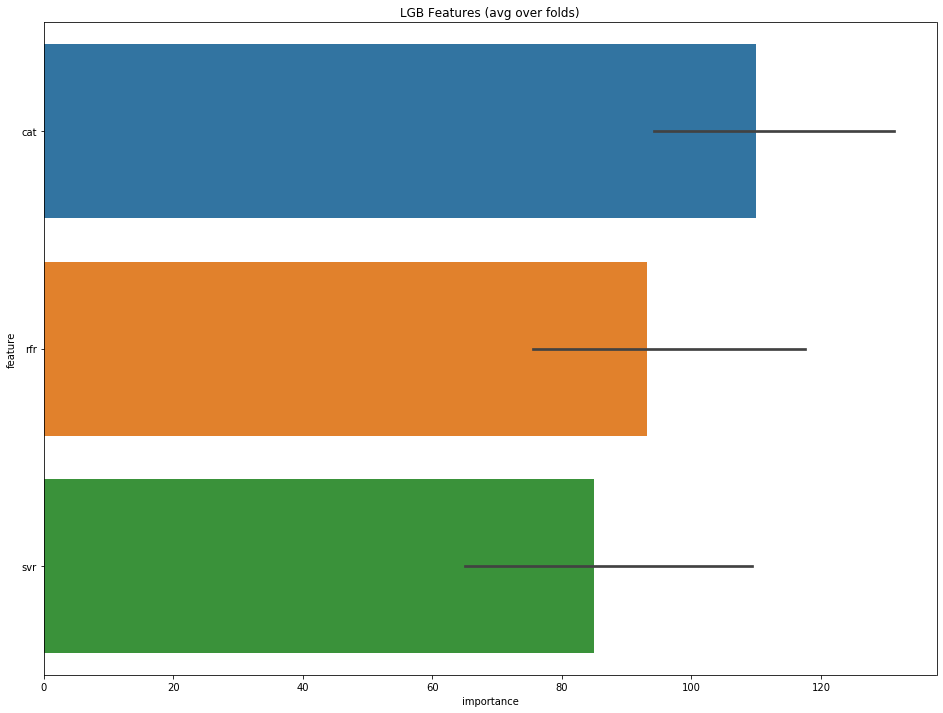

In [62]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [63]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:37:19 2019
Fold 1 started at Tue Dec 17 00:37:33 2019
Fold 2 started at Tue Dec 17 00:37:48 2019
Fold 3 started at Tue Dec 17 00:37:57 2019
Fold 4 started at Tue Dec 17 00:38:13 2019
Fold 5 started at Tue Dec 17 00:38:30 2019
Fold 6 started at Tue Dec 17 00:38:43 2019
Fold 7 started at Tue Dec 17 00:39:04 2019
Fold 8 started at Tue Dec 17 00:39:19 2019
Fold 9 started at Tue Dec 17 00:39:32 2019
CV mean score: 2.1318, std: 0.1449.


##### randomforest作为第二层融合模型

In [64]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:39:42 2019
Fold 1 started at Tue Dec 17 00:39:42 2019
Fold 2 started at Tue Dec 17 00:39:42 2019
Fold 3 started at Tue Dec 17 00:39:43 2019
Fold 4 started at Tue Dec 17 00:39:43 2019
Fold 5 started at Tue Dec 17 00:39:43 2019
Fold 6 started at Tue Dec 17 00:39:43 2019
Fold 7 started at Tue Dec 17 00:39:44 2019
Fold 8 started at Tue Dec 17 00:39:44 2019
Fold 9 started at Tue Dec 17 00:39:44 2019
CV mean score: 2.1793, std: 0.1427.


##### xgboost作为第二层融合模型

In [65]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:39:44 2019
[0]	train-rmse:9.87531	valid_data-rmse:9.86714
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.67285	valid_data-rmse:2.21371
Stopping. Best iteration:
[414]	train-rmse:1.73456	valid_data-rmse:2.2131

Fold 1 started at Tue Dec 17 00:39:46 2019
[0]	train-rmse:9.87815	valid_data-rmse:9.84389
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.68768	valid_data-rmse:2.23144
Stopping. Best iteration:
[453]	train-rmse:1.71755	valid_data-rmse:2.23088

Fold 2 started at Tue Dec 17 00:39:48 2019
[0]	train-rmse:9.91041	valid_data-rmse:9.54255
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [66]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:40:02 2019
Fold 1 started at Tue Dec 17 00:40:03 2019
Fold 2 started at Tue Dec 17 00:40:03 2019
Fold 3 started at Tue Dec 17 00:40:04 2019
Fold 4 started at Tue Dec 17 00:40:05 2019
Fold 5 started at Tue Dec 17 00:40:05 2019
Fold 6 started at Tue Dec 17 00:40:06 2019
Fold 7 started at Tue Dec 17 00:40:06 2019
Fold 8 started at Tue Dec 17 00:40:07 2019
Fold 9 started at Tue Dec 17 00:40:08 2019
CV mean score: 2.1874, std: 0.1723.


##### 岭回归做第二层融合模型

In [67]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:40:08 2019
Fold 1 started at Tue Dec 17 00:40:08 2019
Fold 2 started at Tue Dec 17 00:40:08 2019
Fold 3 started at Tue Dec 17 00:40:08 2019
Fold 4 started at Tue Dec 17 00:40:09 2019
Fold 5 started at Tue Dec 17 00:40:09 2019
Fold 6 started at Tue Dec 17 00:40:09 2019
Fold 7 started at Tue Dec 17 00:40:09 2019
Fold 8 started at Tue Dec 17 00:40:09 2019
Fold 9 started at Tue Dec 17 00:40:09 2019
CV mean score: 2.1287, std: 0.1411.


#### 去掉lgb和svr的结果

In [68]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:40:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[306]	training's rmse: 1.95497	valid_1's rmse: 2.23069
Fold 1 started at Tue Dec 17 00:40:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[264]	training's rmse: 1.97353	valid_1's rmse: 2.22012
Fold 2 started at Tue Dec 17 00:40:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.00861	valid_1's rmse: 1.99518
Fold 3 started at Tue Dec 17 00:40:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[270]	training's rmse: 1.98445	valid_1's rmse: 2.09652
Fold 4 started at Tue Dec 17 00:40:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[366]	training's rmse: 1.91975	valid_1's rmse: 2.38985
Fold 5 started at Tu

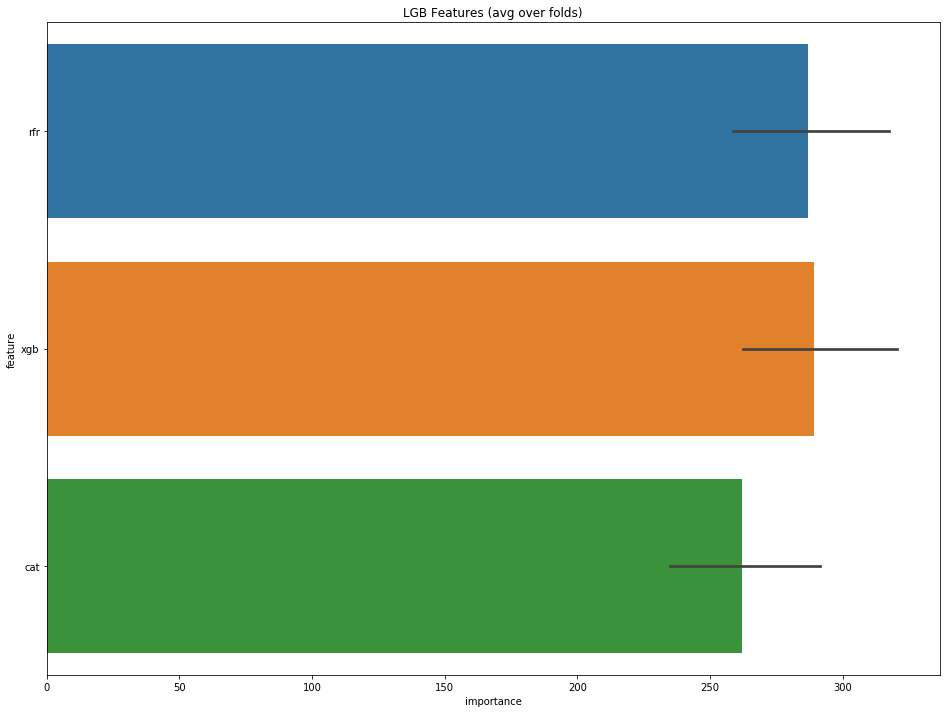

In [69]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:40:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 2.05517	valid_1's rmse: 2.1897
Fold 1 started at Tue Dec 17 00:40:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 2.04667	valid_1's rmse: 2.21137
Fold 2 started at Tue Dec 17 00:40:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.09648	valid_1's rmse: 1.98615
Fold 3 started at Tue Dec 17 00:40:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[482]	training's rmse: 2.05785	valid_1's rmse: 2.08066
Fold 4 started at Tue Dec 17 00:40:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 2.03932	valid_1's rmse: 2.33824
Fold 5 started at Tue

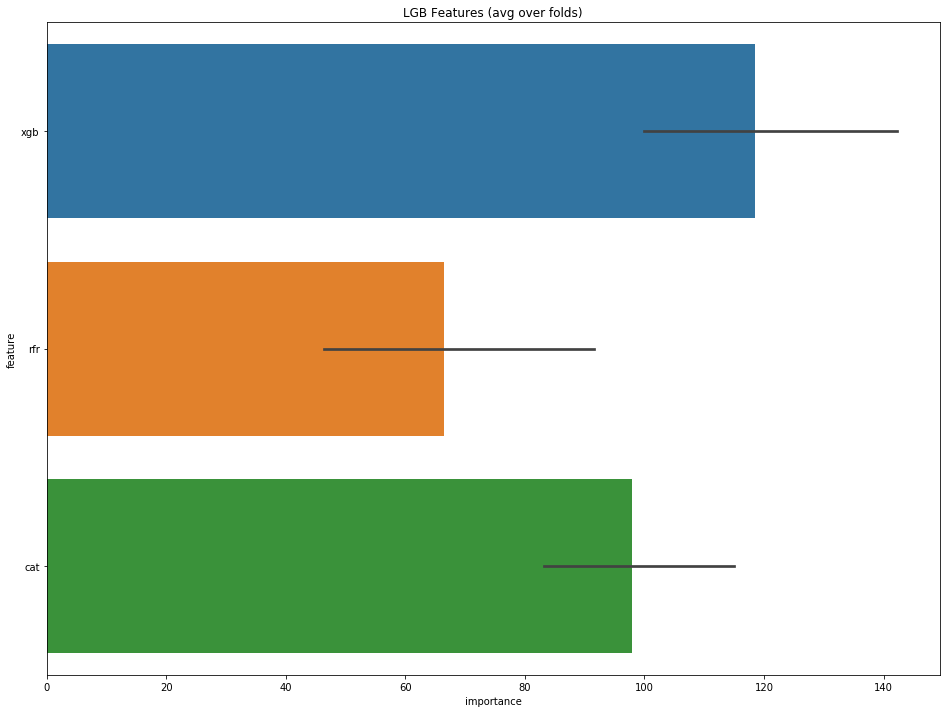

In [70]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [71]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:40:29 2019
Fold 1 started at Tue Dec 17 00:40:45 2019
Fold 2 started at Tue Dec 17 00:40:56 2019
Fold 3 started at Tue Dec 17 00:41:04 2019
Fold 4 started at Tue Dec 17 00:41:23 2019
Fold 5 started at Tue Dec 17 00:41:42 2019
Fold 6 started at Tue Dec 17 00:41:56 2019
Fold 7 started at Tue Dec 17 00:42:16 2019
Fold 8 started at Tue Dec 17 00:42:40 2019
Fold 9 started at Tue Dec 17 00:42:53 2019
CV mean score: 2.1142, std: 0.1492.


##### randomforest作为第二层融合模型

In [72]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:43:03 2019
Fold 1 started at Tue Dec 17 00:43:03 2019
Fold 2 started at Tue Dec 17 00:43:04 2019
Fold 3 started at Tue Dec 17 00:43:04 2019
Fold 4 started at Tue Dec 17 00:43:04 2019
Fold 5 started at Tue Dec 17 00:43:04 2019
Fold 6 started at Tue Dec 17 00:43:05 2019
Fold 7 started at Tue Dec 17 00:43:05 2019
Fold 8 started at Tue Dec 17 00:43:05 2019
Fold 9 started at Tue Dec 17 00:43:05 2019
CV mean score: 2.1934, std: 0.1482.


##### xgboost作为第二层融合模型

In [73]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:43:06 2019
[0]	train-rmse:9.87519	valid_data-rmse:9.86702
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.69233	valid_data-rmse:2.23197
Stopping. Best iteration:
[406]	train-rmse:1.75772	valid_data-rmse:2.22886

Fold 1 started at Tue Dec 17 00:43:07 2019
[0]	train-rmse:9.878	valid_data-rmse:9.84376
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.69966	valid_data-rmse:2.2535
Stopping. Best iteration:
[466]	train-rmse:1.71989	valid_data-rmse:2.25123

Fold 2 started at Tue Dec 17 00:43:09 2019
[0]	train-rmse:9.91034	valid_data-rmse:9.54294
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [74]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:43:23 2019
Fold 1 started at Tue Dec 17 00:43:24 2019
Fold 2 started at Tue Dec 17 00:43:24 2019
Fold 3 started at Tue Dec 17 00:43:25 2019
Fold 4 started at Tue Dec 17 00:43:26 2019
Fold 5 started at Tue Dec 17 00:43:26 2019
Fold 6 started at Tue Dec 17 00:43:27 2019
Fold 7 started at Tue Dec 17 00:43:27 2019
Fold 8 started at Tue Dec 17 00:43:28 2019
Fold 9 started at Tue Dec 17 00:43:29 2019
CV mean score: 2.1736, std: 0.1727.


##### 岭回归做第二层融合模型

In [75]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:43:29 2019
Fold 1 started at Tue Dec 17 00:43:29 2019
Fold 2 started at Tue Dec 17 00:43:29 2019
Fold 3 started at Tue Dec 17 00:43:30 2019
Fold 4 started at Tue Dec 17 00:43:30 2019
Fold 5 started at Tue Dec 17 00:43:30 2019
Fold 6 started at Tue Dec 17 00:43:30 2019
Fold 7 started at Tue Dec 17 00:43:30 2019
Fold 8 started at Tue Dec 17 00:43:30 2019
Fold 9 started at Tue Dec 17 00:43:30 2019
CV mean score: 2.1126, std: 0.1431.


#### 去掉lgb和rfr的结果

In [77]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:09:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 1.93172	valid_1's rmse: 2.18699
Fold 1 started at Tue Dec 17 01:10:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[282]	training's rmse: 1.94241	valid_1's rmse: 2.20842
Fold 2 started at Tue Dec 17 01:10:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[227]	training's rmse: 1.99323	valid_1's rmse: 1.99206
Fold 3 started at Tue Dec 17 01:10:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's rmse: 1.95069	valid_1's rmse: 2.07342
Fold 4 started at Tue Dec 17 01:10:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 1.90619	valid_1's rmse: 2.37416
Fold 5 started at Tu

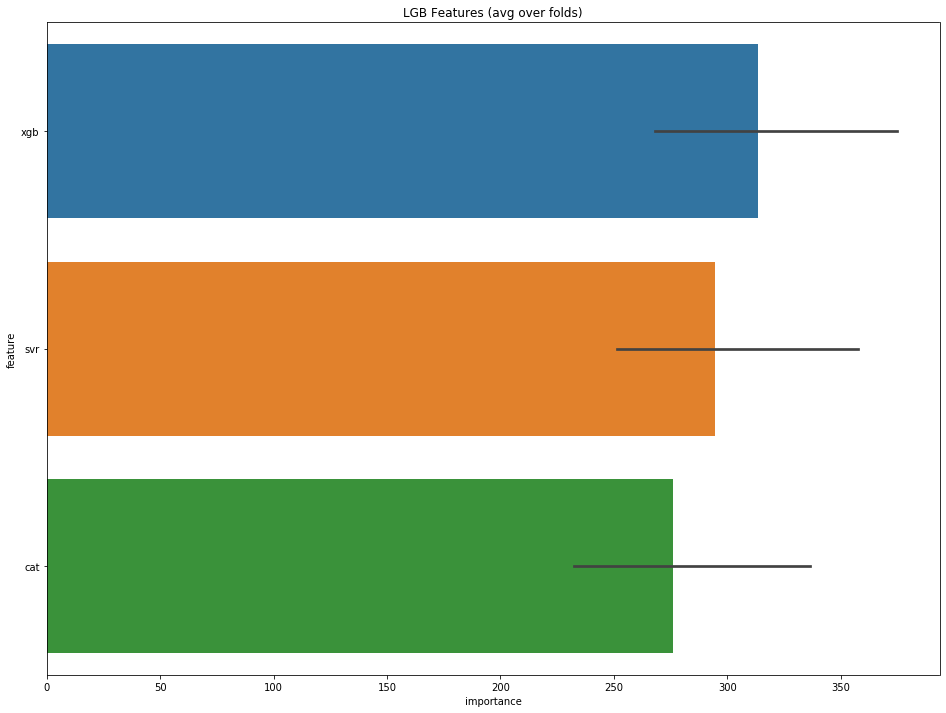

In [78]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:10:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 2.02599	valid_1's rmse: 2.18604
Fold 1 started at Tue Dec 17 01:11:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.98319	valid_1's rmse: 2.18259
Early stopping, best iteration is:
[1498]	training's rmse: 1.94931	valid_1's rmse: 2.17636
Fold 2 started at Tue Dec 17 01:11:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 2.09432	valid_1's rmse: 1.98581
Fold 3 started at Tue Dec 17 01:11:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[282]	training's rmse: 2.07184	valid_1's rmse: 2.08786
Fold 4 started at Tue Dec 17 01:11:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[328]	training's r

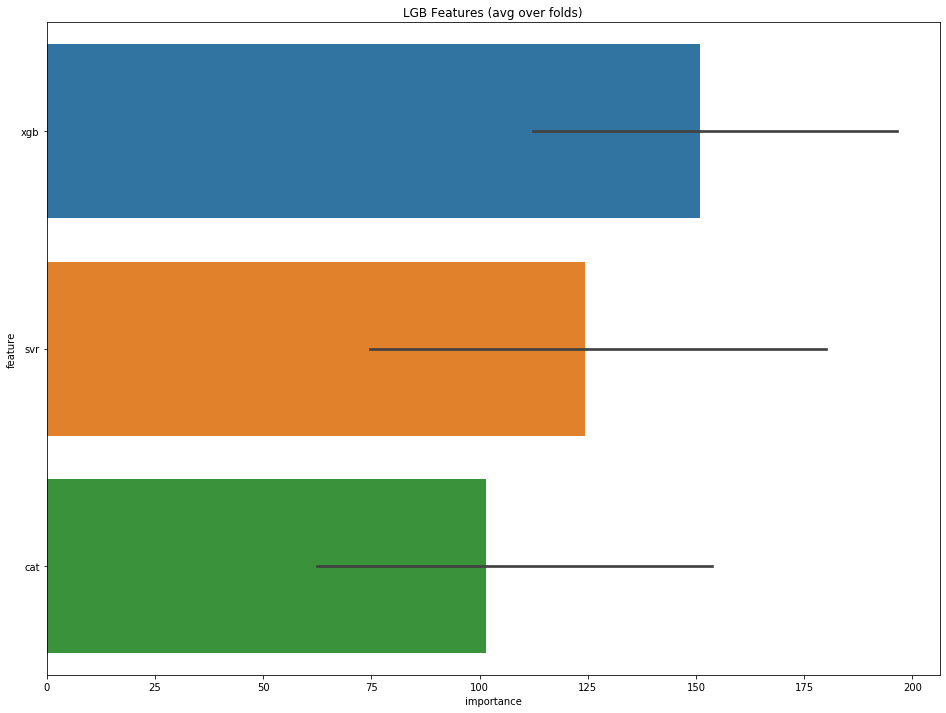

In [79]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [80]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:11:44 2019
Fold 1 started at Tue Dec 17 01:12:06 2019
Fold 2 started at Tue Dec 17 01:12:23 2019
Fold 3 started at Tue Dec 17 01:12:35 2019
Fold 4 started at Tue Dec 17 01:12:55 2019
Fold 5 started at Tue Dec 17 01:13:13 2019
Fold 6 started at Tue Dec 17 01:13:30 2019
Fold 7 started at Tue Dec 17 01:13:50 2019
Fold 8 started at Tue Dec 17 01:14:10 2019
Fold 9 started at Tue Dec 17 01:14:31 2019
CV mean score: 2.1128, std: 0.1459.


##### randomforest作为第二层融合模型

In [81]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:14:43 2019
Fold 1 started at Tue Dec 17 01:14:43 2019
Fold 2 started at Tue Dec 17 01:14:44 2019
Fold 3 started at Tue Dec 17 01:14:44 2019
Fold 4 started at Tue Dec 17 01:14:44 2019
Fold 5 started at Tue Dec 17 01:14:44 2019
Fold 6 started at Tue Dec 17 01:14:45 2019
Fold 7 started at Tue Dec 17 01:14:45 2019
Fold 8 started at Tue Dec 17 01:14:45 2019
Fold 9 started at Tue Dec 17 01:14:45 2019
CV mean score: 2.1539, std: 0.1506.


##### xgboost作为第二层融合模型

In [82]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:14:45 2019
[0]	train-rmse:9.87524	valid_data-rmse:9.86725
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.67356	valid_data-rmse:2.22366
Stopping. Best iteration:
[412]	train-rmse:1.73265	valid_data-rmse:2.22127

Fold 1 started at Tue Dec 17 01:14:47 2019
[0]	train-rmse:9.87797	valid_data-rmse:9.84368
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.66721	valid_data-rmse:2.21589
Stopping. Best iteration:
[547]	train-rmse:1.64198	valid_data-rmse:2.21402

Fold 2 started at Tue Dec 17 01:14:51 2019
[0]	train-rmse:9.91034	valid_data-rmse:9.54294
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [83]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:15:21 2019
Fold 1 started at Tue Dec 17 01:15:22 2019
Fold 2 started at Tue Dec 17 01:15:22 2019
Fold 3 started at Tue Dec 17 01:15:23 2019
Fold 4 started at Tue Dec 17 01:15:24 2019
Fold 5 started at Tue Dec 17 01:15:25 2019
Fold 6 started at Tue Dec 17 01:15:25 2019
Fold 7 started at Tue Dec 17 01:15:26 2019
Fold 8 started at Tue Dec 17 01:15:27 2019
Fold 9 started at Tue Dec 17 01:15:27 2019
CV mean score: 2.1761, std: 0.1771.


##### 岭回归做第二层融合模型

In [84]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:15:28 2019
Fold 1 started at Tue Dec 17 01:15:28 2019
Fold 2 started at Tue Dec 17 01:15:28 2019
Fold 3 started at Tue Dec 17 01:15:28 2019
Fold 4 started at Tue Dec 17 01:15:28 2019
Fold 5 started at Tue Dec 17 01:15:29 2019
Fold 6 started at Tue Dec 17 01:15:29 2019
Fold 7 started at Tue Dec 17 01:15:29 2019
Fold 8 started at Tue Dec 17 01:15:29 2019
Fold 9 started at Tue Dec 17 01:15:29 2019
CV mean score: 2.1114, std: 0.1416.


#### 去掉lgb和cat的结果

In [85]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:15:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 1.931	valid_1's rmse: 2.22033
Fold 1 started at Tue Dec 17 01:15:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 1.95159	valid_1's rmse: 2.21375
Fold 2 started at Tue Dec 17 01:15:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[214]	training's rmse: 2.01054	valid_1's rmse: 2.00146
Fold 3 started at Tue Dec 17 01:15:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[287]	training's rmse: 1.95388	valid_1's rmse: 2.09856
Fold 4 started at Tue Dec 17 01:15:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[367]	training's rmse: 1.8925	valid_1's rmse: 2.40291
Fold 5 started at Tue D

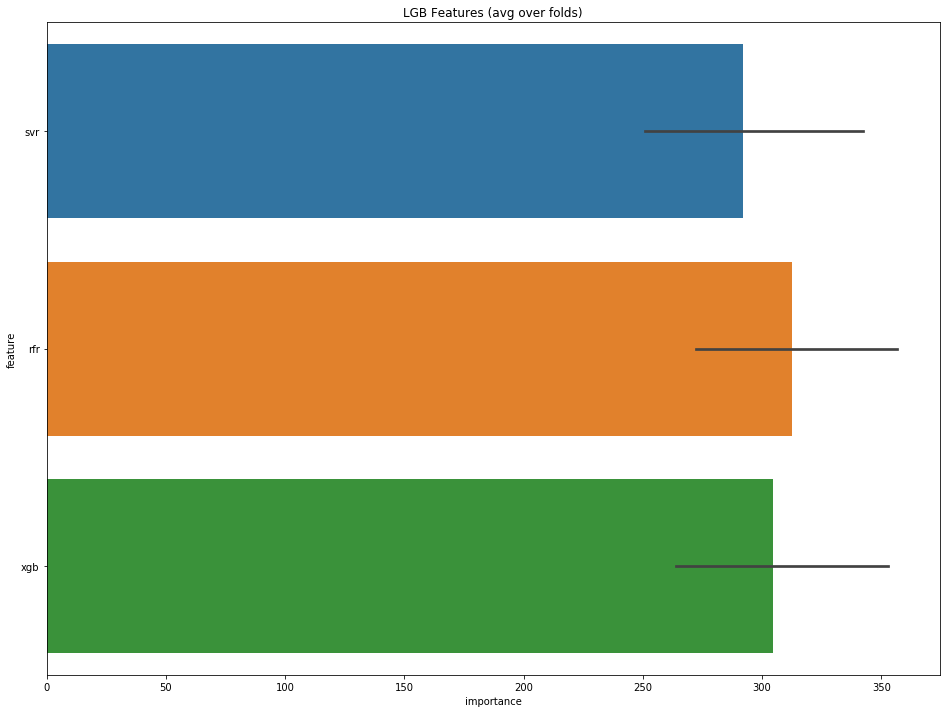

In [86]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:15:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[376]	training's rmse: 2.05232	valid_1's rmse: 2.18791
Fold 1 started at Tue Dec 17 01:15:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[430]	training's rmse: 2.03934	valid_1's rmse: 2.19351
Fold 2 started at Tue Dec 17 01:15:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[245]	training's rmse: 2.09784	valid_1's rmse: 1.96992
Fold 3 started at Tue Dec 17 01:15:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 2.07069	valid_1's rmse: 2.10395
Fold 4 started at Tue Dec 17 01:15:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 2.02809	valid_1's rmse: 2.359
Fold 5 started at Tue 

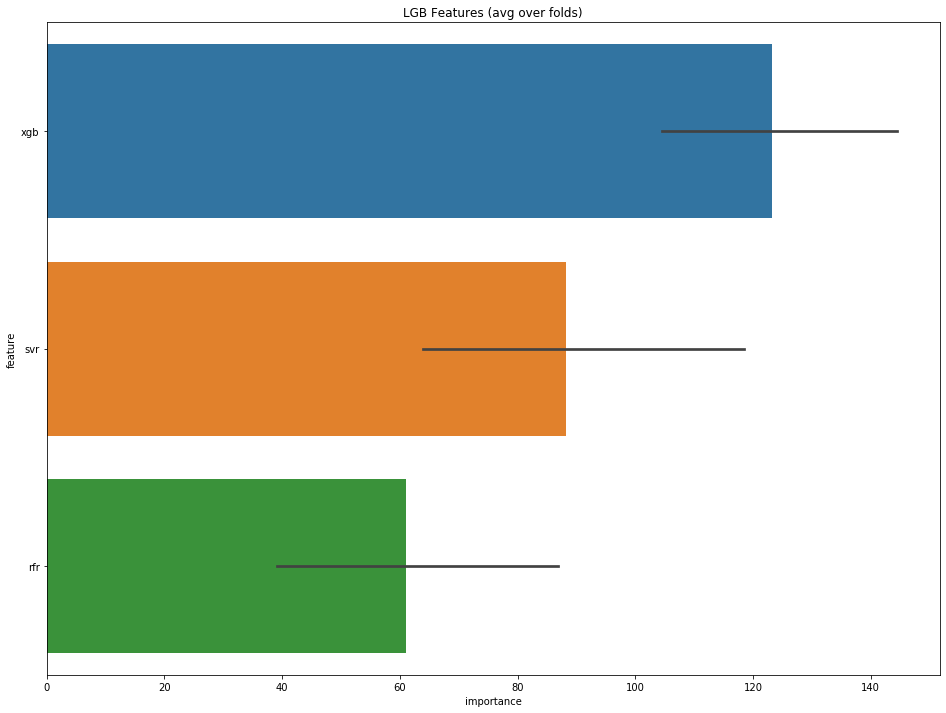

In [87]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [88]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:15:51 2019
Fold 1 started at Tue Dec 17 01:16:07 2019
Fold 2 started at Tue Dec 17 01:16:20 2019
Fold 3 started at Tue Dec 17 01:16:30 2019
Fold 4 started at Tue Dec 17 01:16:41 2019
Fold 5 started at Tue Dec 17 01:16:56 2019
Fold 6 started at Tue Dec 17 01:17:12 2019
Fold 7 started at Tue Dec 17 01:17:34 2019
Fold 8 started at Tue Dec 17 01:17:52 2019
Fold 9 started at Tue Dec 17 01:18:18 2019
CV mean score: 2.1136, std: 0.1551.


##### randomforest作为第二层融合模型

In [89]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:19:12 2019
Fold 1 started at Tue Dec 17 01:19:13 2019
Fold 2 started at Tue Dec 17 01:19:13 2019
Fold 3 started at Tue Dec 17 01:19:13 2019
Fold 4 started at Tue Dec 17 01:19:13 2019
Fold 5 started at Tue Dec 17 01:19:14 2019
Fold 6 started at Tue Dec 17 01:19:14 2019
Fold 7 started at Tue Dec 17 01:19:14 2019
Fold 8 started at Tue Dec 17 01:19:14 2019
Fold 9 started at Tue Dec 17 01:19:14 2019
CV mean score: 2.1632, std: 0.1496.


##### xgboost作为第二层融合模型

In [90]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:19:15 2019
[0]	train-rmse:9.87531	valid_data-rmse:9.86714
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.65895	valid_data-rmse:2.23312
Stopping. Best iteration:
[412]	train-rmse:1.72321	valid_data-rmse:2.23102

Fold 1 started at Tue Dec 17 01:19:16 2019
[0]	train-rmse:9.87815	valid_data-rmse:9.84389
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.66051	valid_data-rmse:2.22593
Stopping. Best iteration:
[444]	train-rmse:1.69677	valid_data-rmse:2.22435

Fold 2 started at Tue Dec 17 01:19:18 2019
[0]	train-rmse:9.91041	valid_data-rmse:9.54255
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [91]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:19:32 2019
Fold 1 started at Tue Dec 17 01:19:33 2019
Fold 2 started at Tue Dec 17 01:19:33 2019
Fold 3 started at Tue Dec 17 01:19:34 2019
Fold 4 started at Tue Dec 17 01:19:34 2019
Fold 5 started at Tue Dec 17 01:19:35 2019
Fold 6 started at Tue Dec 17 01:19:35 2019
Fold 7 started at Tue Dec 17 01:19:36 2019
Fold 8 started at Tue Dec 17 01:19:37 2019
Fold 9 started at Tue Dec 17 01:19:37 2019
CV mean score: 2.1779, std: 0.1831.


##### 岭回归做第二层融合模型

In [92]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:19:38 2019
Fold 1 started at Tue Dec 17 01:19:38 2019
Fold 2 started at Tue Dec 17 01:19:38 2019
Fold 3 started at Tue Dec 17 01:19:38 2019
Fold 4 started at Tue Dec 17 01:19:38 2019
Fold 5 started at Tue Dec 17 01:19:38 2019
Fold 6 started at Tue Dec 17 01:19:38 2019
Fold 7 started at Tue Dec 17 01:19:39 2019
Fold 8 started at Tue Dec 17 01:19:39 2019
Fold 9 started at Tue Dec 17 01:19:39 2019
CV mean score: 2.1154, std: 0.1437.


#### 去掉xgb和svr

In [93]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:19:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	training's rmse: 1.95682	valid_1's rmse: 2.23761
Fold 1 started at Tue Dec 17 01:19:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 1.95302	valid_1's rmse: 2.23137
Fold 2 started at Tue Dec 17 01:19:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 2.00418	valid_1's rmse: 2.0265
Fold 3 started at Tue Dec 17 01:19:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 1.94788	valid_1's rmse: 2.10666
Fold 4 started at Tue Dec 17 01:19:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 1.91767	valid_1's rmse: 2.38037
Fold 5 started at Tue

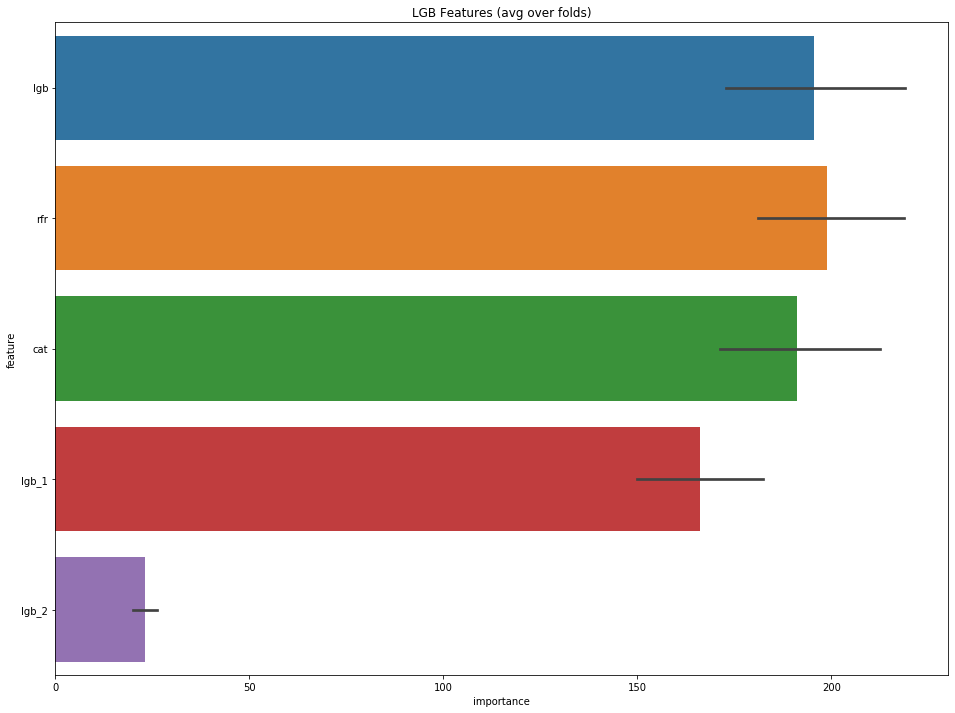

In [94]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:19:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	training's rmse: 2.06666	valid_1's rmse: 2.17407
Fold 1 started at Tue Dec 17 01:19:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 2.04843	valid_1's rmse: 2.21715
Fold 2 started at Tue Dec 17 01:19:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 2.09895	valid_1's rmse: 2.00946
Fold 3 started at Tue Dec 17 01:19:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.02862	valid_1's rmse: 2.1002
Early stopping, best iteration is:
[971]	training's rmse: 2.03122	valid_1's rmse: 2.09968
Fold 4 started at Tue Dec 17 01:19:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[341]	training's rms

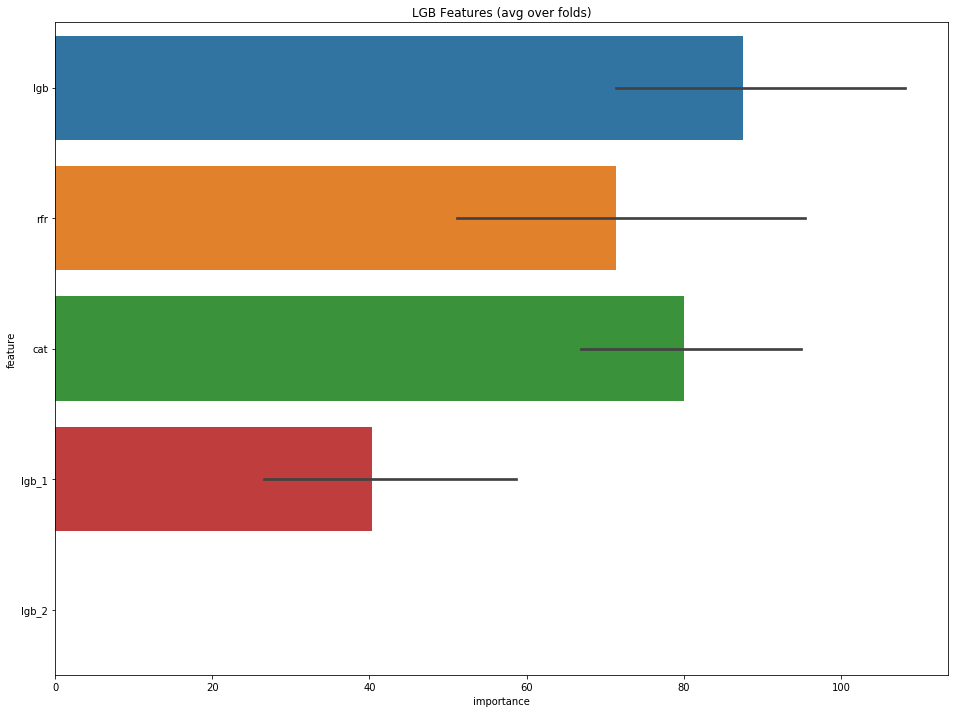

In [95]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [96]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:19:58 2019
Fold 1 started at Tue Dec 17 01:20:13 2019
Fold 2 started at Tue Dec 17 01:20:24 2019
Fold 3 started at Tue Dec 17 01:20:33 2019
Fold 4 started at Tue Dec 17 01:20:50 2019
Fold 5 started at Tue Dec 17 01:21:07 2019
Fold 6 started at Tue Dec 17 01:21:18 2019
Fold 7 started at Tue Dec 17 01:21:39 2019
Fold 8 started at Tue Dec 17 01:22:15 2019
Fold 9 started at Tue Dec 17 01:22:28 2019
CV mean score: 2.1160, std: 0.1424.


##### randomforest作为第二层融合模型

In [97]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:22:39 2019
Fold 1 started at Tue Dec 17 01:22:39 2019
Fold 2 started at Tue Dec 17 01:22:40 2019
Fold 3 started at Tue Dec 17 01:22:40 2019
Fold 4 started at Tue Dec 17 01:22:40 2019
Fold 5 started at Tue Dec 17 01:22:40 2019
Fold 6 started at Tue Dec 17 01:22:41 2019
Fold 7 started at Tue Dec 17 01:22:41 2019
Fold 8 started at Tue Dec 17 01:22:41 2019
Fold 9 started at Tue Dec 17 01:22:41 2019
CV mean score: 2.1761, std: 0.1279.


##### xgboost作为第二层融合模型

In [98]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:22:42 2019
[0]	train-rmse:9.87513	valid_data-rmse:9.86737
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.63093	valid_data-rmse:2.23184
Stopping. Best iteration:
[424]	train-rmse:1.68537	valid_data-rmse:2.22902

Fold 1 started at Tue Dec 17 01:22:44 2019
[0]	train-rmse:9.87787	valid_data-rmse:9.84328
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.63358	valid_data-rmse:2.23462
Stopping. Best iteration:
[402]	train-rmse:1.70607	valid_data-rmse:2.2326

Fold 2 started at Tue Dec 17 01:22:47 2019
[0]	train-rmse:9.91014	valid_data-rmse:9.54247
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [99]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:23:08 2019
Fold 1 started at Tue Dec 17 01:23:09 2019
Fold 2 started at Tue Dec 17 01:23:10 2019
Fold 3 started at Tue Dec 17 01:23:10 2019
Fold 4 started at Tue Dec 17 01:23:11 2019
Fold 5 started at Tue Dec 17 01:23:11 2019
Fold 6 started at Tue Dec 17 01:23:12 2019
Fold 7 started at Tue Dec 17 01:23:13 2019
Fold 8 started at Tue Dec 17 01:23:13 2019
Fold 9 started at Tue Dec 17 01:23:14 2019
CV mean score: 2.1649, std: 0.1684.


##### 岭回归做第二层融合模型

In [100]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:23:15 2019
Fold 1 started at Tue Dec 17 01:23:15 2019
Fold 2 started at Tue Dec 17 01:23:15 2019
Fold 3 started at Tue Dec 17 01:23:15 2019
Fold 4 started at Tue Dec 17 01:23:15 2019
Fold 5 started at Tue Dec 17 01:23:15 2019
Fold 6 started at Tue Dec 17 01:23:15 2019
Fold 7 started at Tue Dec 17 01:23:15 2019
Fold 8 started at Tue Dec 17 01:23:16 2019
Fold 9 started at Tue Dec 17 01:23:16 2019
CV mean score: 2.1153, std: 0.1403.


#### 去掉xgb和rfr

In [101]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:23:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 1.92096	valid_1's rmse: 2.20112
Fold 1 started at Tue Dec 17 01:23:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[247]	training's rmse: 1.94647	valid_1's rmse: 2.23827
Fold 2 started at Tue Dec 17 01:23:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[217]	training's rmse: 1.9896	valid_1's rmse: 2.03884
Fold 3 started at Tue Dec 17 01:23:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 1.9284	valid_1's rmse: 2.1116
Fold 4 started at Tue Dec 17 01:23:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[442]	training's rmse: 1.85719	valid_1's rmse: 2.36099
Fold 5 started at Tue D

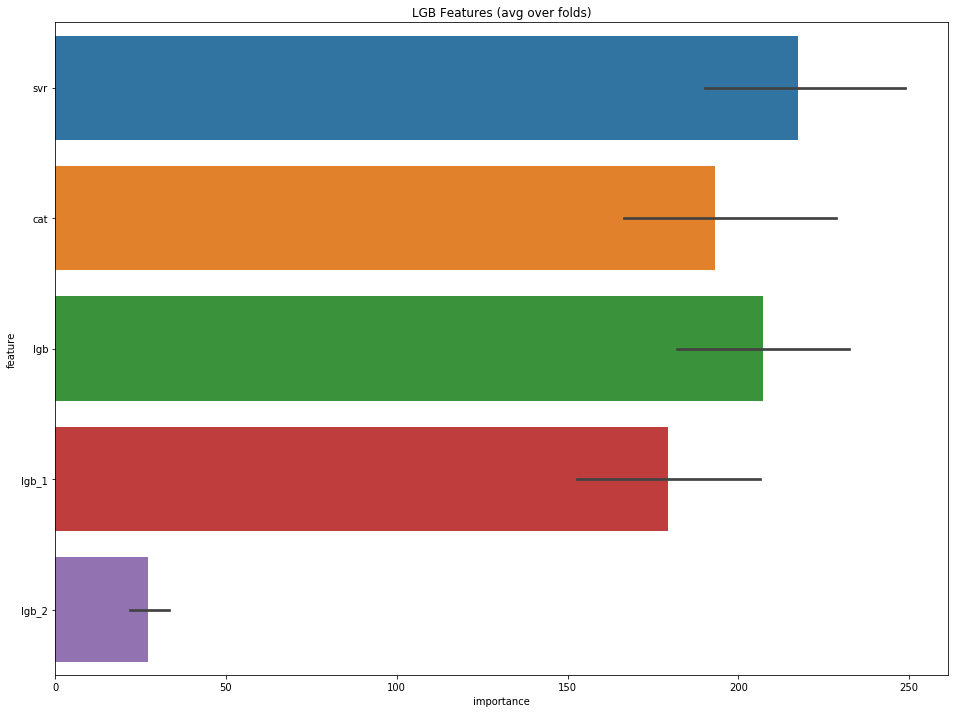

In [102]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:23:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[462]	training's rmse: 2.04242	valid_1's rmse: 2.17237
Fold 1 started at Tue Dec 17 01:23:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[340]	training's rmse: 2.05462	valid_1's rmse: 2.20755
Fold 2 started at Tue Dec 17 01:23:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[256]	training's rmse: 2.0902	valid_1's rmse: 2.01084
Fold 3 started at Tue Dec 17 01:23:28 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.01874	valid_1's rmse: 2.09096
Early stopping, best iteration is:
[1066]	training's rmse: 2.01467	valid_1's rmse: 2.08985
Fold 4 started at Tue Dec 17 01:23:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[320]	training's rm

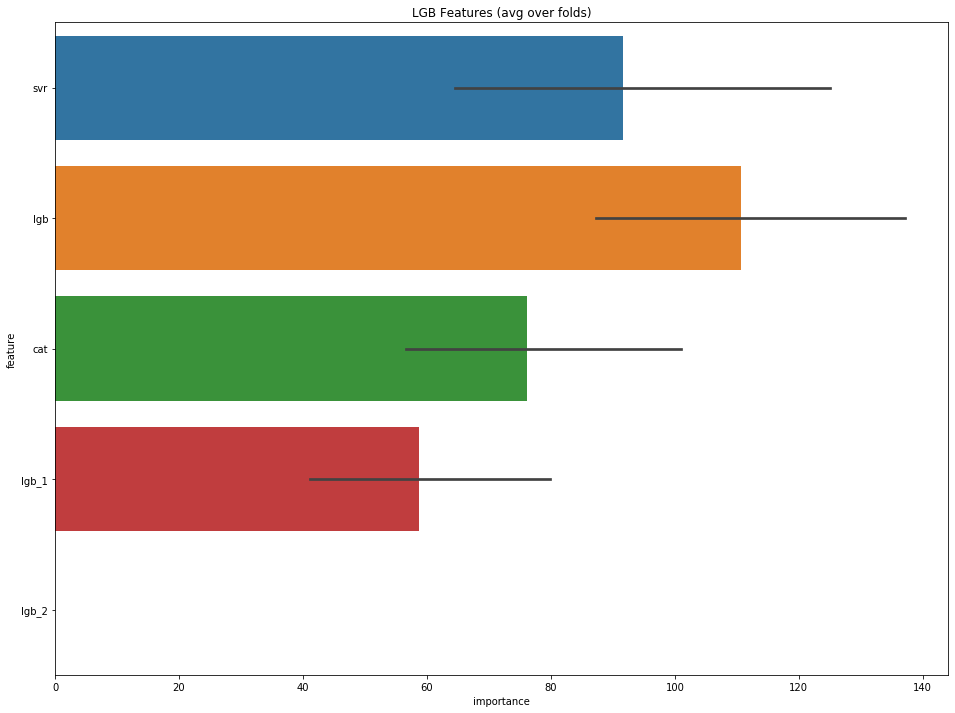

In [103]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [104]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:23:38 2019
Fold 1 started at Tue Dec 17 01:23:51 2019
Fold 2 started at Tue Dec 17 01:24:04 2019
Fold 3 started at Tue Dec 17 01:24:14 2019
Fold 4 started at Tue Dec 17 01:24:26 2019
Fold 5 started at Tue Dec 17 01:24:42 2019
Fold 6 started at Tue Dec 17 01:24:55 2019
Fold 7 started at Tue Dec 17 01:25:16 2019
Fold 8 started at Tue Dec 17 01:25:33 2019
Fold 9 started at Tue Dec 17 01:25:46 2019
CV mean score: 2.1167, std: 0.1386.


##### randomforest作为第二层融合模型

In [105]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:25:56 2019
Fold 1 started at Tue Dec 17 01:25:56 2019
Fold 2 started at Tue Dec 17 01:25:56 2019
Fold 3 started at Tue Dec 17 01:25:56 2019
Fold 4 started at Tue Dec 17 01:25:57 2019
Fold 5 started at Tue Dec 17 01:25:57 2019
Fold 6 started at Tue Dec 17 01:25:57 2019
Fold 7 started at Tue Dec 17 01:25:57 2019
Fold 8 started at Tue Dec 17 01:25:58 2019
Fold 9 started at Tue Dec 17 01:25:58 2019
CV mean score: 2.1550, std: 0.1298.


##### xgboost作为第二层融合模型

In [106]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:25:58 2019
[0]	train-rmse:9.87513	valid_data-rmse:9.86737
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.61557	valid_data-rmse:2.22073
Stopping. Best iteration:
[434]	train-rmse:1.66498	valid_data-rmse:2.21821

Fold 1 started at Tue Dec 17 01:26:01 2019
[0]	train-rmse:9.87787	valid_data-rmse:9.84328
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.61586	valid_data-rmse:2.23092
Stopping. Best iteration:
[433]	train-rmse:1.66208	valid_data-rmse:2.22921

Fold 2 started at Tue Dec 17 01:26:03 2019
[0]	train-rmse:9.91014	valid_data-rmse:9.54247
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [107]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:26:22 2019
Fold 1 started at Tue Dec 17 01:26:23 2019
Fold 2 started at Tue Dec 17 01:26:23 2019
Fold 3 started at Tue Dec 17 01:26:24 2019
Fold 4 started at Tue Dec 17 01:26:24 2019
Fold 5 started at Tue Dec 17 01:26:25 2019
Fold 6 started at Tue Dec 17 01:26:26 2019
Fold 7 started at Tue Dec 17 01:26:26 2019
Fold 8 started at Tue Dec 17 01:26:27 2019
Fold 9 started at Tue Dec 17 01:26:27 2019
CV mean score: 2.1720, std: 0.1678.


##### 岭回归做第二层融合模型

In [108]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:26:28 2019
Fold 1 started at Tue Dec 17 01:26:28 2019
Fold 2 started at Tue Dec 17 01:26:28 2019
Fold 3 started at Tue Dec 17 01:26:28 2019
Fold 4 started at Tue Dec 17 01:26:28 2019
Fold 5 started at Tue Dec 17 01:26:29 2019
Fold 6 started at Tue Dec 17 01:26:29 2019
Fold 7 started at Tue Dec 17 01:26:29 2019
Fold 8 started at Tue Dec 17 01:26:29 2019
Fold 9 started at Tue Dec 17 01:26:29 2019
CV mean score: 2.1141, std: 0.1385.


#### 去掉xgb和cat

In [109]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:26:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 1.95696	valid_1's rmse: 2.23509
Fold 1 started at Tue Dec 17 01:26:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 1.907	valid_1's rmse: 2.21308
Fold 2 started at Tue Dec 17 01:26:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 1.98866	valid_1's rmse: 2.03885
Fold 3 started at Tue Dec 17 01:26:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[328]	training's rmse: 1.92045	valid_1's rmse: 2.12369
Fold 4 started at Tue Dec 17 01:26:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[346]	training's rmse: 1.88251	valid_1's rmse: 2.37819
Fold 5 started at Tue 

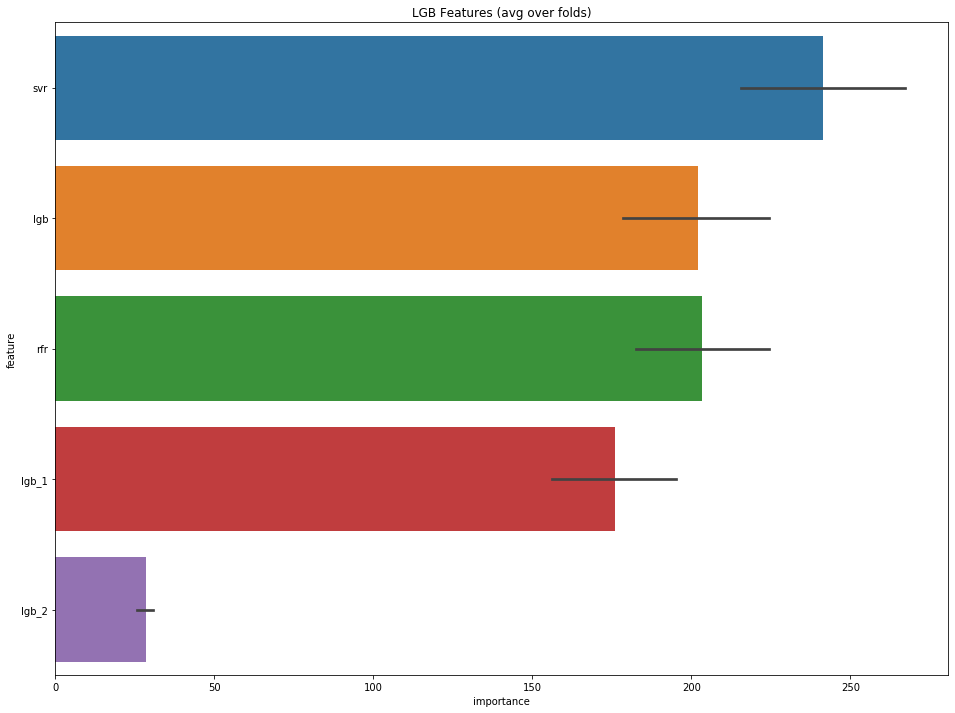

In [110]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:27:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[370]	training's rmse: 2.05477	valid_1's rmse: 2.1807
Fold 1 started at Tue Dec 17 01:27:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 2.04418	valid_1's rmse: 2.20881
Fold 2 started at Tue Dec 17 01:27:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.09709	valid_1's rmse: 1.99667
Fold 3 started at Tue Dec 17 01:27:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.02098	valid_1's rmse: 2.09935
Early stopping, best iteration is:
[1058]	training's rmse: 2.01648	valid_1's rmse: 2.09846
Fold 4 started at Tue Dec 17 01:27:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[679]	training's rm

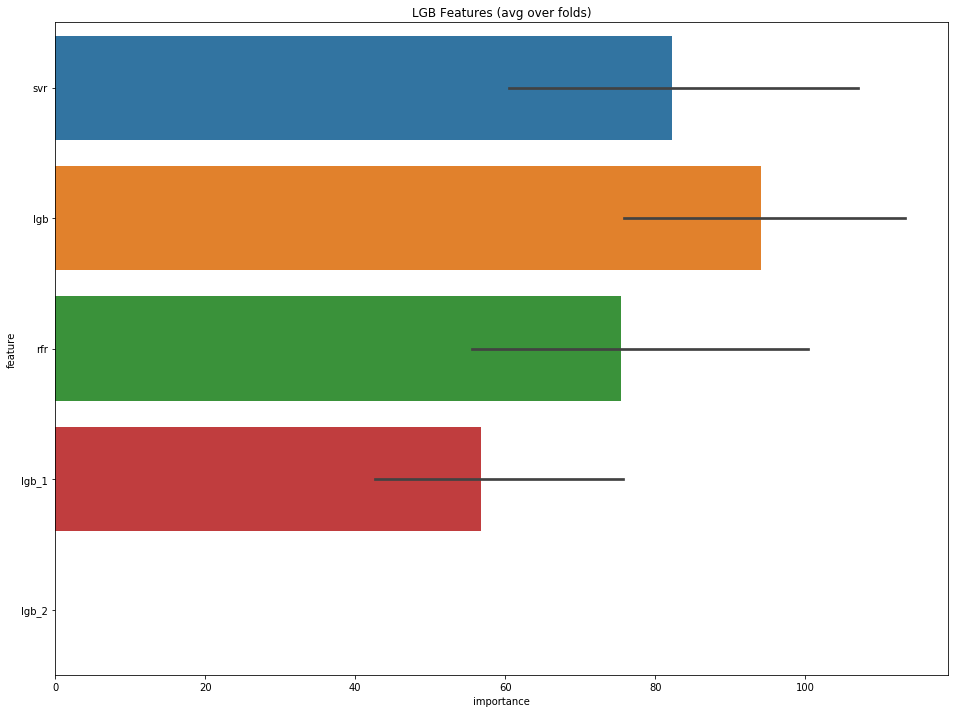

In [111]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [112]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:28:04 2019
Fold 1 started at Tue Dec 17 01:28:18 2019
Fold 2 started at Tue Dec 17 01:28:35 2019
Fold 3 started at Tue Dec 17 01:28:45 2019
Fold 4 started at Tue Dec 17 01:28:58 2019
Fold 5 started at Tue Dec 17 01:29:14 2019
Fold 6 started at Tue Dec 17 01:29:26 2019
Fold 7 started at Tue Dec 17 01:30:07 2019
Fold 8 started at Tue Dec 17 01:30:37 2019
Fold 9 started at Tue Dec 17 01:30:50 2019
CV mean score: 2.1159, std: 0.1385.


##### randomforest作为第二层融合模型

In [113]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:30:59 2019
Fold 1 started at Tue Dec 17 01:30:59 2019
Fold 2 started at Tue Dec 17 01:31:00 2019
Fold 3 started at Tue Dec 17 01:31:00 2019
Fold 4 started at Tue Dec 17 01:31:00 2019
Fold 5 started at Tue Dec 17 01:31:00 2019
Fold 6 started at Tue Dec 17 01:31:01 2019
Fold 7 started at Tue Dec 17 01:31:01 2019
Fold 8 started at Tue Dec 17 01:31:01 2019
Fold 9 started at Tue Dec 17 01:31:01 2019
CV mean score: 2.1762, std: 0.1338.


##### xgboost作为第二层融合模型

In [114]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:31:02 2019
[0]	train-rmse:9.87513	valid_data-rmse:9.86686
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.60217	valid_data-rmse:2.23963
Stopping. Best iteration:
[478]	train-rmse:1.61809	valid_data-rmse:2.23784

Fold 1 started at Tue Dec 17 01:31:04 2019
[0]	train-rmse:9.87786	valid_data-rmse:9.84327
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.60871	valid_data-rmse:2.2222
Stopping. Best iteration:
[533]	train-rmse:1.58906	valid_data-rmse:2.21967

Fold 2 started at Tue Dec 17 01:31:07 2019
[0]	train-rmse:9.91015	valid_data-rmse:9.5419
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [115]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:31:28 2019
Fold 1 started at Tue Dec 17 01:31:29 2019
Fold 2 started at Tue Dec 17 01:31:29 2019
Fold 3 started at Tue Dec 17 01:31:30 2019
Fold 4 started at Tue Dec 17 01:31:31 2019
Fold 5 started at Tue Dec 17 01:31:31 2019
Fold 6 started at Tue Dec 17 01:31:32 2019
Fold 7 started at Tue Dec 17 01:31:32 2019
Fold 8 started at Tue Dec 17 01:31:33 2019
Fold 9 started at Tue Dec 17 01:31:34 2019
CV mean score: 2.1826, std: 0.1791.


##### 岭回归做第二层融合模型

In [116]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:31:34 2019
Fold 1 started at Tue Dec 17 01:31:34 2019
Fold 2 started at Tue Dec 17 01:31:34 2019
Fold 3 started at Tue Dec 17 01:31:35 2019
Fold 4 started at Tue Dec 17 01:31:35 2019
Fold 5 started at Tue Dec 17 01:31:35 2019
Fold 6 started at Tue Dec 17 01:31:35 2019
Fold 7 started at Tue Dec 17 01:31:35 2019
Fold 8 started at Tue Dec 17 01:31:35 2019
Fold 9 started at Tue Dec 17 01:31:35 2019
CV mean score: 2.1160, std: 0.1403.


#### 去掉svr和rfr

In [117]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:31:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[253]	training's rmse: 1.95553	valid_1's rmse: 2.23448
Fold 1 started at Tue Dec 17 01:31:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[246]	training's rmse: 1.95927	valid_1's rmse: 2.24684
Fold 2 started at Tue Dec 17 01:31:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[254]	training's rmse: 1.98344	valid_1's rmse: 1.9822
Fold 3 started at Tue Dec 17 01:31:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 1.96014	valid_1's rmse: 2.11245
Fold 4 started at Tue Dec 17 01:31:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[399]	training's rmse: 1.88245	valid_1's rmse: 2.37728
Fold 5 started at Tue

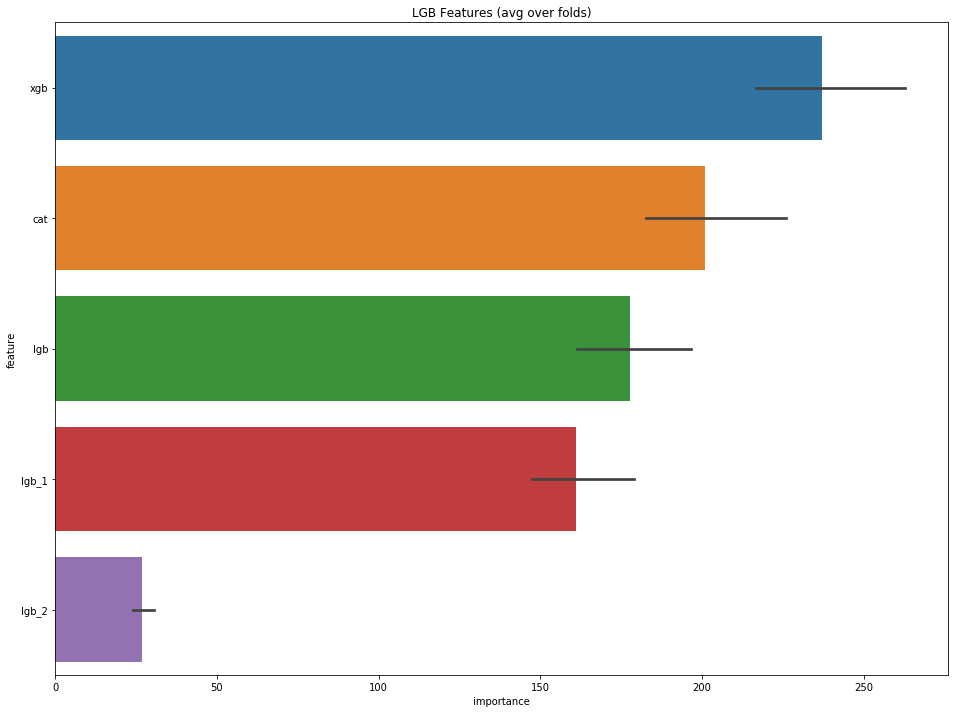

In [118]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:32:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[377]	training's rmse: 2.05051	valid_1's rmse: 2.18167
Fold 1 started at Tue Dec 17 01:32:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[307]	training's rmse: 2.05705	valid_1's rmse: 2.22018
Fold 2 started at Tue Dec 17 01:32:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[263]	training's rmse: 2.09091	valid_1's rmse: 1.98523
Fold 3 started at Tue Dec 17 01:32:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[762]	training's rmse: 2.02953	valid_1's rmse: 2.07788
Fold 4 started at Tue Dec 17 01:32:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[398]	training's rmse: 2.03149	valid_1's rmse: 2.33089
Fold 5 started at Tu

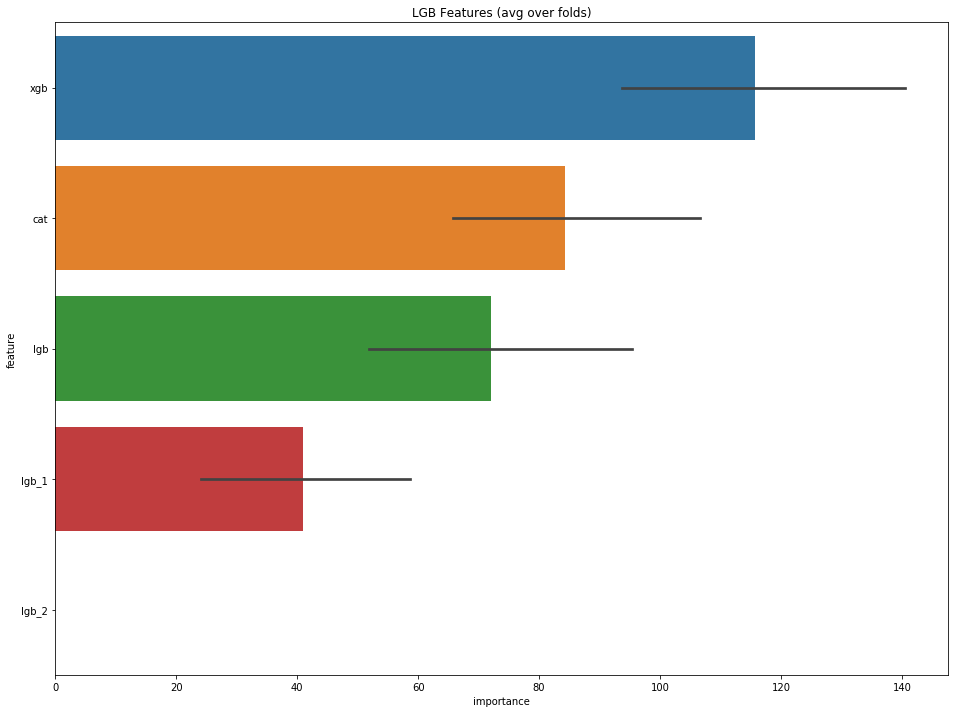

In [119]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [120]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:33:01 2019
Fold 1 started at Tue Dec 17 01:33:15 2019
Fold 2 started at Tue Dec 17 01:33:27 2019
Fold 3 started at Tue Dec 17 01:33:37 2019
Fold 4 started at Tue Dec 17 01:33:53 2019
Fold 5 started at Tue Dec 17 01:34:09 2019
Fold 6 started at Tue Dec 17 01:34:22 2019
Fold 7 started at Tue Dec 17 01:34:58 2019
Fold 8 started at Tue Dec 17 01:35:30 2019
Fold 9 started at Tue Dec 17 01:35:42 2019
CV mean score: 2.1079, std: 0.1410.


##### randomforest作为第二层融合模型

In [121]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:35:51 2019
Fold 1 started at Tue Dec 17 01:35:51 2019
Fold 2 started at Tue Dec 17 01:35:52 2019
Fold 3 started at Tue Dec 17 01:35:52 2019
Fold 4 started at Tue Dec 17 01:35:52 2019
Fold 5 started at Tue Dec 17 01:35:52 2019
Fold 6 started at Tue Dec 17 01:35:53 2019
Fold 7 started at Tue Dec 17 01:35:53 2019
Fold 8 started at Tue Dec 17 01:35:53 2019
Fold 9 started at Tue Dec 17 01:35:53 2019
CV mean score: 2.1664, std: 0.1344.


##### xgboost作为第二层融合模型

In [122]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:35:54 2019
[0]	train-rmse:9.87505	valid_data-rmse:9.86663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.63959	valid_data-rmse:2.2392
Stopping. Best iteration:
[449]	train-rmse:1.67386	valid_data-rmse:2.23613

Fold 1 started at Tue Dec 17 01:35:56 2019
[0]	train-rmse:9.87783	valid_data-rmse:9.84336
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.63739	valid_data-rmse:2.2508
Stopping. Best iteration:
[453]	train-rmse:1.66846	valid_data-rmse:2.24683

Fold 2 started at Tue Dec 17 01:35:59 2019
[0]	train-rmse:9.91011	valid_data-rmse:9.54308
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [123]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:36:20 2019
Fold 1 started at Tue Dec 17 01:36:21 2019
Fold 2 started at Tue Dec 17 01:36:21 2019
Fold 3 started at Tue Dec 17 01:36:22 2019
Fold 4 started at Tue Dec 17 01:36:23 2019
Fold 5 started at Tue Dec 17 01:36:23 2019
Fold 6 started at Tue Dec 17 01:36:24 2019
Fold 7 started at Tue Dec 17 01:36:24 2019
Fold 8 started at Tue Dec 17 01:36:25 2019
Fold 9 started at Tue Dec 17 01:36:26 2019
CV mean score: 2.1614, std: 0.1729.


##### 岭回归做第二层融合模型

In [124]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:36:26 2019
Fold 1 started at Tue Dec 17 01:36:26 2019
Fold 2 started at Tue Dec 17 01:36:26 2019
Fold 3 started at Tue Dec 17 01:36:26 2019
Fold 4 started at Tue Dec 17 01:36:27 2019
Fold 5 started at Tue Dec 17 01:36:27 2019
Fold 6 started at Tue Dec 17 01:36:27 2019
Fold 7 started at Tue Dec 17 01:36:27 2019
Fold 8 started at Tue Dec 17 01:36:27 2019
Fold 9 started at Tue Dec 17 01:36:27 2019
CV mean score: 2.1106, std: 0.1412.


#### 去掉svr和cat

In [125]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:36:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[246]	training's rmse: 1.95565	valid_1's rmse: 2.27519
Fold 1 started at Tue Dec 17 01:36:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 1.95926	valid_1's rmse: 2.23837
Fold 2 started at Tue Dec 17 01:36:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 1.9802	valid_1's rmse: 1.98093
Fold 3 started at Tue Dec 17 01:36:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[228]	training's rmse: 1.98857	valid_1's rmse: 2.12015
Fold 4 started at Tue Dec 17 01:36:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[386]	training's rmse: 1.88497	valid_1's rmse: 2.37672
Fold 5 started at Tue

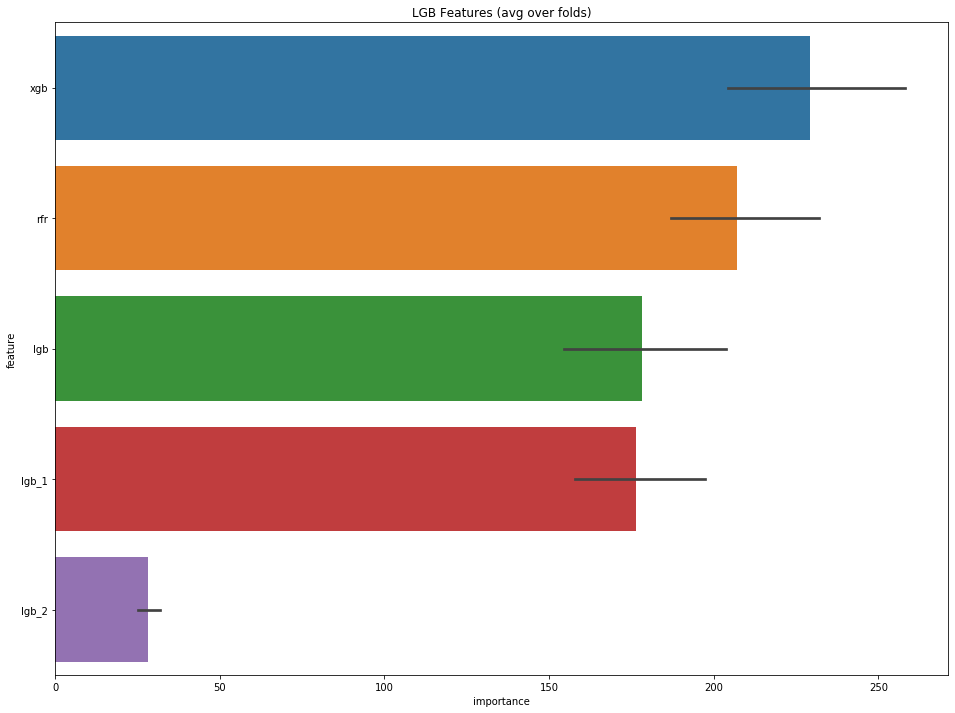

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:37:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 2.0754	valid_1's rmse: 2.20113
Fold 1 started at Tue Dec 17 01:37:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[345]	training's rmse: 2.05333	valid_1's rmse: 2.22838
Fold 2 started at Tue Dec 17 01:37:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[298]	training's rmse: 2.09302	valid_1's rmse: 1.96437
Fold 3 started at Tue Dec 17 01:37:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[555]	training's rmse: 2.04842	valid_1's rmse: 2.10354
Fold 4 started at Tue Dec 17 01:37:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 2.04854	valid_1's rmse: 2.34183
Fold 5 started at Tue

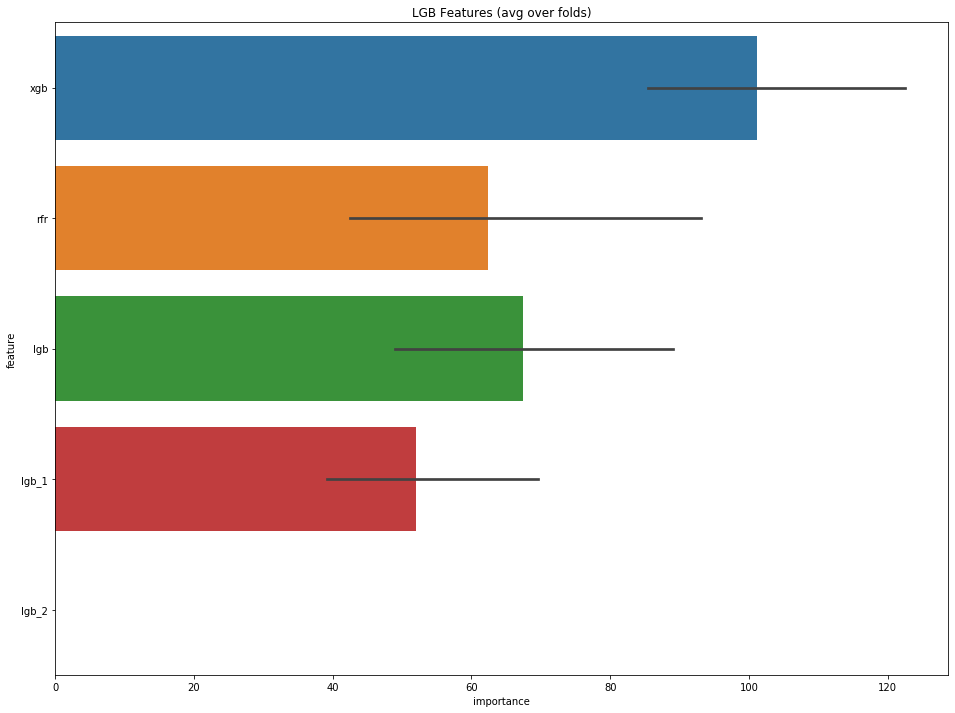

In [127]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [128]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:37:50 2019
Fold 1 started at Tue Dec 17 01:38:05 2019
Fold 2 started at Tue Dec 17 01:38:17 2019
Fold 3 started at Tue Dec 17 01:38:27 2019
Fold 4 started at Tue Dec 17 01:38:41 2019
Fold 5 started at Tue Dec 17 01:38:57 2019
Fold 6 started at Tue Dec 17 01:39:10 2019
Fold 7 started at Tue Dec 17 01:39:36 2019
Fold 8 started at Tue Dec 17 01:40:06 2019
Fold 9 started at Tue Dec 17 01:40:19 2019
CV mean score: 2.1130, std: 0.1471.


##### randomforest作为第二层融合模型

In [129]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:40:28 2019
Fold 1 started at Tue Dec 17 01:40:29 2019
Fold 2 started at Tue Dec 17 01:40:29 2019
Fold 3 started at Tue Dec 17 01:40:29 2019
Fold 4 started at Tue Dec 17 01:40:29 2019
Fold 5 started at Tue Dec 17 01:40:29 2019
Fold 6 started at Tue Dec 17 01:40:30 2019
Fold 7 started at Tue Dec 17 01:40:30 2019
Fold 8 started at Tue Dec 17 01:40:30 2019
Fold 9 started at Tue Dec 17 01:40:30 2019
CV mean score: 2.1879, std: 0.1473.


##### xgboost作为第二层融合模型

In [130]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:40:31 2019
[0]	train-rmse:9.87505	valid_data-rmse:9.86663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.62277	valid_data-rmse:2.29343
Stopping. Best iteration:
[391]	train-rmse:1.70671	valid_data-rmse:2.28017

Fold 1 started at Tue Dec 17 01:40:33 2019
[0]	train-rmse:9.87783	valid_data-rmse:9.84336
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.63381	valid_data-rmse:2.27688
Stopping. Best iteration:
[412]	train-rmse:1.69695	valid_data-rmse:2.27137

Fold 2 started at Tue Dec 17 01:40:36 2019
[0]	train-rmse:9.91012	valid_data-rmse:9.54324
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [131]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:40:58 2019
Fold 1 started at Tue Dec 17 01:40:58 2019
Fold 2 started at Tue Dec 17 01:40:59 2019
Fold 3 started at Tue Dec 17 01:41:00 2019
Fold 4 started at Tue Dec 17 01:41:00 2019
Fold 5 started at Tue Dec 17 01:41:01 2019
Fold 6 started at Tue Dec 17 01:41:01 2019
Fold 7 started at Tue Dec 17 01:41:02 2019
Fold 8 started at Tue Dec 17 01:41:03 2019
Fold 9 started at Tue Dec 17 01:41:03 2019
CV mean score: 2.1600, std: 0.1732.


##### 岭回归做第二层融合模型

In [132]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:41:04 2019
Fold 1 started at Tue Dec 17 01:41:04 2019
Fold 2 started at Tue Dec 17 01:41:04 2019
Fold 3 started at Tue Dec 17 01:41:04 2019
Fold 4 started at Tue Dec 17 01:41:04 2019
Fold 5 started at Tue Dec 17 01:41:04 2019
Fold 6 started at Tue Dec 17 01:41:05 2019
Fold 7 started at Tue Dec 17 01:41:05 2019
Fold 8 started at Tue Dec 17 01:41:05 2019
Fold 9 started at Tue Dec 17 01:41:05 2019
CV mean score: 2.1136, std: 0.1437.


#### 去掉rfr和cat

In [133]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:41:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 1.93204	valid_1's rmse: 2.23536
Fold 1 started at Tue Dec 17 01:41:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[225]	training's rmse: 1.95875	valid_1's rmse: 2.23876
Fold 2 started at Tue Dec 17 01:41:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[221]	training's rmse: 1.98349	valid_1's rmse: 1.99333
Fold 3 started at Tue Dec 17 01:41:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 1.93902	valid_1's rmse: 2.12254
Fold 4 started at Tue Dec 17 01:41:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[362]	training's rmse: 1.87206	valid_1's rmse: 2.36629
Fold 5 started at Tu

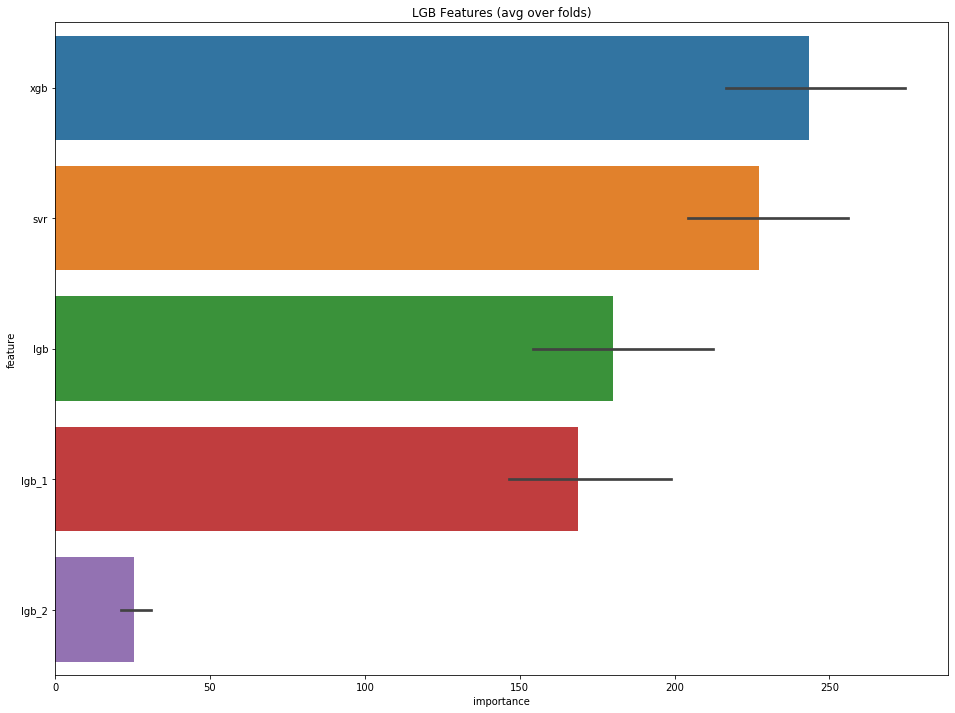

In [134]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:42:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[399]	training's rmse: 2.03668	valid_1's rmse: 2.1856
Fold 1 started at Tue Dec 17 01:42:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[323]	training's rmse: 2.04881	valid_1's rmse: 2.21343
Fold 2 started at Tue Dec 17 01:42:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 2.05866	valid_1's rmse: 1.97057
Fold 3 started at Tue Dec 17 01:42:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.9981	valid_1's rmse: 2.08227
Early stopping, best iteration is:
[1036]	training's rmse: 1.99514	valid_1's rmse: 2.08118
Fold 4 started at Tue Dec 17 01:42:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[432]	training's rms

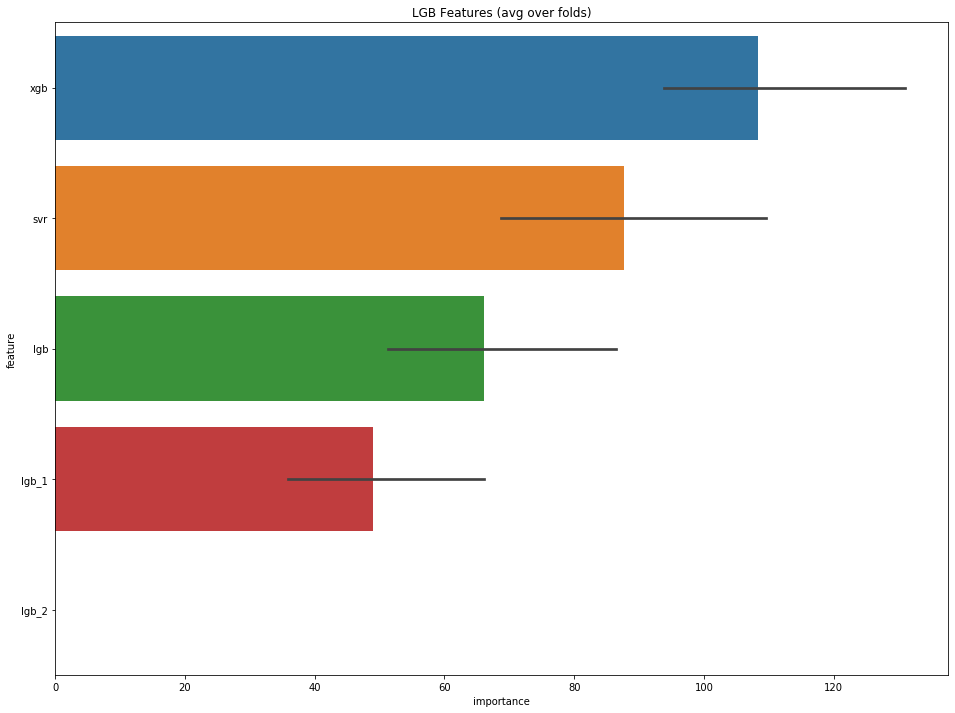

In [135]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [136]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:42:26 2019
Fold 1 started at Tue Dec 17 01:42:36 2019
Fold 2 started at Tue Dec 17 01:42:51 2019
Fold 3 started at Tue Dec 17 01:42:57 2019
Fold 4 started at Tue Dec 17 01:43:06 2019
Fold 5 started at Tue Dec 17 01:43:14 2019
Fold 6 started at Tue Dec 17 01:43:22 2019
Fold 7 started at Tue Dec 17 01:43:47 2019
Fold 8 started at Tue Dec 17 01:43:57 2019
Fold 9 started at Tue Dec 17 01:44:05 2019
CV mean score: 2.1098, std: 0.1408.


##### randomforest作为第二层融合模型

In [137]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:44:11 2019
Fold 1 started at Tue Dec 17 01:44:12 2019
Fold 2 started at Tue Dec 17 01:44:12 2019
Fold 3 started at Tue Dec 17 01:44:12 2019
Fold 4 started at Tue Dec 17 01:44:12 2019
Fold 5 started at Tue Dec 17 01:44:13 2019
Fold 6 started at Tue Dec 17 01:44:13 2019
Fold 7 started at Tue Dec 17 01:44:13 2019
Fold 8 started at Tue Dec 17 01:44:13 2019
Fold 9 started at Tue Dec 17 01:44:14 2019
CV mean score: 2.1568, std: 0.1333.


##### xgboost作为第二层融合模型

In [138]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:44:14 2019
[0]	train-rmse:9.87505	valid_data-rmse:9.86663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.60115	valid_data-rmse:2.25873
Stopping. Best iteration:
[440]	train-rmse:1.64483	valid_data-rmse:2.25406

Fold 1 started at Tue Dec 17 01:44:16 2019
[0]	train-rmse:9.87783	valid_data-rmse:9.84336
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.6099	valid_data-rmse:2.23491
Stopping. Best iteration:
[421]	train-rmse:1.66745	valid_data-rmse:2.23302

Fold 2 started at Tue Dec 17 01:44:19 2019
[0]	train-rmse:9.91012	valid_data-rmse:9.54324
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [139]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:44:37 2019
Fold 1 started at Tue Dec 17 01:44:38 2019
Fold 2 started at Tue Dec 17 01:44:38 2019
Fold 3 started at Tue Dec 17 01:44:39 2019
Fold 4 started at Tue Dec 17 01:44:39 2019
Fold 5 started at Tue Dec 17 01:44:39 2019
Fold 6 started at Tue Dec 17 01:44:40 2019
Fold 7 started at Tue Dec 17 01:44:41 2019
Fold 8 started at Tue Dec 17 01:44:41 2019
Fold 9 started at Tue Dec 17 01:44:42 2019
CV mean score: 2.1704, std: 0.1769.


##### 岭回归做第二层融合模型

In [140]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:44:42 2019
Fold 1 started at Tue Dec 17 01:44:42 2019
Fold 2 started at Tue Dec 17 01:44:43 2019
Fold 3 started at Tue Dec 17 01:44:43 2019
Fold 4 started at Tue Dec 17 01:44:43 2019
Fold 5 started at Tue Dec 17 01:44:43 2019
Fold 6 started at Tue Dec 17 01:44:43 2019
Fold 7 started at Tue Dec 17 01:44:43 2019
Fold 8 started at Tue Dec 17 01:44:43 2019
Fold 9 started at Tue Dec 17 01:44:43 2019
CV mean score: 2.1104, std: 0.1408.


#### 留下cat和rfr

In [141]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:44:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[352]	training's rmse: 2.04883	valid_1's rmse: 2.19826
Fold 1 started at Tue Dec 17 01:44:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[242]	training's rmse: 2.06215	valid_1's rmse: 2.23516
Fold 2 started at Tue Dec 17 01:44:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[213]	training's rmse: 2.10296	valid_1's rmse: 2.02355
Fold 3 started at Tue Dec 17 01:44:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[275]	training's rmse: 2.07783	valid_1's rmse: 2.06993
Fold 4 started at Tue Dec 17 01:44:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[382]	training's rmse: 2.01747	valid_1's rmse: 2.42153
Fold 5 started at Tu

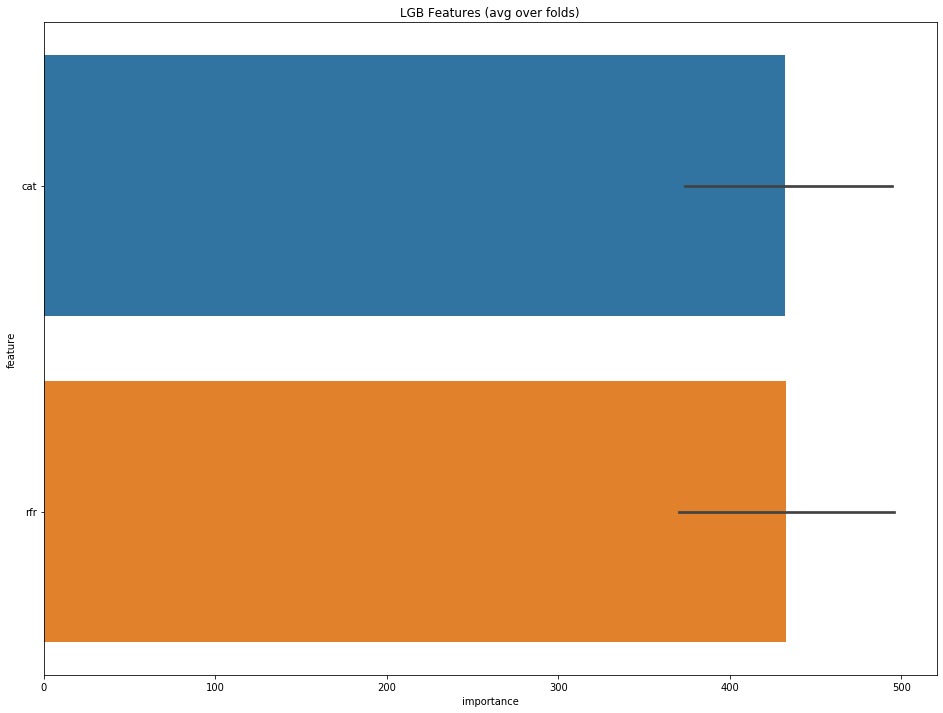

In [142]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:45:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 2.0868	valid_1's rmse: 2.18051
Fold 1 started at Tue Dec 17 01:45:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 2.08694	valid_1's rmse: 2.21553
Fold 2 started at Tue Dec 17 01:45:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[259]	training's rmse: 2.11913	valid_1's rmse: 2.02859
Fold 3 started at Tue Dec 17 01:45:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 2.11003	valid_1's rmse: 2.07233
Fold 4 started at Tue Dec 17 01:45:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[442]	training's rmse: 2.06397	valid_1's rmse: 2.35712
Fold 5 started at Tue

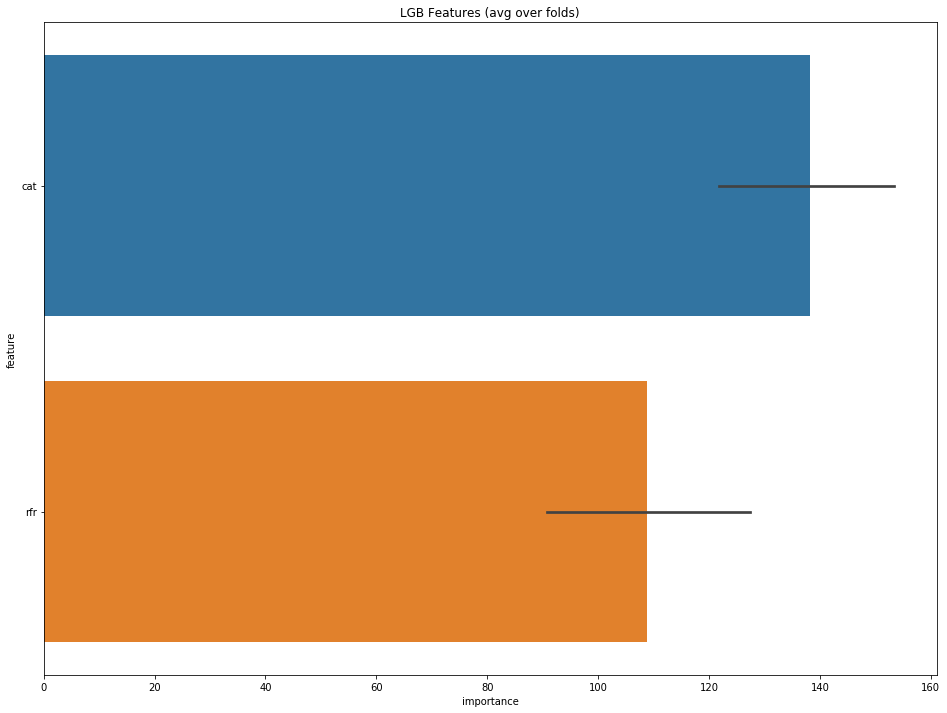

In [143]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [144]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:45:16 2019
Fold 1 started at Tue Dec 17 01:45:30 2019
Fold 2 started at Tue Dec 17 01:45:36 2019
Fold 3 started at Tue Dec 17 01:45:41 2019
Fold 4 started at Tue Dec 17 01:45:50 2019
Fold 5 started at Tue Dec 17 01:46:01 2019
Fold 6 started at Tue Dec 17 01:46:08 2019
Fold 7 started at Tue Dec 17 01:46:18 2019
Fold 8 started at Tue Dec 17 01:46:28 2019
Fold 9 started at Tue Dec 17 01:46:35 2019
CV mean score: 2.1311, std: 0.1470.


##### randomforest作为第二层融合模型

In [145]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:46:40 2019
Fold 1 started at Tue Dec 17 01:46:40 2019
Fold 2 started at Tue Dec 17 01:46:40 2019
Fold 3 started at Tue Dec 17 01:46:41 2019
Fold 4 started at Tue Dec 17 01:46:41 2019
Fold 5 started at Tue Dec 17 01:46:41 2019
Fold 6 started at Tue Dec 17 01:46:41 2019
Fold 7 started at Tue Dec 17 01:46:42 2019
Fold 8 started at Tue Dec 17 01:46:42 2019
Fold 9 started at Tue Dec 17 01:46:42 2019
CV mean score: 2.2220, std: 0.1425.


##### xgboost作为第二层融合模型

In [146]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:46:42 2019
[0]	train-rmse:9.87527	valid_data-rmse:9.86704
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.82457	valid_data-rmse:2.17652
Stopping. Best iteration:
[477]	train-rmse:1.83563	valid_data-rmse:2.17503

Fold 1 started at Tue Dec 17 01:46:44 2019
[0]	train-rmse:9.87797	valid_data-rmse:9.84367
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.81354	valid_data-rmse:2.25981
Stopping. Best iteration:
[430]	train-rmse:1.85006	valid_data-rmse:2.25544

Fold 2 started at Tue Dec 17 01:46:45 2019
[0]	train-rmse:9.91036	valid_data-rmse:9.54293
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [147]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:46:54 2019
Fold 1 started at Tue Dec 17 01:46:54 2019
Fold 2 started at Tue Dec 17 01:46:54 2019
Fold 3 started at Tue Dec 17 01:46:55 2019
Fold 4 started at Tue Dec 17 01:46:55 2019
Fold 5 started at Tue Dec 17 01:46:55 2019
Fold 6 started at Tue Dec 17 01:46:56 2019
Fold 7 started at Tue Dec 17 01:46:56 2019
Fold 8 started at Tue Dec 17 01:46:56 2019
Fold 9 started at Tue Dec 17 01:46:57 2019
CV mean score: 2.1909, std: 0.1654.


##### 岭回归做第二层融合模型

In [148]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:46:57 2019
Fold 1 started at Tue Dec 17 01:46:58 2019
Fold 2 started at Tue Dec 17 01:46:58 2019
Fold 3 started at Tue Dec 17 01:46:58 2019
Fold 4 started at Tue Dec 17 01:46:58 2019
Fold 5 started at Tue Dec 17 01:46:58 2019
Fold 6 started at Tue Dec 17 01:46:58 2019
Fold 7 started at Tue Dec 17 01:46:58 2019
Fold 8 started at Tue Dec 17 01:46:58 2019
Fold 9 started at Tue Dec 17 01:46:58 2019
CV mean score: 2.1285, std: 0.1411.


#### 留下cat和svr

In [149]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:46:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.0692	valid_1's rmse: 2.22873
Fold 1 started at Tue Dec 17 01:47:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 2.07976	valid_1's rmse: 2.21902
Fold 2 started at Tue Dec 17 01:47:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 2.1222	valid_1's rmse: 2.08851
Fold 3 started at Tue Dec 17 01:47:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.10075	valid_1's rmse: 2.11944
Fold 4 started at Tue Dec 17 01:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[532]	training's rmse: 2.03333	valid_1's rmse: 2.40974
Fold 5 started at Tue 

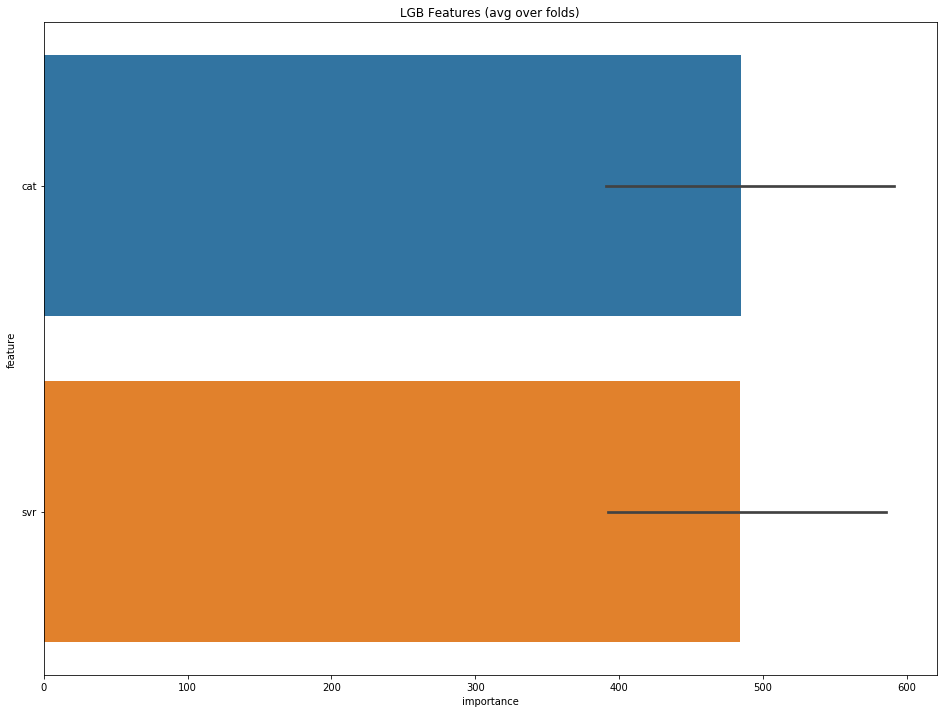

In [150]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:47:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 2.07452	valid_1's rmse: 2.19251
Fold 1 started at Tue Dec 17 01:47:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[516]	training's rmse: 2.06478	valid_1's rmse: 2.20044
Fold 2 started at Tue Dec 17 01:47:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[234]	training's rmse: 2.12262	valid_1's rmse: 2.04358
Fold 3 started at Tue Dec 17 01:47:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.04476	valid_1's rmse: 2.07459
Early stopping, best iteration is:
[1323]	training's rmse: 2.03115	valid_1's rmse: 2.06853
Fold 4 started at Tue Dec 17 01:47:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[387]	training's r

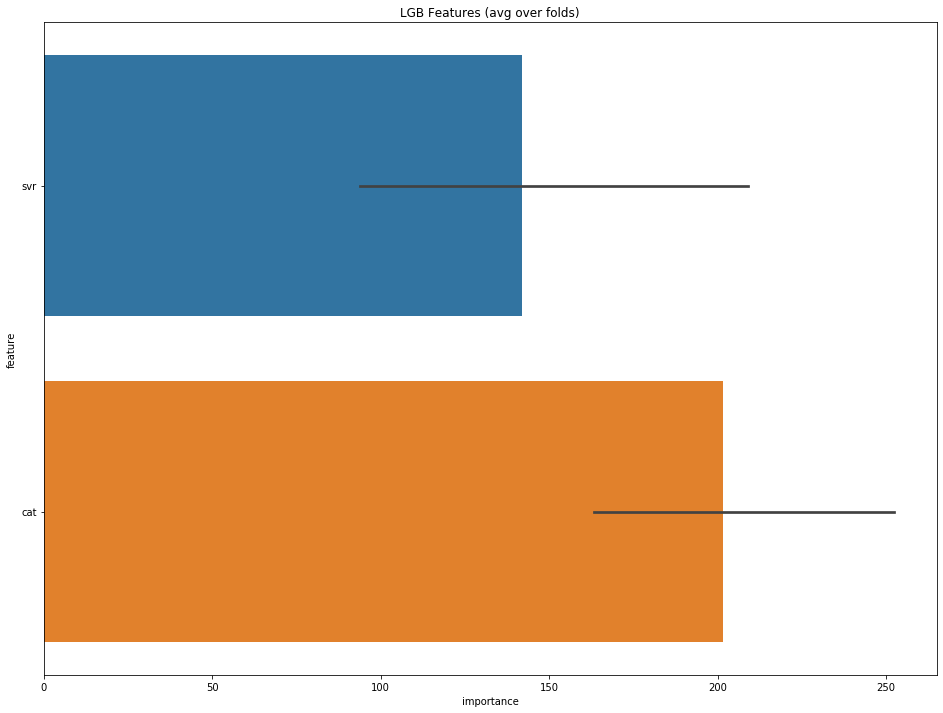

In [151]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [152]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:47:35 2019
Fold 1 started at Tue Dec 17 01:47:48 2019
Fold 2 started at Tue Dec 17 01:47:57 2019
Fold 3 started at Tue Dec 17 01:48:02 2019
Fold 4 started at Tue Dec 17 01:48:15 2019
Fold 5 started at Tue Dec 17 01:48:25 2019
Fold 6 started at Tue Dec 17 01:48:40 2019
Fold 7 started at Tue Dec 17 01:48:49 2019
Fold 8 started at Tue Dec 17 01:48:59 2019
Fold 9 started at Tue Dec 17 01:49:07 2019
CV mean score: 2.1362, std: 0.1400.


##### randomforest作为第二层融合模型

In [153]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:49:14 2019
Fold 1 started at Tue Dec 17 01:49:14 2019
Fold 2 started at Tue Dec 17 01:49:14 2019
Fold 3 started at Tue Dec 17 01:49:14 2019
Fold 4 started at Tue Dec 17 01:49:15 2019
Fold 5 started at Tue Dec 17 01:49:15 2019
Fold 6 started at Tue Dec 17 01:49:15 2019
Fold 7 started at Tue Dec 17 01:49:15 2019
Fold 8 started at Tue Dec 17 01:49:16 2019
Fold 9 started at Tue Dec 17 01:49:16 2019
CV mean score: 2.2032, std: 0.1367.


##### xgboost作为第二层融合模型

In [154]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:49:16 2019
[0]	train-rmse:9.87527	valid_data-rmse:9.86704
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.8532	valid_data-rmse:2.25201
Stopping. Best iteration:
[429]	train-rmse:1.8929	valid_data-rmse:2.24252

Fold 1 started at Tue Dec 17 01:49:17 2019
[0]	train-rmse:9.87797	valid_data-rmse:9.84367
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.8506	valid_data-rmse:2.22426
Stopping. Best iteration:
[432]	train-rmse:1.88965	valid_data-rmse:2.22191

Fold 2 started at Tue Dec 17 01:49:18 2019
[0]	train-rmse:9.91036	valid_data-rmse:9.54293
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [155]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:49:27 2019
Fold 1 started at Tue Dec 17 01:49:28 2019
Fold 2 started at Tue Dec 17 01:49:28 2019
Fold 3 started at Tue Dec 17 01:49:29 2019
Fold 4 started at Tue Dec 17 01:49:29 2019
Fold 5 started at Tue Dec 17 01:49:30 2019
Fold 6 started at Tue Dec 17 01:49:30 2019
Fold 7 started at Tue Dec 17 01:49:31 2019
Fold 8 started at Tue Dec 17 01:49:31 2019
Fold 9 started at Tue Dec 17 01:49:32 2019
CV mean score: 2.1805, std: 0.1652.


##### 岭回归做第二层融合模型

In [156]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:49:32 2019
Fold 1 started at Tue Dec 17 01:49:32 2019
Fold 2 started at Tue Dec 17 01:49:33 2019
Fold 3 started at Tue Dec 17 01:49:33 2019
Fold 4 started at Tue Dec 17 01:49:33 2019
Fold 5 started at Tue Dec 17 01:49:33 2019
Fold 6 started at Tue Dec 17 01:49:33 2019
Fold 7 started at Tue Dec 17 01:49:33 2019
Fold 8 started at Tue Dec 17 01:49:33 2019
Fold 9 started at Tue Dec 17 01:49:33 2019
CV mean score: 2.1320, std: 0.1397.


#### 留下rfr和svr

In [157]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:49:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's rmse: 2.08453	valid_1's rmse: 2.27302
Fold 1 started at Tue Dec 17 01:49:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 2.09049	valid_1's rmse: 2.23373
Fold 2 started at Tue Dec 17 01:49:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 2.13282	valid_1's rmse: 2.06508
Fold 3 started at Tue Dec 17 01:49:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[278]	training's rmse: 2.11276	valid_1's rmse: 2.0774
Fold 4 started at Tue Dec 17 01:49:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[377]	training's rmse: 2.04955	valid_1's rmse: 2.49696
Fold 5 started at Tue

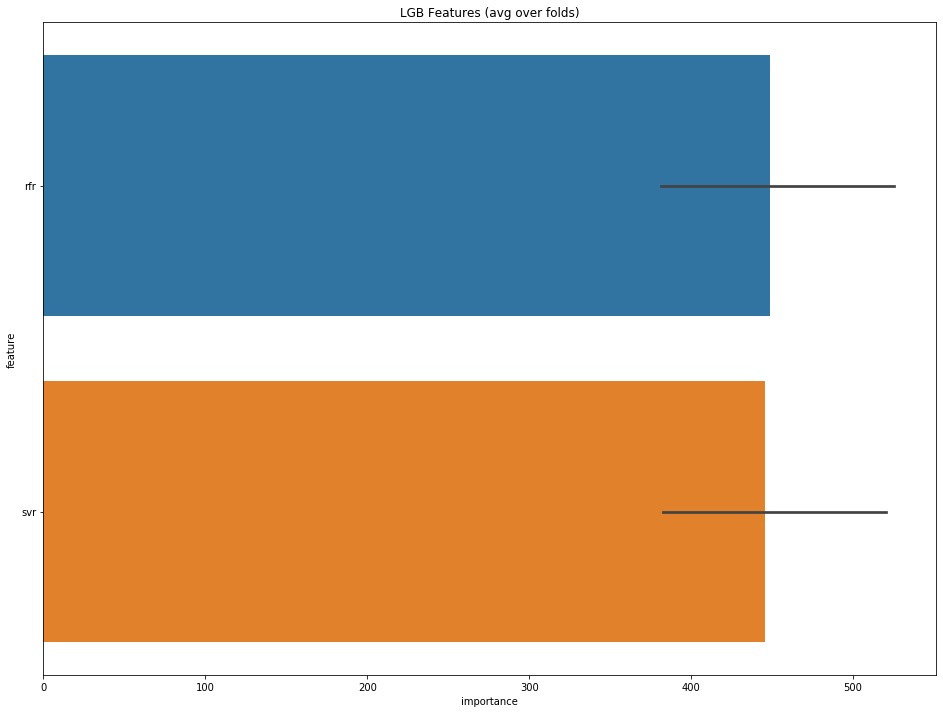

In [158]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:49:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[362]	training's rmse: 2.10547	valid_1's rmse: 2.21153
Fold 1 started at Tue Dec 17 01:49:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[320]	training's rmse: 2.11383	valid_1's rmse: 2.20155
Fold 2 started at Tue Dec 17 01:49:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[228]	training's rmse: 2.15404	valid_1's rmse: 2.0177
Fold 3 started at Tue Dec 17 01:49:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[710]	training's rmse: 2.09366	valid_1's rmse: 2.08209
Fold 4 started at Tue Dec 17 01:49:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[416]	training's rmse: 2.07238	valid_1's rmse: 2.45217
Fold 5 started at Tue

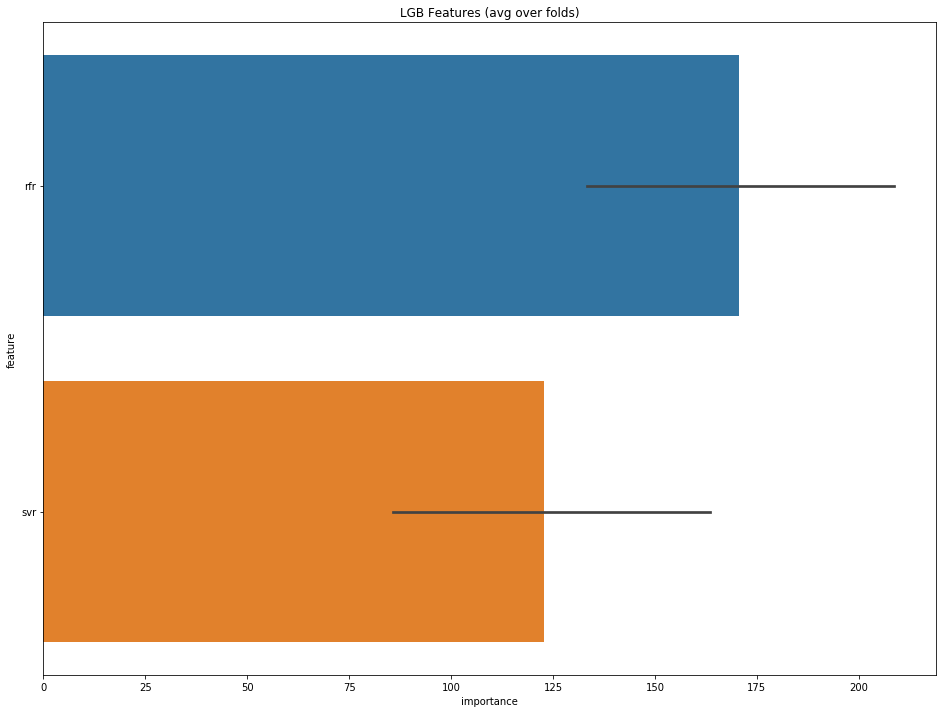

In [159]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [160]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:49:41 2019
Fold 1 started at Tue Dec 17 01:49:51 2019
Fold 2 started at Tue Dec 17 01:49:57 2019
Fold 3 started at Tue Dec 17 01:50:03 2019
Fold 4 started at Tue Dec 17 01:50:18 2019
Fold 5 started at Tue Dec 17 01:50:28 2019
Fold 6 started at Tue Dec 17 01:50:46 2019
Fold 7 started at Tue Dec 17 01:51:02 2019
Fold 8 started at Tue Dec 17 01:51:09 2019
Fold 9 started at Tue Dec 17 01:51:20 2019
CV mean score: 2.1557, std: 0.1506.


##### randomforest作为第二层融合模型

In [161]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:51:25 2019
Fold 1 started at Tue Dec 17 01:51:25 2019
Fold 2 started at Tue Dec 17 01:51:26 2019
Fold 3 started at Tue Dec 17 01:51:26 2019
Fold 4 started at Tue Dec 17 01:51:26 2019
Fold 5 started at Tue Dec 17 01:51:26 2019
Fold 6 started at Tue Dec 17 01:51:27 2019
Fold 7 started at Tue Dec 17 01:51:27 2019
Fold 8 started at Tue Dec 17 01:51:27 2019
Fold 9 started at Tue Dec 17 01:51:27 2019
CV mean score: 2.2152, std: 0.1555.


##### xgboost作为第二层融合模型

In [162]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:51:28 2019
[0]	train-rmse:9.87577	valid_data-rmse:9.86758
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.85314	valid_data-rmse:2.27436
Stopping. Best iteration:
[414]	train-rmse:1.90359	valid_data-rmse:2.26918

Fold 1 started at Tue Dec 17 01:51:29 2019
[0]	train-rmse:9.87861	valid_data-rmse:9.84468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.85904	valid_data-rmse:2.2306
Stopping. Best iteration:
[488]	train-rmse:1.86563	valid_data-rmse:2.2294

Fold 2 started at Tue Dec 17 01:51:30 2019
[0]	train-rmse:9.91102	valid_data-rmse:9.54362
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [163]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:51:39 2019
Fold 1 started at Tue Dec 17 01:51:39 2019
Fold 2 started at Tue Dec 17 01:51:40 2019
Fold 3 started at Tue Dec 17 01:51:40 2019
Fold 4 started at Tue Dec 17 01:51:40 2019
Fold 5 started at Tue Dec 17 01:51:41 2019
Fold 6 started at Tue Dec 17 01:51:41 2019
Fold 7 started at Tue Dec 17 01:51:41 2019
Fold 8 started at Tue Dec 17 01:51:42 2019
Fold 9 started at Tue Dec 17 01:51:42 2019
CV mean score: 2.2065, std: 0.1889.


##### 岭回归做第二层融合模型

In [164]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:51:42 2019
Fold 1 started at Tue Dec 17 01:51:43 2019
Fold 2 started at Tue Dec 17 01:51:43 2019
Fold 3 started at Tue Dec 17 01:51:43 2019
Fold 4 started at Tue Dec 17 01:51:43 2019
Fold 5 started at Tue Dec 17 01:51:43 2019
Fold 6 started at Tue Dec 17 01:51:43 2019
Fold 7 started at Tue Dec 17 01:51:43 2019
Fold 8 started at Tue Dec 17 01:51:43 2019
Fold 9 started at Tue Dec 17 01:51:43 2019
CV mean score: 2.1603, std: 0.1461.


#### 留下xgb和cat

In [165]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:51:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.02523	valid_1's rmse: 2.19983
Fold 1 started at Tue Dec 17 01:51:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 2.04597	valid_1's rmse: 2.23495
Fold 2 started at Tue Dec 17 01:51:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[253]	training's rmse: 2.06672	valid_1's rmse: 1.98377
Fold 3 started at Tue Dec 17 01:51:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 2.05081	valid_1's rmse: 2.10152
Fold 4 started at Tue Dec 17 01:51:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[430]	training's rmse: 1.99648	valid_1's rmse: 2.35425
Fold 5 started at Tu

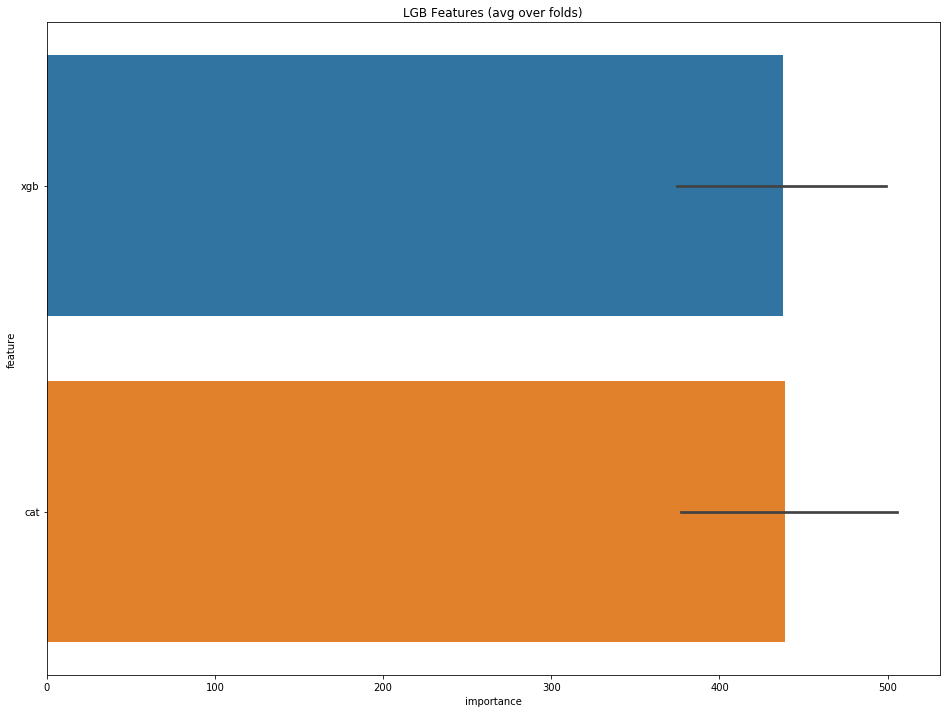

In [166]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:52:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[459]	training's rmse: 2.05304	valid_1's rmse: 2.1857
Fold 1 started at Tue Dec 17 01:52:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[400]	training's rmse: 2.05436	valid_1's rmse: 2.20671
Fold 2 started at Tue Dec 17 01:52:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 2.09889	valid_1's rmse: 1.98286
Fold 3 started at Tue Dec 17 01:52:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[524]	training's rmse: 2.0612	valid_1's rmse: 2.07471
Fold 4 started at Tue Dec 17 01:52:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[443]	training's rmse: 2.03933	valid_1's rmse: 2.32701
Fold 5 started at Tue 

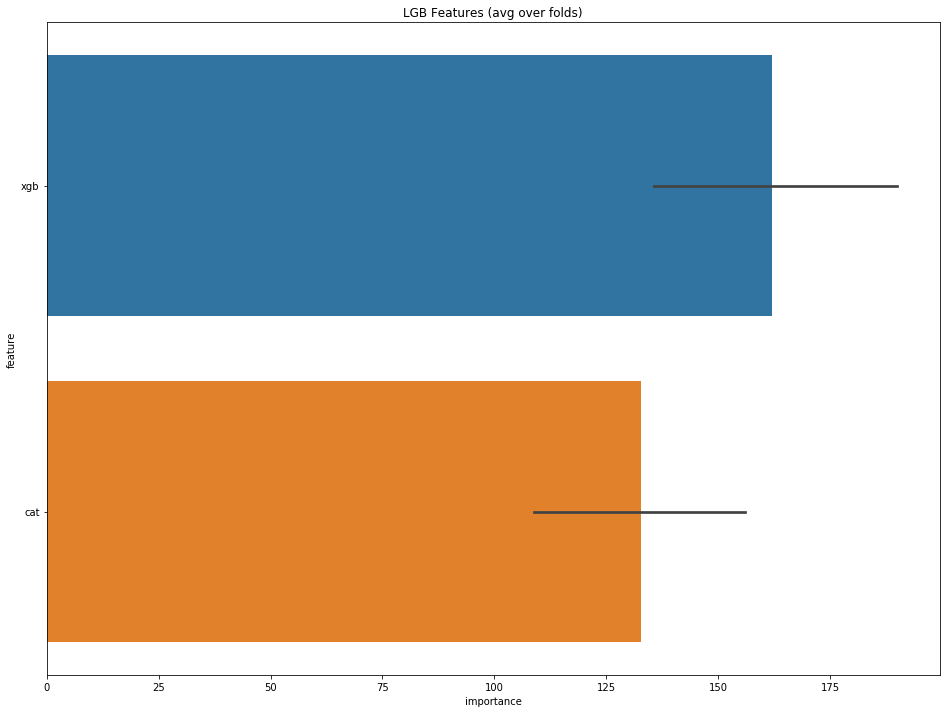

In [167]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [168]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:52:16 2019
Fold 1 started at Tue Dec 17 01:52:28 2019
Fold 2 started at Tue Dec 17 01:52:34 2019
Fold 3 started at Tue Dec 17 01:52:39 2019
Fold 4 started at Tue Dec 17 01:52:47 2019
Fold 5 started at Tue Dec 17 01:52:56 2019
Fold 6 started at Tue Dec 17 01:53:03 2019
Fold 7 started at Tue Dec 17 01:53:15 2019
Fold 8 started at Tue Dec 17 01:53:24 2019
Fold 9 started at Tue Dec 17 01:53:33 2019
CV mean score: 2.1101, std: 0.1468.


##### randomforest作为第二层融合模型

In [169]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:53:40 2019
Fold 1 started at Tue Dec 17 01:53:41 2019
Fold 2 started at Tue Dec 17 01:53:41 2019
Fold 3 started at Tue Dec 17 01:53:41 2019
Fold 4 started at Tue Dec 17 01:53:41 2019
Fold 5 started at Tue Dec 17 01:53:42 2019
Fold 6 started at Tue Dec 17 01:53:42 2019
Fold 7 started at Tue Dec 17 01:53:42 2019
Fold 8 started at Tue Dec 17 01:53:42 2019
Fold 9 started at Tue Dec 17 01:53:43 2019
CV mean score: 2.2058, std: 0.1366.


##### xgboost作为第二层融合模型

In [170]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:53:43 2019
[0]	train-rmse:9.87511	valid_data-rmse:9.86688
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.80061	valid_data-rmse:2.21636
Stopping. Best iteration:
[397]	train-rmse:1.86035	valid_data-rmse:2.20939

Fold 1 started at Tue Dec 17 01:53:44 2019
[0]	train-rmse:9.87783	valid_data-rmse:9.84385
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.79808	valid_data-rmse:2.2586
Stopping. Best iteration:
[409]	train-rmse:1.84798	valid_data-rmse:2.25383

Fold 2 started at Tue Dec 17 01:53:45 2019
[0]	train-rmse:9.91019	valid_data-rmse:9.54369
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [171]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:53:54 2019
Fold 1 started at Tue Dec 17 01:53:54 2019
Fold 2 started at Tue Dec 17 01:53:55 2019
Fold 3 started at Tue Dec 17 01:53:55 2019
Fold 4 started at Tue Dec 17 01:53:56 2019
Fold 5 started at Tue Dec 17 01:53:56 2019
Fold 6 started at Tue Dec 17 01:53:57 2019
Fold 7 started at Tue Dec 17 01:53:57 2019
Fold 8 started at Tue Dec 17 01:53:58 2019
Fold 9 started at Tue Dec 17 01:53:58 2019
CV mean score: 2.1709, std: 0.1738.


##### 岭回归做第二层融合模型

In [172]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:53:59 2019
Fold 1 started at Tue Dec 17 01:53:59 2019
Fold 2 started at Tue Dec 17 01:53:59 2019
Fold 3 started at Tue Dec 17 01:53:59 2019
Fold 4 started at Tue Dec 17 01:53:59 2019
Fold 5 started at Tue Dec 17 01:53:59 2019
Fold 6 started at Tue Dec 17 01:54:00 2019
Fold 7 started at Tue Dec 17 01:54:00 2019
Fold 8 started at Tue Dec 17 01:54:00 2019
Fold 9 started at Tue Dec 17 01:54:00 2019
CV mean score: 2.1115, std: 0.1427.


#### 留下xgb和rfr

In [173]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:54:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.04263	valid_1's rmse: 2.21942
Fold 1 started at Tue Dec 17 01:54:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 2.06189	valid_1's rmse: 2.26199
Fold 2 started at Tue Dec 17 01:54:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[248]	training's rmse: 2.08856	valid_1's rmse: 1.98267
Fold 3 started at Tue Dec 17 01:54:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.07204	valid_1's rmse: 2.08665
Fold 4 started at Tue Dec 17 01:54:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[396]	training's rmse: 2.01582	valid_1's rmse: 2.40751
Fold 5 started at Tu

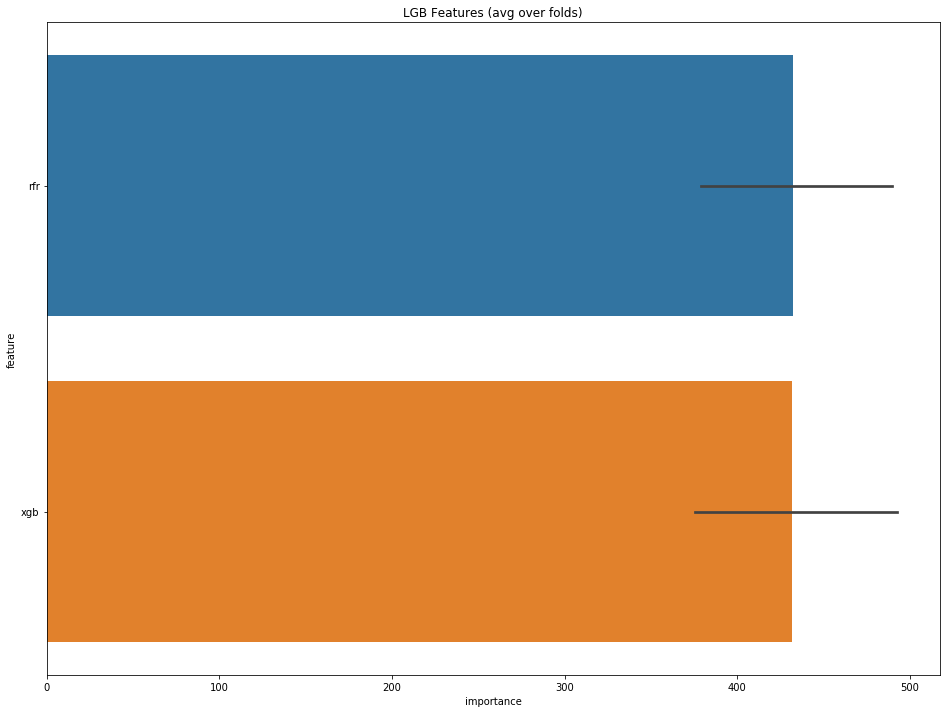

In [174]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:54:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[355]	training's rmse: 2.07851	valid_1's rmse: 2.20329
Fold 1 started at Tue Dec 17 01:54:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 2.0818	valid_1's rmse: 2.23381
Fold 2 started at Tue Dec 17 01:54:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 2.11334	valid_1's rmse: 1.95881
Fold 3 started at Tue Dec 17 01:54:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.10045	valid_1's rmse: 2.11318
Fold 4 started at Tue Dec 17 01:54:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[611]	training's rmse: 2.04572	valid_1's rmse: 2.33645
Fold 5 started at Tue

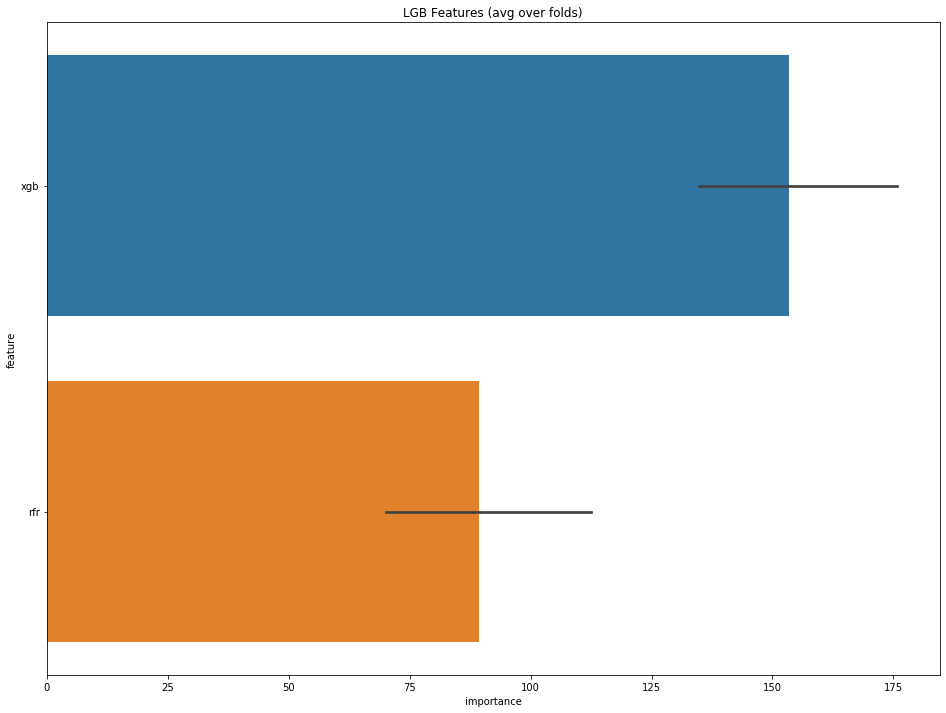

In [175]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [176]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:54:07 2019
Fold 1 started at Tue Dec 17 01:54:15 2019
Fold 2 started at Tue Dec 17 01:54:20 2019
Fold 3 started at Tue Dec 17 01:54:25 2019
Fold 4 started at Tue Dec 17 01:54:31 2019
Fold 5 started at Tue Dec 17 01:54:42 2019
Fold 6 started at Tue Dec 17 01:54:50 2019
Fold 7 started at Tue Dec 17 01:55:00 2019
Fold 8 started at Tue Dec 17 01:55:09 2019
Fold 9 started at Tue Dec 17 01:55:13 2019
CV mean score: 2.1209, std: 0.1563.


##### randomforest作为第二层融合模型

In [177]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:55:20 2019
Fold 1 started at Tue Dec 17 01:55:21 2019
Fold 2 started at Tue Dec 17 01:55:21 2019
Fold 3 started at Tue Dec 17 01:55:21 2019
Fold 4 started at Tue Dec 17 01:55:21 2019
Fold 5 started at Tue Dec 17 01:55:22 2019
Fold 6 started at Tue Dec 17 01:55:22 2019
Fold 7 started at Tue Dec 17 01:55:22 2019
Fold 8 started at Tue Dec 17 01:55:22 2019
Fold 9 started at Tue Dec 17 01:55:23 2019
CV mean score: 2.2158, std: 0.1585.


##### xgboost作为第二层融合模型

In [178]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:55:23 2019
[0]	train-rmse:9.87511	valid_data-rmse:9.86688
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.81452	valid_data-rmse:2.21199
Stopping. Best iteration:
[508]	train-rmse:1.81044	valid_data-rmse:2.2114

Fold 1 started at Tue Dec 17 01:55:24 2019
[0]	train-rmse:9.87783	valid_data-rmse:9.84385
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.80519	valid_data-rmse:2.27179
Stopping. Best iteration:
[466]	train-rmse:1.8235	valid_data-rmse:2.27128

Fold 2 started at Tue Dec 17 01:55:25 2019
[0]	train-rmse:9.91019	valid_data-rmse:9.54369
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [179]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:55:35 2019
Fold 1 started at Tue Dec 17 01:55:36 2019
Fold 2 started at Tue Dec 17 01:55:36 2019
Fold 3 started at Tue Dec 17 01:55:37 2019
Fold 4 started at Tue Dec 17 01:55:37 2019
Fold 5 started at Tue Dec 17 01:55:38 2019
Fold 6 started at Tue Dec 17 01:55:38 2019
Fold 7 started at Tue Dec 17 01:55:39 2019
Fold 8 started at Tue Dec 17 01:55:40 2019
Fold 9 started at Tue Dec 17 01:55:40 2019
CV mean score: 2.1688, std: 0.1762.


##### 岭回归做第二层融合模型

In [180]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:55:41 2019
Fold 1 started at Tue Dec 17 01:55:41 2019
Fold 2 started at Tue Dec 17 01:55:41 2019
Fold 3 started at Tue Dec 17 01:55:41 2019
Fold 4 started at Tue Dec 17 01:55:41 2019
Fold 5 started at Tue Dec 17 01:55:41 2019
Fold 6 started at Tue Dec 17 01:55:41 2019
Fold 7 started at Tue Dec 17 01:55:41 2019
Fold 8 started at Tue Dec 17 01:55:41 2019
Fold 9 started at Tue Dec 17 01:55:41 2019
CV mean score: 2.1188, std: 0.1473.


#### 留下xgb和svr

In [181]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:55:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.03837	valid_1's rmse: 2.23832
Fold 1 started at Tue Dec 17 01:55:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.05917	valid_1's rmse: 2.2271
Fold 2 started at Tue Dec 17 01:55:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.08878	valid_1's rmse: 2.0247
Fold 3 started at Tue Dec 17 01:55:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 2.07881	valid_1's rmse: 2.11563
Fold 4 started at Tue Dec 17 01:55:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[410]	training's rmse: 2.0185	valid_1's rmse: 2.38886
Fold 5 started at Tue D

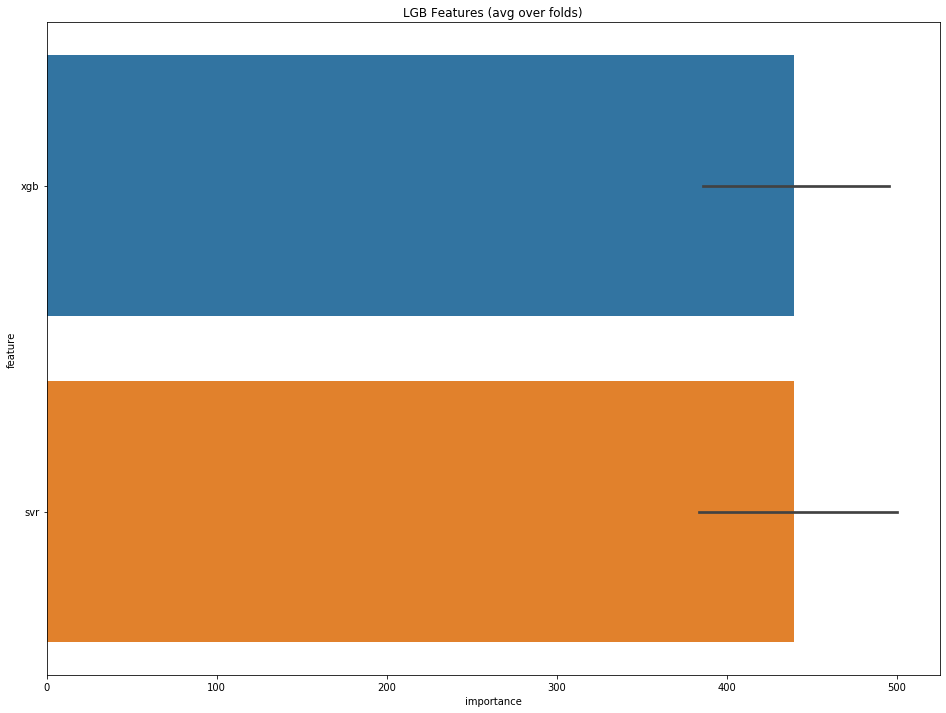

In [182]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:55:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[436]	training's rmse: 2.05005	valid_1's rmse: 2.18603
Fold 1 started at Tue Dec 17 01:55:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[385]	training's rmse: 2.05368	valid_1's rmse: 2.1957
Fold 2 started at Tue Dec 17 01:55:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[244]	training's rmse: 2.09999	valid_1's rmse: 1.96593
Fold 3 started at Tue Dec 17 01:55:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.06459	valid_1's rmse: 2.10683
Fold 4 started at Tue Dec 17 01:55:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 2.03152	valid_1's rmse: 2.33892
Fold 5 started at Tue

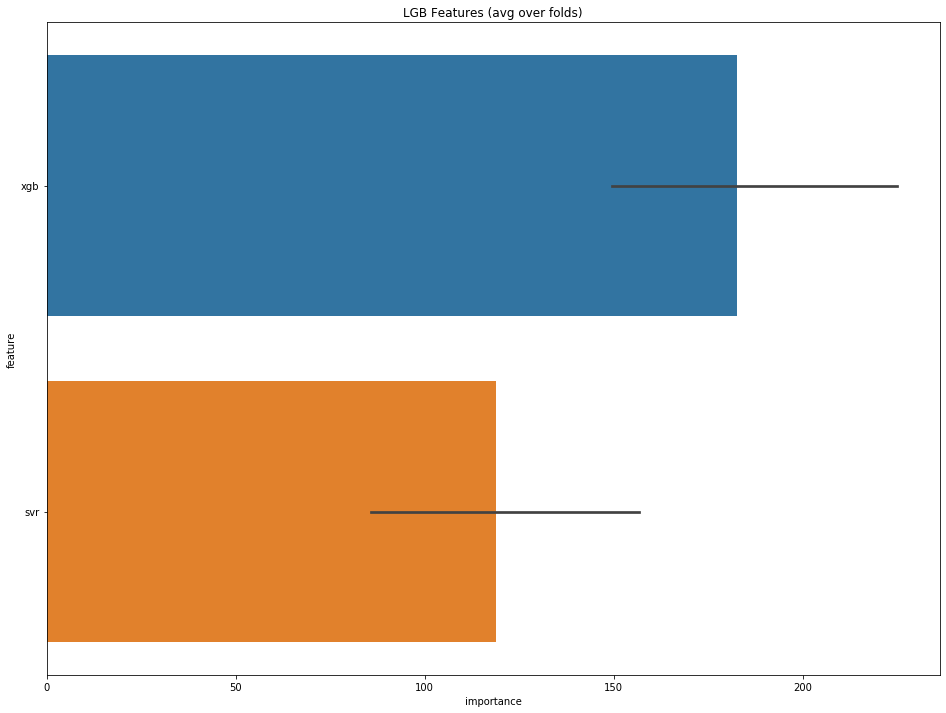

In [183]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [184]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:55:52 2019
Fold 1 started at Tue Dec 17 01:56:00 2019
Fold 2 started at Tue Dec 17 01:56:07 2019
Fold 3 started at Tue Dec 17 01:56:12 2019
Fold 4 started at Tue Dec 17 01:56:19 2019
Fold 5 started at Tue Dec 17 01:56:27 2019
Fold 6 started at Tue Dec 17 01:56:36 2019
Fold 7 started at Tue Dec 17 01:56:54 2019
Fold 8 started at Tue Dec 17 01:57:00 2019
Fold 9 started at Tue Dec 17 01:57:15 2019
CV mean score: 2.1120, std: 0.1480.


##### randomforest作为第二层融合模型

In [185]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:57:24 2019
Fold 1 started at Tue Dec 17 01:57:24 2019
Fold 2 started at Tue Dec 17 01:57:25 2019
Fold 3 started at Tue Dec 17 01:57:25 2019
Fold 4 started at Tue Dec 17 01:57:25 2019
Fold 5 started at Tue Dec 17 01:57:25 2019
Fold 6 started at Tue Dec 17 01:57:25 2019
Fold 7 started at Tue Dec 17 01:57:26 2019
Fold 8 started at Tue Dec 17 01:57:26 2019
Fold 9 started at Tue Dec 17 01:57:26 2019
CV mean score: 2.1740, std: 0.1602.


##### xgboost作为第二层融合模型

In [186]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:57:26 2019
[0]	train-rmse:9.87511	valid_data-rmse:9.86688
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.82184	valid_data-rmse:2.27951
Stopping. Best iteration:
[434]	train-rmse:1.85461	valid_data-rmse:2.27278

Fold 1 started at Tue Dec 17 01:57:28 2019
[0]	train-rmse:9.87783	valid_data-rmse:9.84385
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.81801	valid_data-rmse:2.24219
Stopping. Best iteration:
[414]	train-rmse:1.86784	valid_data-rmse:2.23925

Fold 2 started at Tue Dec 17 01:57:29 2019
[0]	train-rmse:9.91019	valid_data-rmse:9.54369
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [187]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:57:37 2019
Fold 1 started at Tue Dec 17 01:57:38 2019
Fold 2 started at Tue Dec 17 01:57:38 2019
Fold 3 started at Tue Dec 17 01:57:39 2019
Fold 4 started at Tue Dec 17 01:57:39 2019
Fold 5 started at Tue Dec 17 01:57:40 2019
Fold 6 started at Tue Dec 17 01:57:40 2019
Fold 7 started at Tue Dec 17 01:57:41 2019
Fold 8 started at Tue Dec 17 01:57:41 2019
Fold 9 started at Tue Dec 17 01:57:42 2019
CV mean score: 2.1646, std: 0.1818.


##### 岭回归做第二层融合模型

In [188]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:57:43 2019
Fold 1 started at Tue Dec 17 01:57:43 2019
Fold 2 started at Tue Dec 17 01:57:43 2019
Fold 3 started at Tue Dec 17 01:57:43 2019
Fold 4 started at Tue Dec 17 01:57:43 2019
Fold 5 started at Tue Dec 17 01:57:43 2019
Fold 6 started at Tue Dec 17 01:57:43 2019
Fold 7 started at Tue Dec 17 01:57:43 2019
Fold 8 started at Tue Dec 17 01:57:43 2019
Fold 9 started at Tue Dec 17 01:57:43 2019
CV mean score: 2.1141, std: 0.1434.


#### 留下lgb和cat

In [189]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:57:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[352]	training's rmse: 1.96169	valid_1's rmse: 2.20464
Fold 1 started at Tue Dec 17 01:57:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[256]	training's rmse: 1.98231	valid_1's rmse: 2.24101
Fold 2 started at Tue Dec 17 01:57:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.01195	valid_1's rmse: 2.0202
Fold 3 started at Tue Dec 17 01:57:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 2.00847	valid_1's rmse: 2.12222
Fold 4 started at Tue Dec 17 01:57:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 1.9411	valid_1's rmse: 2.35979
Fold 5 started at Tue 

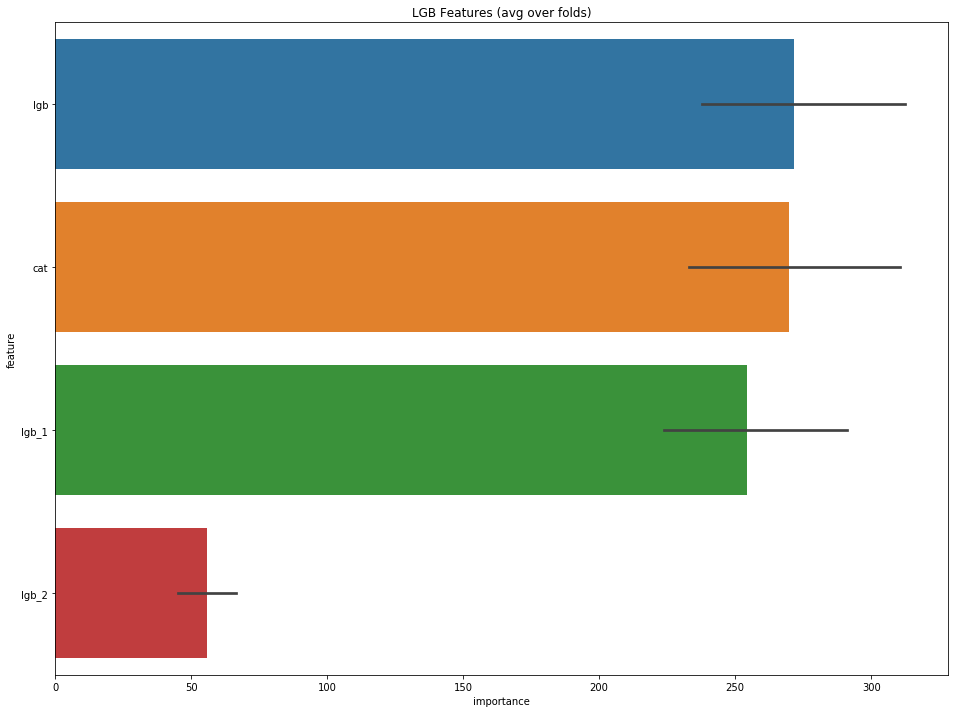

In [190]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:57:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[379]	training's rmse: 2.0683	valid_1's rmse: 2.17023
Fold 1 started at Tue Dec 17 01:57:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 2.06639	valid_1's rmse: 2.21911
Fold 2 started at Tue Dec 17 01:57:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[248]	training's rmse: 2.10368	valid_1's rmse: 2.01311
Fold 3 started at Tue Dec 17 01:57:48 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.04735	valid_1's rmse: 2.08964
Early stopping, best iteration is:
[989]	training's rmse: 2.04822	valid_1's rmse: 2.0889
Fold 4 started at Tue Dec 17 01:57:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[375]	training's rmse

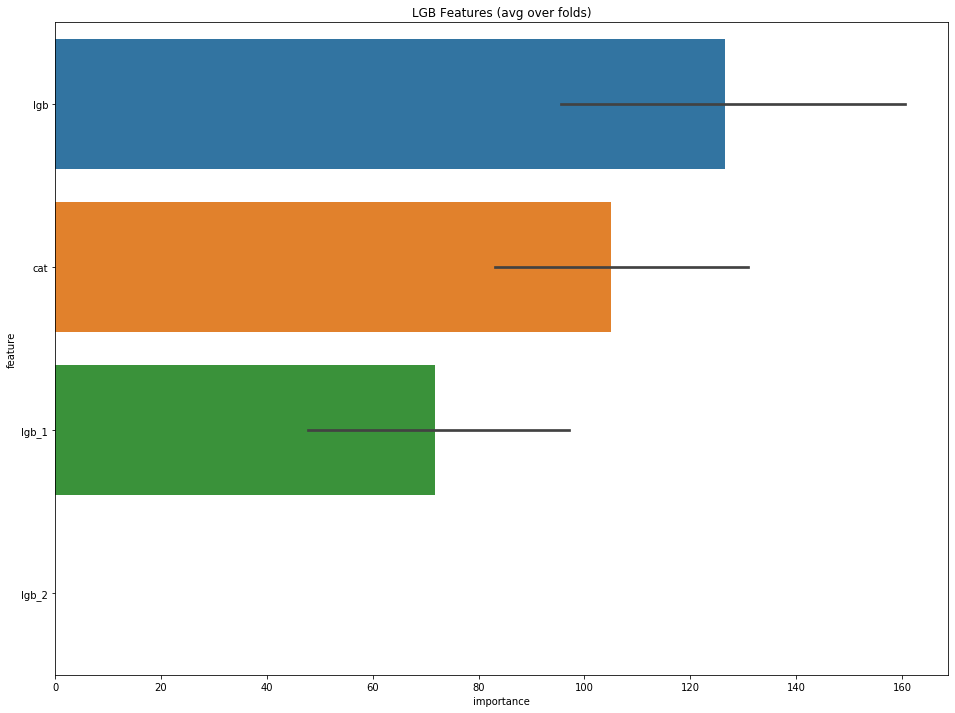

In [191]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [192]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:57:51 2019
Fold 1 started at Tue Dec 17 01:58:00 2019
Fold 2 started at Tue Dec 17 01:58:06 2019
Fold 3 started at Tue Dec 17 01:58:12 2019
Fold 4 started at Tue Dec 17 01:58:21 2019
Fold 5 started at Tue Dec 17 01:58:31 2019
Fold 6 started at Tue Dec 17 01:58:38 2019
Fold 7 started at Tue Dec 17 01:59:24 2019
Fold 8 started at Tue Dec 17 01:59:56 2019
Fold 9 started at Tue Dec 17 02:00:02 2019
CV mean score: 2.1074, std: 0.1314.


##### randomforest作为第二层融合模型

In [193]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:00:08 2019
Fold 1 started at Tue Dec 17 02:00:08 2019
Fold 2 started at Tue Dec 17 02:00:08 2019
Fold 3 started at Tue Dec 17 02:00:09 2019
Fold 4 started at Tue Dec 17 02:00:09 2019
Fold 5 started at Tue Dec 17 02:00:09 2019
Fold 6 started at Tue Dec 17 02:00:09 2019
Fold 7 started at Tue Dec 17 02:00:10 2019
Fold 8 started at Tue Dec 17 02:00:10 2019
Fold 9 started at Tue Dec 17 02:00:10 2019
CV mean score: 2.1711, std: 0.1175.


##### xgboost作为第二层融合模型

In [194]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:00:10 2019
[0]	train-rmse:9.87519	valid_data-rmse:9.86751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.6878	valid_data-rmse:2.19718
Stopping. Best iteration:
[506]	train-rmse:1.68517	valid_data-rmse:2.19687

Fold 1 started at Tue Dec 17 02:00:12 2019
[0]	train-rmse:9.87784	valid_data-rmse:9.84287
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.68832	valid_data-rmse:2.23996
Stopping. Best iteration:
[439]	train-rmse:1.72582	valid_data-rmse:2.23565

Fold 2 started at Tue Dec 17 02:00:14 2019
[0]	train-rmse:9.91027	valid_data-rmse:9.54246
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [195]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:00:31 2019
Fold 1 started at Tue Dec 17 02:00:32 2019
Fold 2 started at Tue Dec 17 02:00:32 2019
Fold 3 started at Tue Dec 17 02:00:33 2019
Fold 4 started at Tue Dec 17 02:00:33 2019
Fold 5 started at Tue Dec 17 02:00:34 2019
Fold 6 started at Tue Dec 17 02:00:34 2019
Fold 7 started at Tue Dec 17 02:00:35 2019
Fold 8 started at Tue Dec 17 02:00:35 2019
Fold 9 started at Tue Dec 17 02:00:36 2019
CV mean score: 2.1581, std: 0.1638.


##### 岭回归做第二层融合模型

In [196]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:00:36 2019
Fold 1 started at Tue Dec 17 02:00:37 2019
Fold 2 started at Tue Dec 17 02:00:37 2019
Fold 3 started at Tue Dec 17 02:00:37 2019
Fold 4 started at Tue Dec 17 02:00:37 2019
Fold 5 started at Tue Dec 17 02:00:37 2019
Fold 6 started at Tue Dec 17 02:00:37 2019
Fold 7 started at Tue Dec 17 02:00:37 2019
Fold 8 started at Tue Dec 17 02:00:37 2019
Fold 9 started at Tue Dec 17 02:00:37 2019
CV mean score: 2.1142, std: 0.1396.


#### 留下lgb和rfr

In [197]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:00:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 1.99205	valid_1's rmse: 2.25191
Fold 1 started at Tue Dec 17 02:00:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 1.97555	valid_1's rmse: 2.2304
Fold 2 started at Tue Dec 17 02:00:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[245]	training's rmse: 2.01941	valid_1's rmse: 2.01415
Fold 3 started at Tue Dec 17 02:00:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.00178	valid_1's rmse: 2.11869
Fold 4 started at Tue Dec 17 02:00:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[393]	training's rmse: 1.93249	valid_1's rmse: 2.3711
Fold 5 started at Tue 

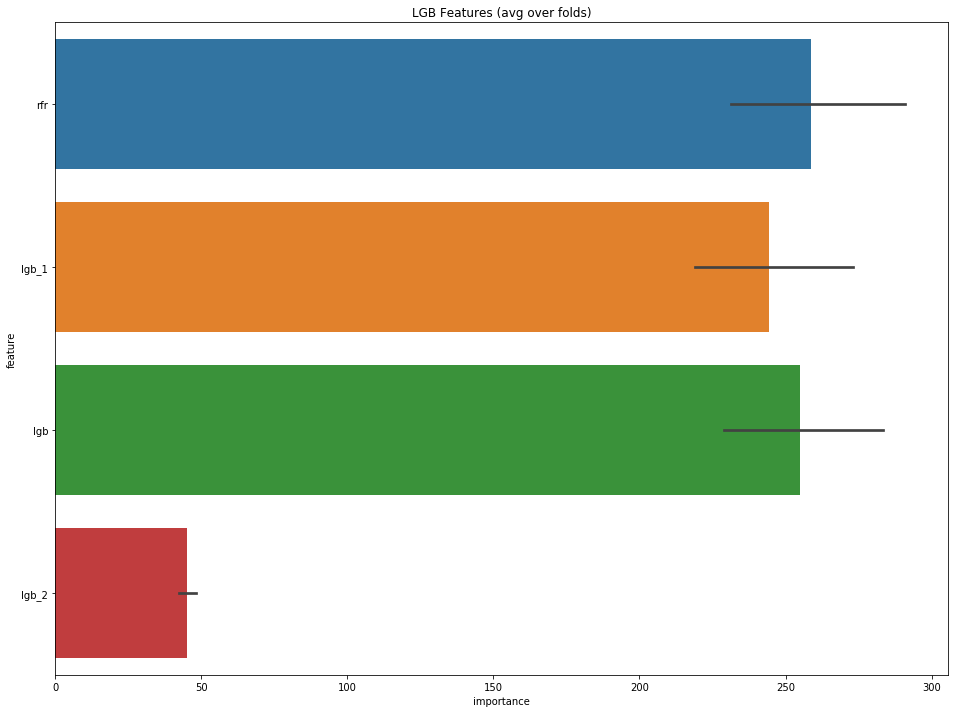

In [198]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:00:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[323]	training's rmse: 2.078	valid_1's rmse: 2.18956
Fold 1 started at Tue Dec 17 02:00:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.0662	valid_1's rmse: 2.22733
Fold 2 started at Tue Dec 17 02:00:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 2.09911	valid_1's rmse: 1.9843
Fold 3 started at Tue Dec 17 02:00:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.04114	valid_1's rmse: 2.09619
Early stopping, best iteration is:
[867]	training's rmse: 2.04948	valid_1's rmse: 2.0947
Fold 4 started at Tue Dec 17 02:00:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 2

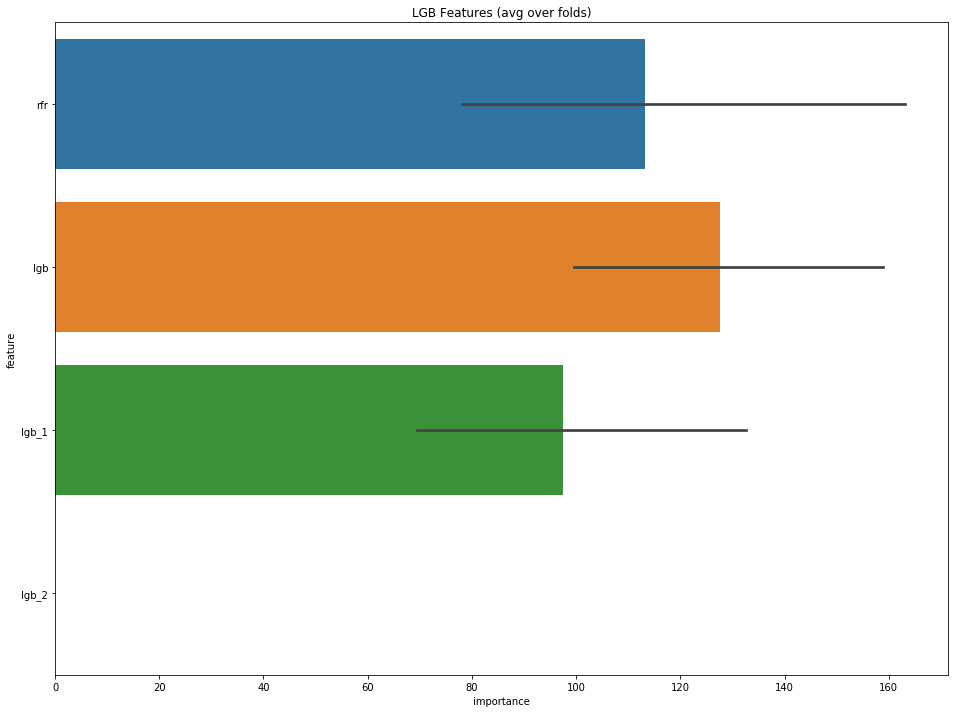

In [199]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [200]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:00:46 2019
Fold 1 started at Tue Dec 17 02:00:54 2019
Fold 2 started at Tue Dec 17 02:01:02 2019
Fold 3 started at Tue Dec 17 02:01:08 2019
Fold 4 started at Tue Dec 17 02:01:15 2019
Fold 5 started at Tue Dec 17 02:01:26 2019
Fold 6 started at Tue Dec 17 02:01:37 2019
Fold 7 started at Tue Dec 17 02:01:53 2019
Fold 8 started at Tue Dec 17 02:02:15 2019
Fold 9 started at Tue Dec 17 02:02:23 2019
CV mean score: 2.1171, std: 0.1435.


##### randomforest作为第二层融合模型

In [201]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:02:28 2019
Fold 1 started at Tue Dec 17 02:02:28 2019
Fold 2 started at Tue Dec 17 02:02:29 2019
Fold 3 started at Tue Dec 17 02:02:29 2019
Fold 4 started at Tue Dec 17 02:02:29 2019
Fold 5 started at Tue Dec 17 02:02:29 2019
Fold 6 started at Tue Dec 17 02:02:30 2019
Fold 7 started at Tue Dec 17 02:02:30 2019
Fold 8 started at Tue Dec 17 02:02:30 2019
Fold 9 started at Tue Dec 17 02:02:30 2019
CV mean score: 2.2032, std: 0.1395.


##### xgboost作为第二层融合模型

In [202]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:02:30 2019
[0]	train-rmse:9.87513	valid_data-rmse:9.86738
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.68018	valid_data-rmse:2.25895
Stopping. Best iteration:
[373]	train-rmse:1.78023	valid_data-rmse:2.24993

Fold 1 started at Tue Dec 17 02:02:32 2019
[0]	train-rmse:9.87789	valid_data-rmse:9.84355
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.68709	valid_data-rmse:2.24434
Stopping. Best iteration:
[409]	train-rmse:1.74859	valid_data-rmse:2.24054

Fold 2 started at Tue Dec 17 02:02:34 2019
[0]	train-rmse:9.91024	valid_data-rmse:9.54261
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [203]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:02:51 2019
Fold 1 started at Tue Dec 17 02:02:51 2019
Fold 2 started at Tue Dec 17 02:02:52 2019
Fold 3 started at Tue Dec 17 02:02:53 2019
Fold 4 started at Tue Dec 17 02:02:53 2019
Fold 5 started at Tue Dec 17 02:02:54 2019
Fold 6 started at Tue Dec 17 02:02:54 2019
Fold 7 started at Tue Dec 17 02:02:55 2019
Fold 8 started at Tue Dec 17 02:02:55 2019
Fold 9 started at Tue Dec 17 02:02:56 2019
CV mean score: 2.1609, std: 0.1692.


##### 岭回归做第二层融合模型

In [204]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:02:57 2019
Fold 1 started at Tue Dec 17 02:02:57 2019
Fold 2 started at Tue Dec 17 02:02:57 2019
Fold 3 started at Tue Dec 17 02:02:57 2019
Fold 4 started at Tue Dec 17 02:02:57 2019
Fold 5 started at Tue Dec 17 02:02:57 2019
Fold 6 started at Tue Dec 17 02:02:57 2019
Fold 7 started at Tue Dec 17 02:02:57 2019
Fold 8 started at Tue Dec 17 02:02:57 2019
Fold 9 started at Tue Dec 17 02:02:57 2019
CV mean score: 2.1174, std: 0.1429.


#### 留下lgb和svr

In [205]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:02:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[245]	training's rmse: 1.98015	valid_1's rmse: 2.22714
Fold 1 started at Tue Dec 17 02:02:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 1.95994	valid_1's rmse: 2.22899
Fold 2 started at Tue Dec 17 02:02:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 2.01597	valid_1's rmse: 2.03423
Fold 3 started at Tue Dec 17 02:02:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 1.96875	valid_1's rmse: 2.13257
Fold 4 started at Tue Dec 17 02:02:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 1.91123	valid_1's rmse: 2.35056
Fold 5 started at Tu

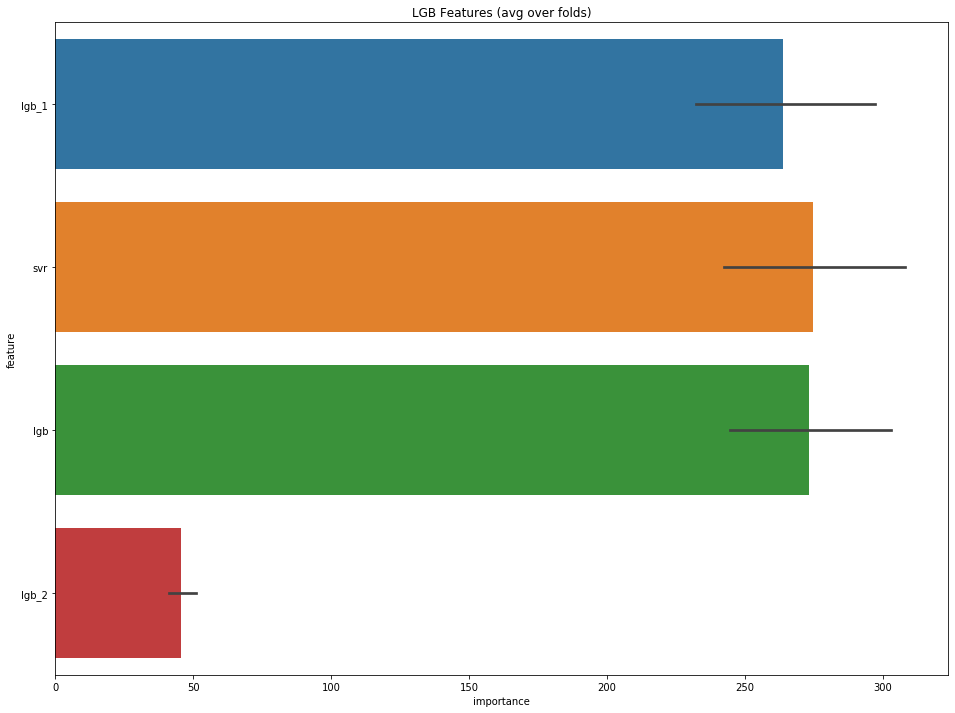

In [206]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:03:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[320]	training's rmse: 2.06651	valid_1's rmse: 2.18145
Fold 1 started at Tue Dec 17 02:03:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's rmse: 2.05968	valid_1's rmse: 2.20354
Fold 2 started at Tue Dec 17 02:03:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 2.08917	valid_1's rmse: 2.00061
Fold 3 started at Tue Dec 17 02:03:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.03202	valid_1's rmse: 2.09364
Early stopping, best iteration is:
[1097]	training's rmse: 2.02749	valid_1's rmse: 2.09135
Fold 4 started at Tue Dec 17 02:03:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[464]	training's r

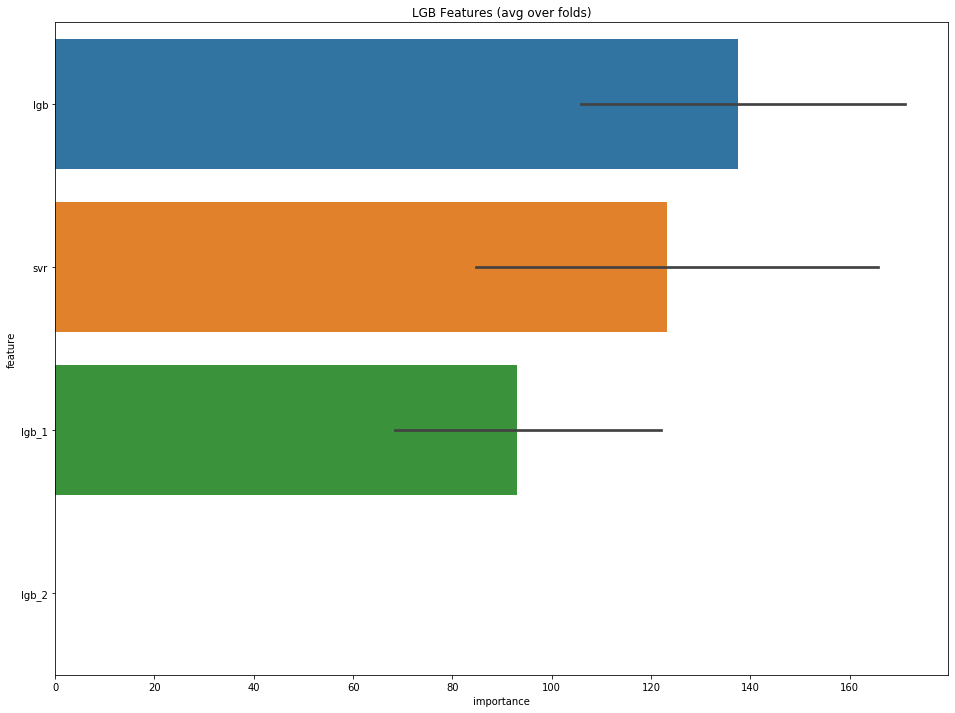

In [207]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [208]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:03:06 2019
Fold 1 started at Tue Dec 17 02:03:14 2019
Fold 2 started at Tue Dec 17 02:03:22 2019
Fold 3 started at Tue Dec 17 02:03:27 2019
Fold 4 started at Tue Dec 17 02:03:31 2019
Fold 5 started at Tue Dec 17 02:03:42 2019
Fold 6 started at Tue Dec 17 02:03:51 2019
Fold 7 started at Tue Dec 17 02:04:16 2019
Fold 8 started at Tue Dec 17 02:04:31 2019
Fold 9 started at Tue Dec 17 02:04:38 2019
CV mean score: 2.1157, std: 0.1353.


##### randomforest作为第二层融合模型

In [209]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:04:40 2019
Fold 1 started at Tue Dec 17 02:04:40 2019
Fold 2 started at Tue Dec 17 02:04:40 2019
Fold 3 started at Tue Dec 17 02:04:40 2019
Fold 4 started at Tue Dec 17 02:04:41 2019
Fold 5 started at Tue Dec 17 02:04:41 2019
Fold 6 started at Tue Dec 17 02:04:41 2019
Fold 7 started at Tue Dec 17 02:04:41 2019
Fold 8 started at Tue Dec 17 02:04:42 2019
Fold 9 started at Tue Dec 17 02:04:42 2019
CV mean score: 2.1787, std: 0.1349.


##### xgboost作为第二层融合模型

In [210]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:04:42 2019
[0]	train-rmse:9.87515	valid_data-rmse:9.86749
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.6641	valid_data-rmse:2.2528
Stopping. Best iteration:
[424]	train-rmse:1.71873	valid_data-rmse:2.24735

Fold 1 started at Tue Dec 17 02:04:44 2019
[0]	train-rmse:9.87787	valid_data-rmse:9.8435
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.67566	valid_data-rmse:2.23608
Stopping. Best iteration:
[423]	train-rmse:1.72504	valid_data-rmse:2.23244

Fold 2 started at Tue Dec 17 02:04:46 2019
[0]	train-rmse:9.91029	valid_data-rmse:9.54234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [211]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:05:02 2019
Fold 1 started at Tue Dec 17 02:05:03 2019
Fold 2 started at Tue Dec 17 02:05:03 2019
Fold 3 started at Tue Dec 17 02:05:04 2019
Fold 4 started at Tue Dec 17 02:05:04 2019
Fold 5 started at Tue Dec 17 02:05:05 2019
Fold 6 started at Tue Dec 17 02:05:06 2019
Fold 7 started at Tue Dec 17 02:05:06 2019
Fold 8 started at Tue Dec 17 02:05:07 2019
Fold 9 started at Tue Dec 17 02:05:07 2019
CV mean score: 2.1708, std: 0.1722.


##### 岭回归做第二层融合模型

In [212]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:05:08 2019
Fold 1 started at Tue Dec 17 02:05:08 2019
Fold 2 started at Tue Dec 17 02:05:08 2019
Fold 3 started at Tue Dec 17 02:05:08 2019
Fold 4 started at Tue Dec 17 02:05:08 2019
Fold 5 started at Tue Dec 17 02:05:08 2019
Fold 6 started at Tue Dec 17 02:05:08 2019
Fold 7 started at Tue Dec 17 02:05:08 2019
Fold 8 started at Tue Dec 17 02:05:09 2019
Fold 9 started at Tue Dec 17 02:05:09 2019
CV mean score: 2.1151, std: 0.1394.


#### 留下lgb和xgb

In [213]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:05:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[244]	training's rmse: 1.99057	valid_1's rmse: 2.26915
Fold 1 started at Tue Dec 17 02:05:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 1.99955	valid_1's rmse: 2.25087
Fold 2 started at Tue Dec 17 02:05:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 2.0147	valid_1's rmse: 1.96862
Fold 3 started at Tue Dec 17 02:05:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 2.00927	valid_1's rmse: 2.1334
Fold 4 started at Tue Dec 17 02:05:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[469]	training's rmse: 1.92315	valid_1's rmse: 2.3482
Fold 5 started at Tue D

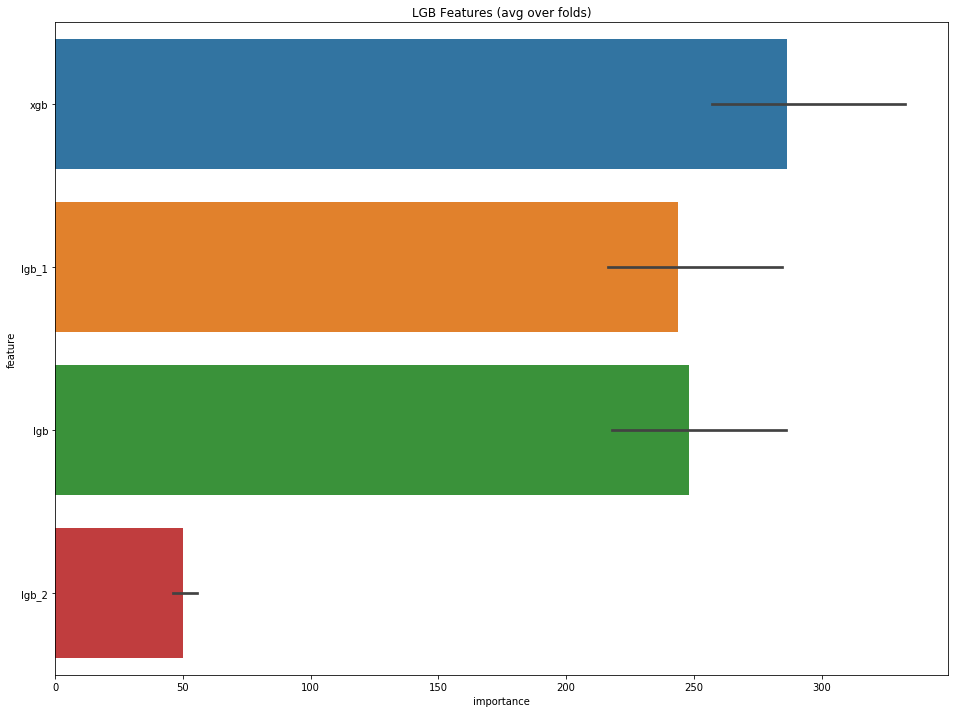

In [214]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:05:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 2.0737	valid_1's rmse: 2.19831
Fold 1 started at Tue Dec 17 02:05:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[365]	training's rmse: 2.05837	valid_1's rmse: 2.22487
Fold 2 started at Tue Dec 17 02:05:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[483]	training's rmse: 2.07762	valid_1's rmse: 1.95618
Fold 3 started at Tue Dec 17 02:05:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[732]	training's rmse: 2.04652	valid_1's rmse: 2.09828
Fold 4 started at Tue Dec 17 02:05:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[779]	training's rmse: 2.02052	valid_1's rmse: 2.32711
Fold 5 started at Tue

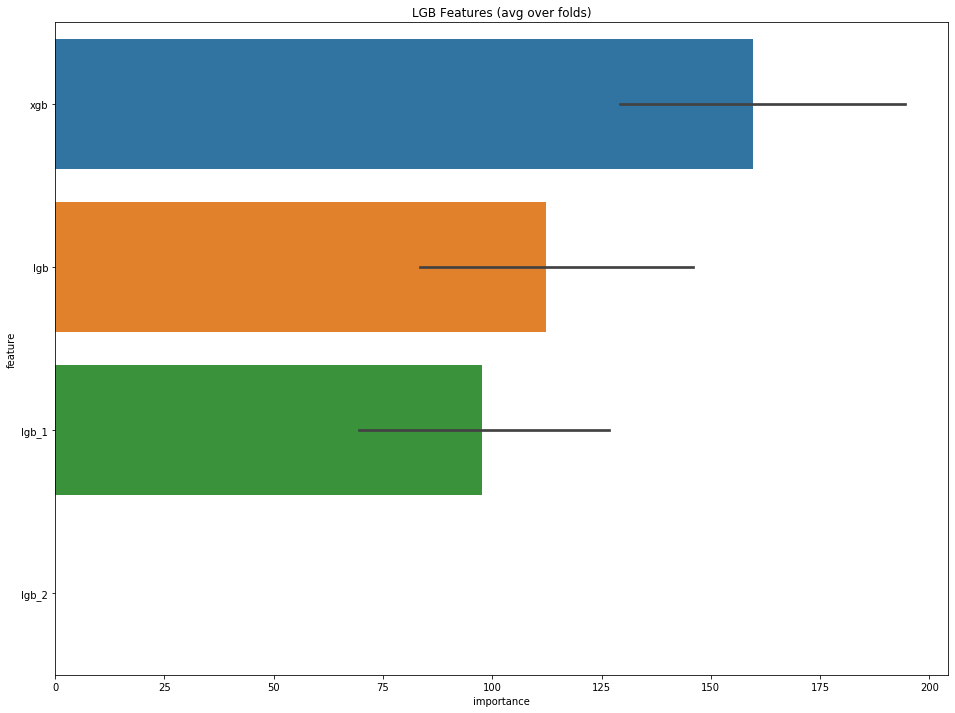

In [215]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [216]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:05:40 2019
Fold 1 started at Tue Dec 17 02:05:47 2019
Fold 2 started at Tue Dec 17 02:05:55 2019
Fold 3 started at Tue Dec 17 02:06:02 2019
Fold 4 started at Tue Dec 17 02:06:10 2019
Fold 5 started at Tue Dec 17 02:06:20 2019
Fold 6 started at Tue Dec 17 02:06:29 2019
Fold 7 started at Tue Dec 17 02:06:54 2019
Fold 8 started at Tue Dec 17 02:07:10 2019
Fold 9 started at Tue Dec 17 02:07:15 2019
CV mean score: 2.1093, std: 0.1427.


##### randomforest作为第二层融合模型

In [217]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:07:22 2019
Fold 1 started at Tue Dec 17 02:07:22 2019
Fold 2 started at Tue Dec 17 02:07:23 2019
Fold 3 started at Tue Dec 17 02:07:23 2019
Fold 4 started at Tue Dec 17 02:07:23 2019
Fold 5 started at Tue Dec 17 02:07:23 2019
Fold 6 started at Tue Dec 17 02:07:24 2019
Fold 7 started at Tue Dec 17 02:07:24 2019
Fold 8 started at Tue Dec 17 02:07:24 2019
Fold 9 started at Tue Dec 17 02:07:24 2019
CV mean score: 2.1828, std: 0.1482.


##### xgboost作为第二层融合模型

In [218]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:07:25 2019
[0]	train-rmse:9.8751	valid_data-rmse:9.86664
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.67611	valid_data-rmse:2.29083
Stopping. Best iteration:
[378]	train-rmse:1.77096	valid_data-rmse:2.27749

Fold 1 started at Tue Dec 17 02:07:26 2019
[0]	train-rmse:9.87786	valid_data-rmse:9.84371
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.68363	valid_data-rmse:2.26807
Stopping. Best iteration:
[445]	train-rmse:1.71629	valid_data-rmse:2.26451

Fold 2 started at Tue Dec 17 02:07:28 2019
[0]	train-rmse:9.91019	valid_data-rmse:9.54369
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [219]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:07:44 2019
Fold 1 started at Tue Dec 17 02:07:45 2019
Fold 2 started at Tue Dec 17 02:07:45 2019
Fold 3 started at Tue Dec 17 02:07:46 2019
Fold 4 started at Tue Dec 17 02:07:46 2019
Fold 5 started at Tue Dec 17 02:07:47 2019
Fold 6 started at Tue Dec 17 02:07:47 2019
Fold 7 started at Tue Dec 17 02:07:48 2019
Fold 8 started at Tue Dec 17 02:07:48 2019
Fold 9 started at Tue Dec 17 02:07:49 2019
CV mean score: 2.1556, std: 0.1728.


##### 岭回归做第二层融合模型

In [220]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:07:49 2019
Fold 1 started at Tue Dec 17 02:07:50 2019
Fold 2 started at Tue Dec 17 02:07:50 2019
Fold 3 started at Tue Dec 17 02:07:50 2019
Fold 4 started at Tue Dec 17 02:07:50 2019
Fold 5 started at Tue Dec 17 02:07:50 2019
Fold 6 started at Tue Dec 17 02:07:50 2019
Fold 7 started at Tue Dec 17 02:07:50 2019
Fold 8 started at Tue Dec 17 02:07:50 2019
Fold 9 started at Tue Dec 17 02:07:50 2019
CV mean score: 2.1126, std: 0.1434.


#### 只留下cat

In [221]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:07:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 2.07607	valid_1's rmse: 2.19013
Fold 1 started at Tue Dec 17 02:07:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 2.07976	valid_1's rmse: 2.2389
Fold 2 started at Tue Dec 17 02:07:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[227]	training's rmse: 2.11091	valid_1's rmse: 2.04935
Fold 3 started at Tue Dec 17 02:07:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 2.09115	valid_1's rmse: 2.10896
Fold 4 started at Tue Dec 17 02:07:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[548]	training's rmse: 2.04805	valid_1's rmse: 2.36547
Fold 5 started at Tue

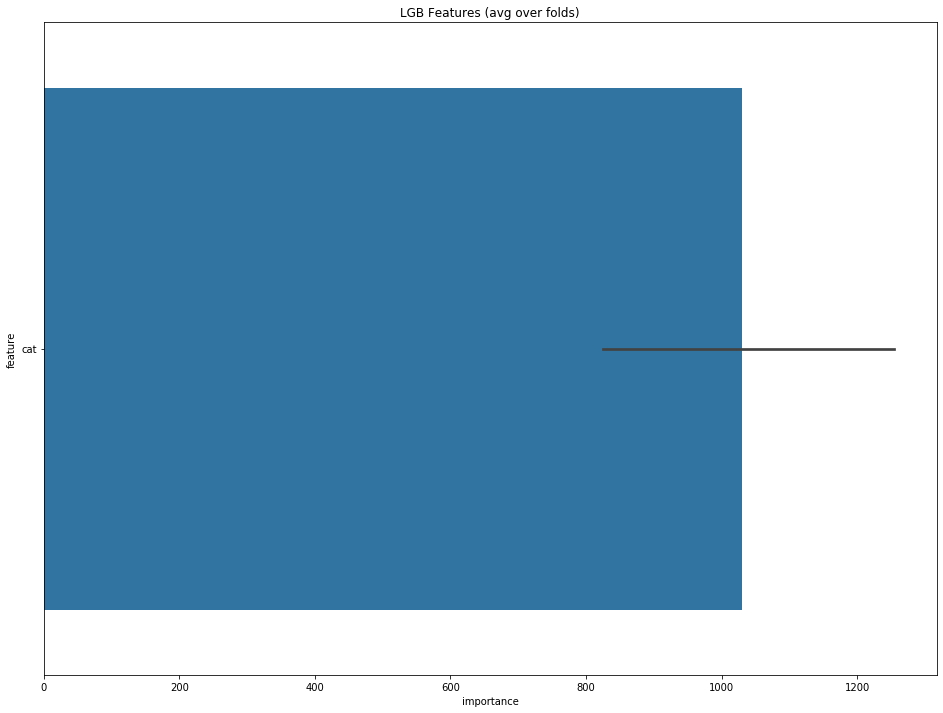

In [222]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:07:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[792]	training's rmse: 2.09681	valid_1's rmse: 2.18064
Fold 1 started at Tue Dec 17 02:07:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[372]	training's rmse: 2.09802	valid_1's rmse: 2.21828
Fold 2 started at Tue Dec 17 02:07:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 2.13538	valid_1's rmse: 2.04791
Fold 3 started at Tue Dec 17 02:07:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[325]	training's rmse: 2.11837	valid_1's rmse: 2.09223
Fold 4 started at Tue Dec 17 02:07:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[467]	training's rmse: 2.08179	valid_1's rmse: 2.3403
Fold 5 started at Tue

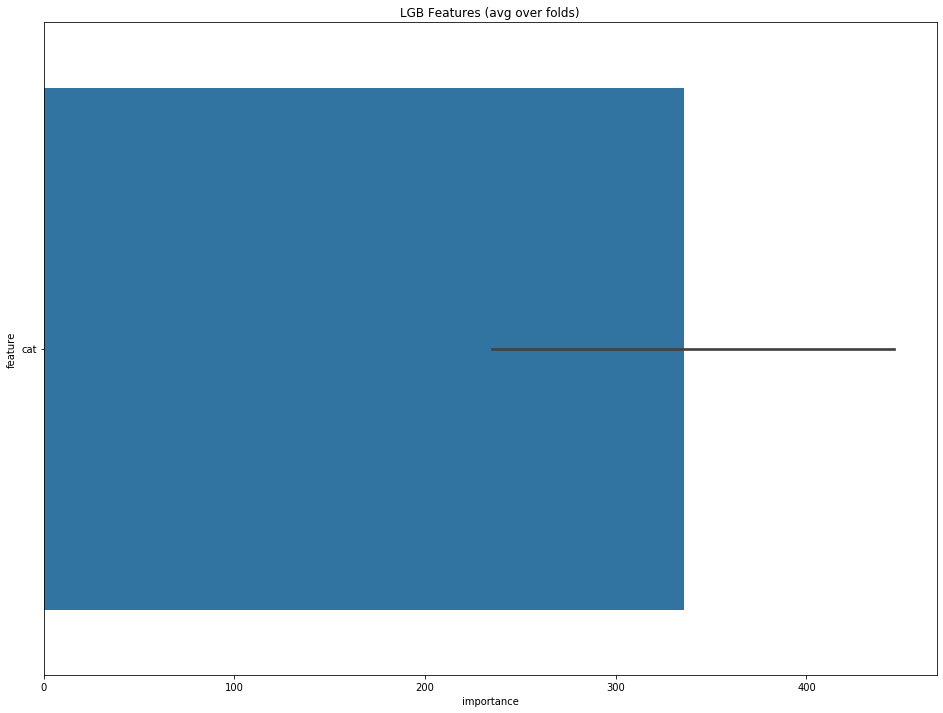

In [223]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [224]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:07:58 2019
Fold 1 started at Tue Dec 17 02:08:08 2019
Fold 2 started at Tue Dec 17 02:08:13 2019
Fold 3 started at Tue Dec 17 02:08:17 2019
Fold 4 started at Tue Dec 17 02:08:25 2019
Fold 5 started at Tue Dec 17 02:08:34 2019
Fold 6 started at Tue Dec 17 02:08:40 2019
Fold 7 started at Tue Dec 17 02:08:49 2019
Fold 8 started at Tue Dec 17 02:08:58 2019
Fold 9 started at Tue Dec 17 02:09:06 2019
CV mean score: 2.1329, std: 0.1407.


##### randomforest作为第二层融合模型

In [225]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:09:14 2019
Fold 1 started at Tue Dec 17 02:09:14 2019
Fold 2 started at Tue Dec 17 02:09:14 2019
Fold 3 started at Tue Dec 17 02:09:14 2019
Fold 4 started at Tue Dec 17 02:09:15 2019
Fold 5 started at Tue Dec 17 02:09:15 2019
Fold 6 started at Tue Dec 17 02:09:15 2019
Fold 7 started at Tue Dec 17 02:09:15 2019
Fold 8 started at Tue Dec 17 02:09:16 2019
Fold 9 started at Tue Dec 17 02:09:16 2019
CV mean score: 2.3013, std: 0.1183.


##### xgboost作为第二层融合模型

In [226]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:09:16 2019
[0]	train-rmse:9.87527	valid_data-rmse:9.86704
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.86878	valid_data-rmse:2.20954
Stopping. Best iteration:
[436]	train-rmse:1.89778	valid_data-rmse:2.202

Fold 1 started at Tue Dec 17 02:09:17 2019
[0]	train-rmse:9.87797	valid_data-rmse:9.84367
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.85917	valid_data-rmse:2.28296
Stopping. Best iteration:
[396]	train-rmse:1.90971	valid_data-rmse:2.27388

Fold 2 started at Tue Dec 17 02:09:18 2019
[0]	train-rmse:9.91036	valid_data-rmse:9.54293
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [227]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:09:26 2019
Fold 1 started at Tue Dec 17 02:09:27 2019
Fold 2 started at Tue Dec 17 02:09:27 2019
Fold 3 started at Tue Dec 17 02:09:28 2019
Fold 4 started at Tue Dec 17 02:09:28 2019
Fold 5 started at Tue Dec 17 02:09:29 2019
Fold 6 started at Tue Dec 17 02:09:29 2019
Fold 7 started at Tue Dec 17 02:09:30 2019
Fold 8 started at Tue Dec 17 02:09:30 2019
Fold 9 started at Tue Dec 17 02:09:31 2019
CV mean score: 2.1756, std: 0.1592.


##### 岭回归做第二层融合模型

In [228]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:09:31 2019
Fold 1 started at Tue Dec 17 02:09:31 2019
Fold 2 started at Tue Dec 17 02:09:31 2019
Fold 3 started at Tue Dec 17 02:09:31 2019
Fold 4 started at Tue Dec 17 02:09:32 2019
Fold 5 started at Tue Dec 17 02:09:32 2019
Fold 6 started at Tue Dec 17 02:09:32 2019
Fold 7 started at Tue Dec 17 02:09:32 2019
Fold 8 started at Tue Dec 17 02:09:32 2019
Fold 9 started at Tue Dec 17 02:09:32 2019
CV mean score: 2.1316, std: 0.1397.


#### 只留下rfr

In [229]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:09:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[387]	training's rmse: 2.10733	valid_1's rmse: 2.23549
Fold 1 started at Tue Dec 17 02:09:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 2.11704	valid_1's rmse: 2.26904
Fold 2 started at Tue Dec 17 02:09:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[230]	training's rmse: 2.15179	valid_1's rmse: 2.02783
Fold 3 started at Tue Dec 17 02:09:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[277]	training's rmse: 2.13759	valid_1's rmse: 2.07962
Fold 4 started at Tue Dec 17 02:09:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[448]	training's rmse: 2.07812	valid_1's rmse: 2.4738
Fold 5 started at Tue

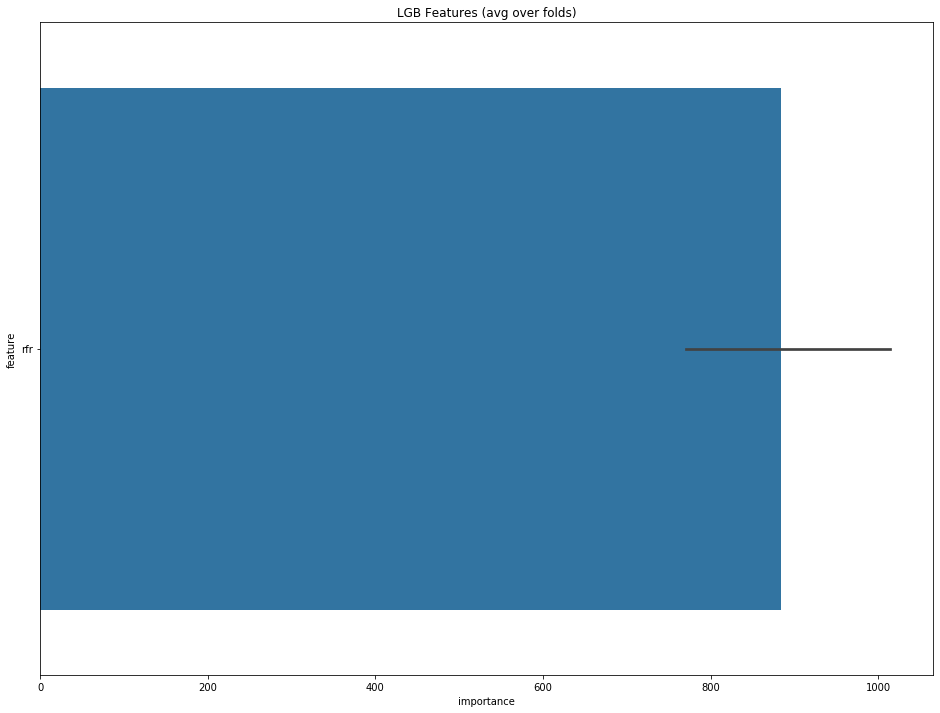

In [230]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:09:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 2.13676	valid_1's rmse: 2.21567
Fold 1 started at Tue Dec 17 02:09:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[278]	training's rmse: 2.14663	valid_1's rmse: 2.24025
Fold 2 started at Tue Dec 17 02:09:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[270]	training's rmse: 2.17258	valid_1's rmse: 2.01832
Fold 3 started at Tue Dec 17 02:09:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 2.16096	valid_1's rmse: 2.0818
Fold 4 started at Tue Dec 17 02:09:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[542]	training's rmse: 2.1093	valid_1's rmse: 2.44582
Fold 5 started at Tue 

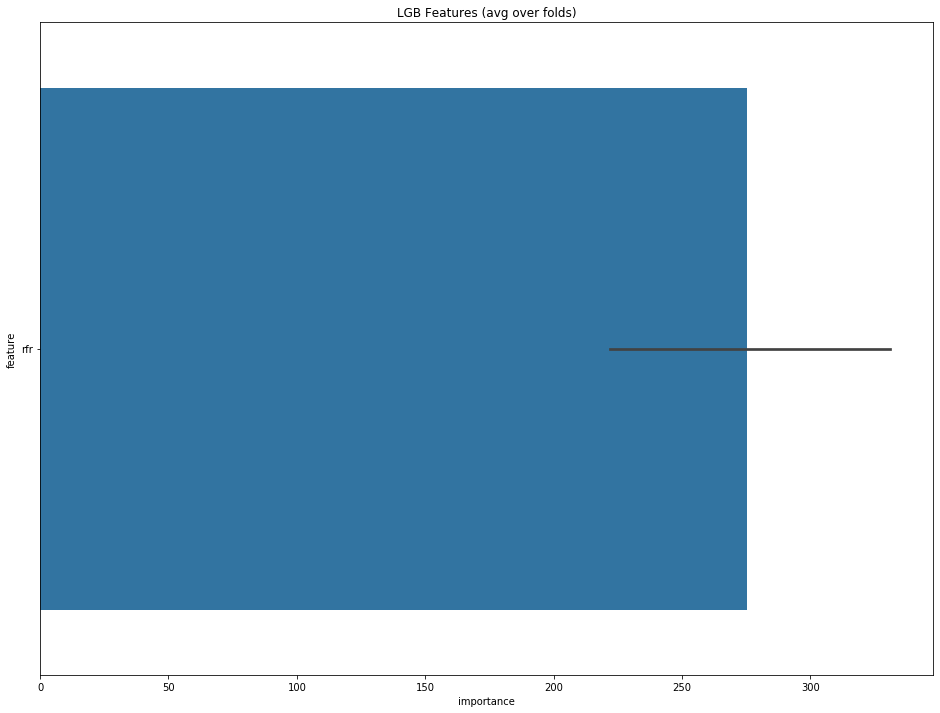

In [231]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [232]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:09:39 2019
Fold 1 started at Tue Dec 17 02:09:47 2019
Fold 2 started at Tue Dec 17 02:09:52 2019
Fold 3 started at Tue Dec 17 02:09:56 2019
Fold 4 started at Tue Dec 17 02:09:59 2019
Fold 5 started at Tue Dec 17 02:10:15 2019
Fold 6 started at Tue Dec 17 02:10:22 2019
Fold 7 started at Tue Dec 17 02:10:32 2019
Fold 8 started at Tue Dec 17 02:10:37 2019
Fold 9 started at Tue Dec 17 02:10:49 2019
CV mean score: 2.1688, std: 0.1579.


##### randomforest作为第二层融合模型

In [233]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:10:57 2019
Fold 1 started at Tue Dec 17 02:10:57 2019
Fold 2 started at Tue Dec 17 02:10:57 2019
Fold 3 started at Tue Dec 17 02:10:58 2019
Fold 4 started at Tue Dec 17 02:10:58 2019
Fold 5 started at Tue Dec 17 02:10:58 2019
Fold 6 started at Tue Dec 17 02:10:58 2019
Fold 7 started at Tue Dec 17 02:10:59 2019
Fold 8 started at Tue Dec 17 02:10:59 2019
Fold 9 started at Tue Dec 17 02:10:59 2019
CV mean score: 2.3110, std: 0.1547.


##### xgboost作为第二层融合模型

In [234]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:10:59 2019
[0]	train-rmse:9.87537	valid_data-rmse:9.86753
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.89349	valid_data-rmse:2.21874
Stopping. Best iteration:
[485]	train-rmse:1.9011	valid_data-rmse:2.21769

Fold 1 started at Tue Dec 17 02:11:00 2019
[0]	train-rmse:9.87812	valid_data-rmse:9.84337
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.88232	valid_data-rmse:2.28923
Stopping. Best iteration:
[433]	train-rmse:1.9145	valid_data-rmse:2.28345

Fold 2 started at Tue Dec 17 02:11:01 2019
[0]	train-rmse:9.9104	valid_data-rmse:9.54235
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [235]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:11:10 2019
Fold 1 started at Tue Dec 17 02:11:10 2019
Fold 2 started at Tue Dec 17 02:11:11 2019
Fold 3 started at Tue Dec 17 02:11:11 2019
Fold 4 started at Tue Dec 17 02:11:12 2019
Fold 5 started at Tue Dec 17 02:11:12 2019
Fold 6 started at Tue Dec 17 02:11:13 2019
Fold 7 started at Tue Dec 17 02:11:13 2019
Fold 8 started at Tue Dec 17 02:11:14 2019
Fold 9 started at Tue Dec 17 02:11:14 2019
CV mean score: 2.2168, std: 0.1756.


##### 岭回归做第二层融合模型

In [236]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:11:15 2019
Fold 1 started at Tue Dec 17 02:11:15 2019
Fold 2 started at Tue Dec 17 02:11:15 2019
Fold 3 started at Tue Dec 17 02:11:15 2019
Fold 4 started at Tue Dec 17 02:11:15 2019
Fold 5 started at Tue Dec 17 02:11:15 2019
Fold 6 started at Tue Dec 17 02:11:15 2019
Fold 7 started at Tue Dec 17 02:11:15 2019
Fold 8 started at Tue Dec 17 02:11:16 2019
Fold 9 started at Tue Dec 17 02:11:16 2019
CV mean score: 2.1673, std: 0.1488.


#### 只留下svr

In [237]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:11:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[301]	training's rmse: 2.22023	valid_1's rmse: 2.38041
Fold 1 started at Tue Dec 17 02:11:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[304]	training's rmse: 2.22832	valid_1's rmse: 2.30509
Fold 2 started at Tue Dec 17 02:11:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[196]	training's rmse: 2.27363	valid_1's rmse: 2.20493
Fold 3 started at Tue Dec 17 02:11:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 2.24971	valid_1's rmse: 2.18911
Fold 4 started at Tue Dec 17 02:11:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[410]	training's rmse: 2.19524	valid_1's rmse: 2.59804
Fold 5 started at Tu

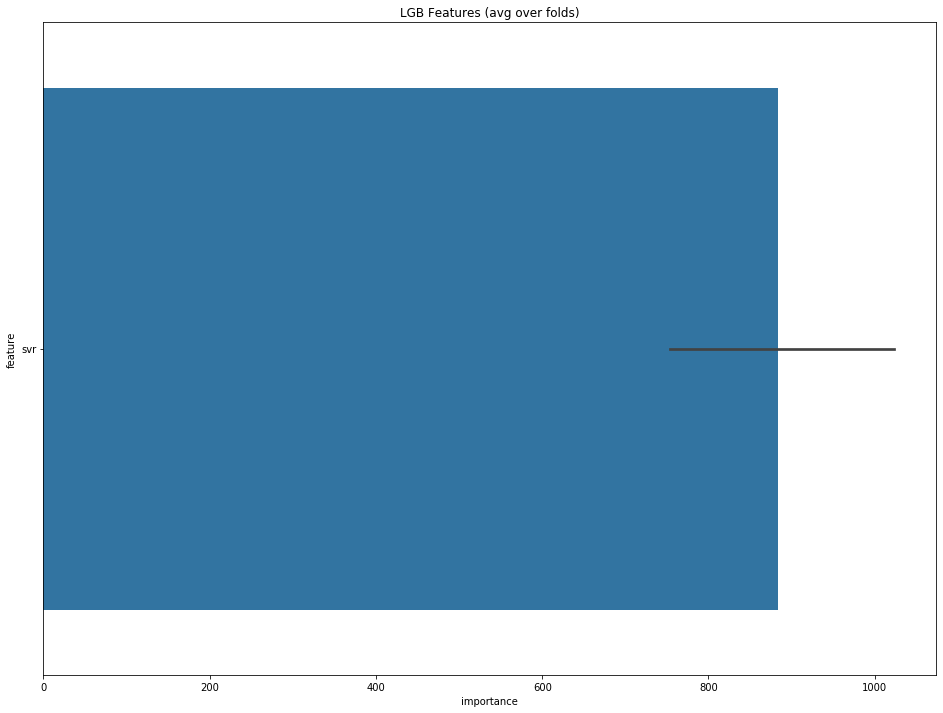

In [238]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:11:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[341]	training's rmse: 2.25465	valid_1's rmse: 2.33267
Fold 1 started at Tue Dec 17 02:11:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	training's rmse: 2.26079	valid_1's rmse: 2.28801
Fold 2 started at Tue Dec 17 02:11:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[216]	training's rmse: 2.28997	valid_1's rmse: 2.17651
Fold 3 started at Tue Dec 17 02:11:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[480]	training's rmse: 2.26462	valid_1's rmse: 2.19931
Fold 4 started at Tue Dec 17 02:11:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[404]	training's rmse: 2.22396	valid_1's rmse: 2.57646
Fold 5 started at Tu

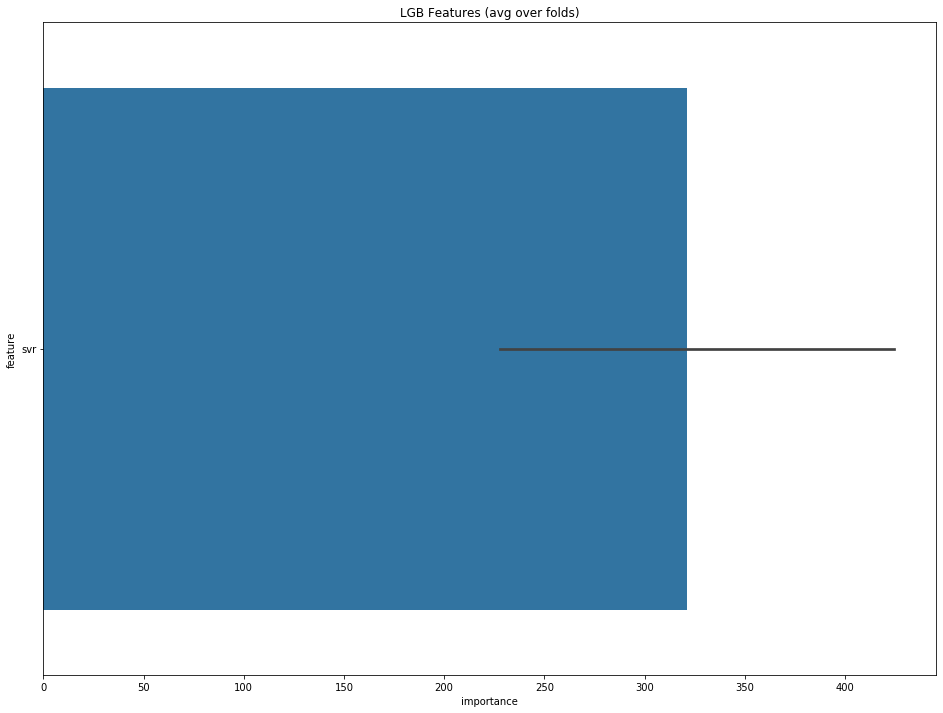

In [239]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [240]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:11:23 2019
Fold 1 started at Tue Dec 17 02:11:31 2019
Fold 2 started at Tue Dec 17 02:11:40 2019
Fold 3 started at Tue Dec 17 02:11:44 2019
Fold 4 started at Tue Dec 17 02:11:49 2019
Fold 5 started at Tue Dec 17 02:11:57 2019
Fold 6 started at Tue Dec 17 02:11:59 2019
Fold 7 started at Tue Dec 17 02:12:24 2019
Fold 8 started at Tue Dec 17 02:12:34 2019
Fold 9 started at Tue Dec 17 02:12:44 2019
CV mean score: 2.2837, std: 0.1451.


##### randomforest作为第二层融合模型

In [241]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:12:48 2019
Fold 1 started at Tue Dec 17 02:12:49 2019
Fold 2 started at Tue Dec 17 02:12:49 2019
Fold 3 started at Tue Dec 17 02:12:49 2019
Fold 4 started at Tue Dec 17 02:12:49 2019
Fold 5 started at Tue Dec 17 02:12:50 2019
Fold 6 started at Tue Dec 17 02:12:50 2019
Fold 7 started at Tue Dec 17 02:12:50 2019
Fold 8 started at Tue Dec 17 02:12:50 2019
Fold 9 started at Tue Dec 17 02:12:51 2019
CV mean score: 2.4662, std: 0.1288.


##### xgboost作为第二层融合模型

In [242]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:12:51 2019
[0]	train-rmse:9.87577	valid_data-rmse:9.86758
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.02777	valid_data-rmse:2.39999
Stopping. Best iteration:
[408]	train-rmse:2.06748	valid_data-rmse:2.39576

Fold 1 started at Tue Dec 17 02:12:52 2019
[0]	train-rmse:9.87861	valid_data-rmse:9.84468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.03134	valid_data-rmse:2.34185
Stopping. Best iteration:
[434]	train-rmse:2.05903	valid_data-rmse:2.33858

Fold 2 started at Tue Dec 17 02:12:52 2019
[0]	train-rmse:9.91102	valid_data-rmse:9.54362
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

##### svr 作为第二层融合模型

In [243]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:12:58 2019
Fold 1 started at Tue Dec 17 02:12:59 2019
Fold 2 started at Tue Dec 17 02:12:59 2019
Fold 3 started at Tue Dec 17 02:12:59 2019
Fold 4 started at Tue Dec 17 02:13:00 2019
Fold 5 started at Tue Dec 17 02:13:00 2019
Fold 6 started at Tue Dec 17 02:13:00 2019
Fold 7 started at Tue Dec 17 02:13:01 2019
Fold 8 started at Tue Dec 17 02:13:01 2019
Fold 9 started at Tue Dec 17 02:13:01 2019
CV mean score: 2.3534, std: 0.1843.


##### 岭回归做第二层融合模型

In [244]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:13:02 2019
Fold 1 started at Tue Dec 17 02:13:02 2019
Fold 2 started at Tue Dec 17 02:13:02 2019
Fold 3 started at Tue Dec 17 02:13:02 2019
Fold 4 started at Tue Dec 17 02:13:02 2019
Fold 5 started at Tue Dec 17 02:13:02 2019
Fold 6 started at Tue Dec 17 02:13:02 2019
Fold 7 started at Tue Dec 17 02:13:02 2019
Fold 8 started at Tue Dec 17 02:13:02 2019
Fold 9 started at Tue Dec 17 02:13:02 2019
CV mean score: 2.3011, std: 0.1477.


#### 只留下xgb

In [245]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:13:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 2.05375	valid_1's rmse: 2.21639
Fold 1 started at Tue Dec 17 02:13:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 2.06854	valid_1's rmse: 2.25931
Fold 2 started at Tue Dec 17 02:13:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 2.09232	valid_1's rmse: 1.94944
Fold 3 started at Tue Dec 17 02:13:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 2.07398	valid_1's rmse: 2.12081
Fold 4 started at Tue Dec 17 02:13:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[457]	training's rmse: 2.03762	valid_1's rmse: 2.33856
Fold 5 started at Tu

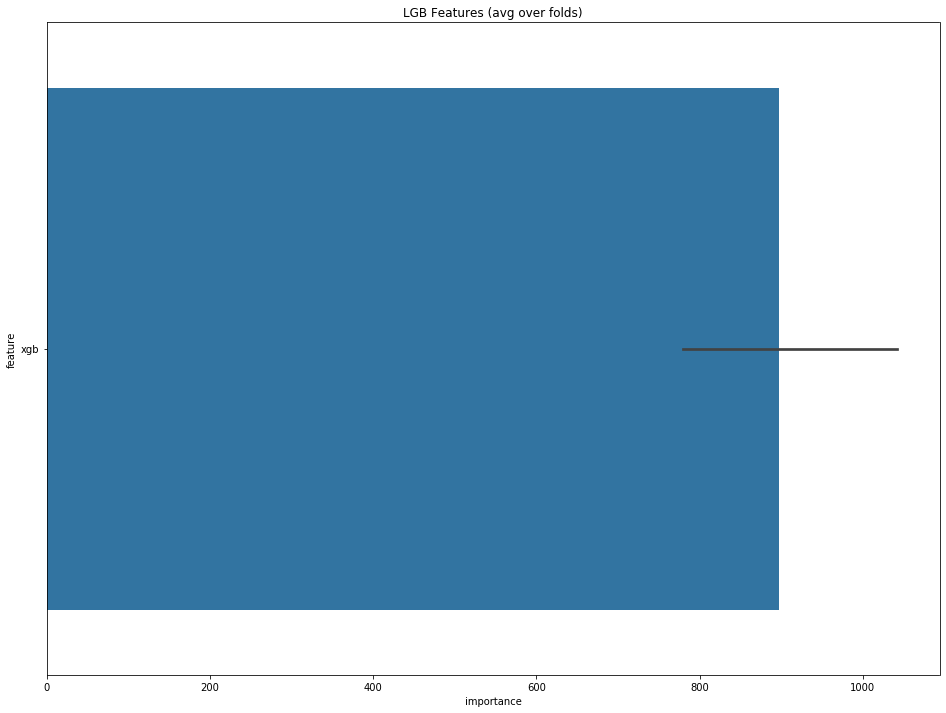

In [246]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:13:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[396]	training's rmse: 2.08473	valid_1's rmse: 2.19884
Fold 1 started at Tue Dec 17 02:13:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 2.08833	valid_1's rmse: 2.23177
Fold 2 started at Tue Dec 17 02:13:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[293]	training's rmse: 2.11932	valid_1's rmse: 1.94966
Fold 3 started at Tue Dec 17 02:13:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[292]	training's rmse: 2.10112	valid_1's rmse: 2.10599
Fold 4 started at Tue Dec 17 02:13:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[547]	training's rmse: 2.06499	valid_1's rmse: 2.30937
Fold 5 started at Tu

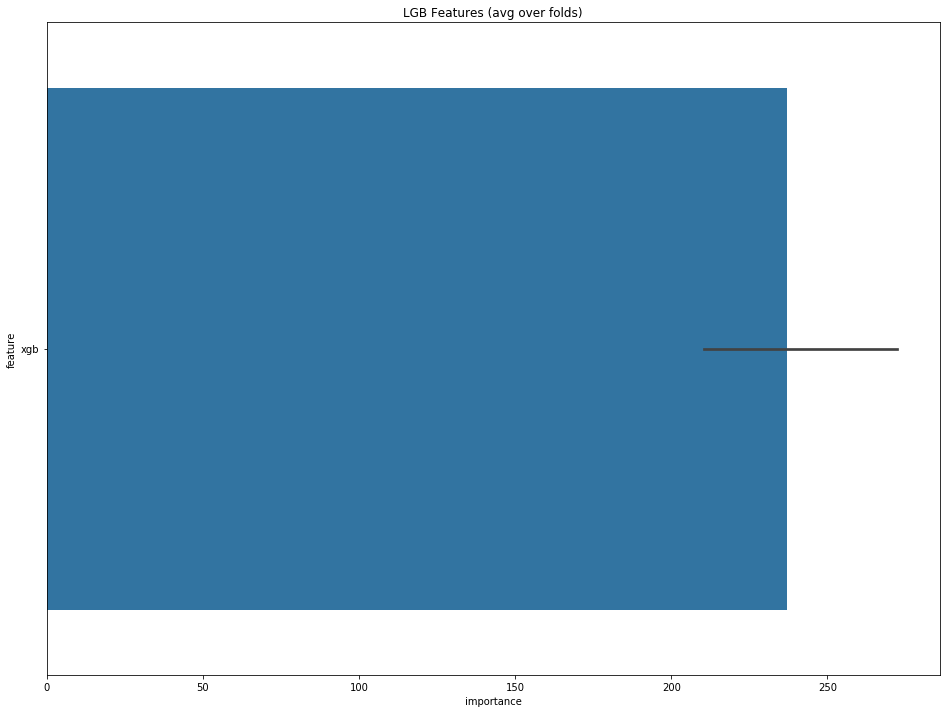

In [247]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [248]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:13:07 2019
Fold 1 started at Tue Dec 17 02:13:10 2019
Fold 2 started at Tue Dec 17 02:13:11 2019
Fold 3 started at Tue Dec 17 02:13:13 2019
Fold 4 started at Tue Dec 17 02:13:15 2019
Fold 5 started at Tue Dec 17 02:13:18 2019
Fold 6 started at Tue Dec 17 02:13:21 2019
Fold 7 started at Tue Dec 17 02:13:24 2019
Fold 8 started at Tue Dec 17 02:13:26 2019
Fold 9 started at Tue Dec 17 02:13:29 2019
CV mean score: 2.1137, std: 0.1543.


##### randomforest作为第二层融合模型

In [249]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:13:31 2019
Fold 1 started at Tue Dec 17 02:13:31 2019
Fold 2 started at Tue Dec 17 02:13:31 2019
Fold 3 started at Tue Dec 17 02:13:31 2019
Fold 4 started at Tue Dec 17 02:13:32 2019
Fold 5 started at Tue Dec 17 02:13:32 2019
Fold 6 started at Tue Dec 17 02:13:32 2019
Fold 7 started at Tue Dec 17 02:13:32 2019
Fold 8 started at Tue Dec 17 02:13:33 2019
Fold 9 started at Tue Dec 17 02:13:33 2019
CV mean score: 2.2798, std: 0.1700.


##### xgboost作为第二层融合模型

In [250]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:13:33 2019
[0]	train-rmse:9.87511	valid_data-rmse:9.86688
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.84011	valid_data-rmse:2.25807
Stopping. Best iteration:
[389]	train-rmse:1.89824	valid_data-rmse:2.25004

Fold 1 started at Tue Dec 17 02:13:34 2019
[0]	train-rmse:9.87783	valid_data-rmse:9.84385
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.83906	valid_data-rmse:2.26998
Stopping. Best iteration:
[438]	train-rmse:1.86719	valid_data-rmse:2.2672

Fold 2 started at Tue Dec 17 02:13:35 2019
[0]	train-rmse:9.91019	valid_data-rmse:9.54369
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [251]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:13:40 2019
Fold 1 started at Tue Dec 17 02:13:40 2019
Fold 2 started at Tue Dec 17 02:13:41 2019
Fold 3 started at Tue Dec 17 02:13:41 2019
Fold 4 started at Tue Dec 17 02:13:41 2019
Fold 5 started at Tue Dec 17 02:13:42 2019
Fold 6 started at Tue Dec 17 02:13:42 2019
Fold 7 started at Tue Dec 17 02:13:42 2019
Fold 8 started at Tue Dec 17 02:13:43 2019
Fold 9 started at Tue Dec 17 02:13:43 2019
CV mean score: 2.1538, std: 0.1748.


##### 岭回归做第二层融合模型

In [252]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:13:43 2019
Fold 1 started at Tue Dec 17 02:13:43 2019
Fold 2 started at Tue Dec 17 02:13:44 2019
Fold 3 started at Tue Dec 17 02:13:44 2019
Fold 4 started at Tue Dec 17 02:13:44 2019
Fold 5 started at Tue Dec 17 02:13:44 2019
Fold 6 started at Tue Dec 17 02:13:44 2019
Fold 7 started at Tue Dec 17 02:13:44 2019
Fold 8 started at Tue Dec 17 02:13:44 2019
Fold 9 started at Tue Dec 17 02:13:44 2019
CV mean score: 2.1182, std: 0.1478.


#### 只留下lgb

In [253]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:13:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 2.02303	valid_1's rmse: 2.24666
Fold 1 started at Tue Dec 17 02:13:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 2.03236	valid_1's rmse: 2.2386
Fold 2 started at Tue Dec 17 02:13:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[318]	training's rmse: 2.04573	valid_1's rmse: 1.99764
Fold 3 started at Tue Dec 17 02:13:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 2.04283	valid_1's rmse: 2.14555
Fold 4 started at Tue Dec 17 02:13:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[447]	training's rmse: 1.99338	valid_1's rmse: 2.34087
Fold 5 started at Tue

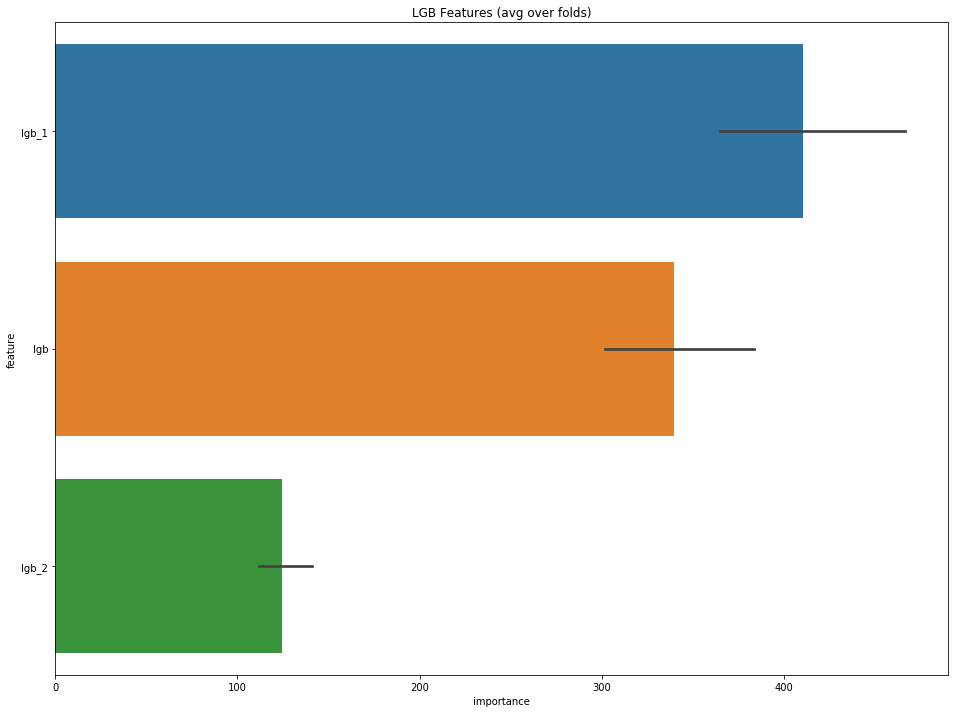

In [254]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:13:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.08347	valid_1's rmse: 2.18651
Fold 1 started at Tue Dec 17 02:13:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[343]	training's rmse: 2.07665	valid_1's rmse: 2.22235
Fold 2 started at Tue Dec 17 02:13:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[407]	training's rmse: 2.09639	valid_1's rmse: 1.98343
Fold 3 started at Tue Dec 17 02:13:48 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.06627	valid_1's rmse: 2.10549
Early stopping, best iteration is:
[923]	training's rmse: 2.06797	valid_1's rmse: 2.10451
Fold 4 started at Tue Dec 17 02:13:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rm

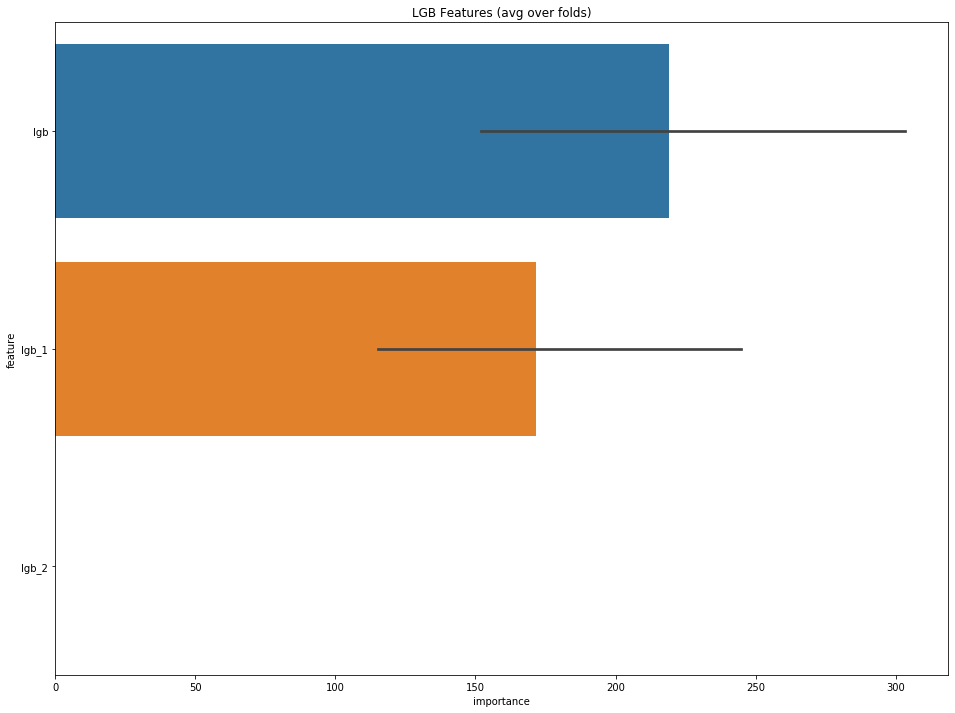

In [255]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [256]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:13:50 2019
Fold 1 started at Tue Dec 17 02:13:52 2019
Fold 2 started at Tue Dec 17 02:13:54 2019
Fold 3 started at Tue Dec 17 02:13:56 2019
Fold 4 started at Tue Dec 17 02:13:59 2019
Fold 5 started at Tue Dec 17 02:14:02 2019
Fold 6 started at Tue Dec 17 02:14:04 2019
Fold 7 started at Tue Dec 17 02:14:12 2019
Fold 8 started at Tue Dec 17 02:14:22 2019
Fold 9 started at Tue Dec 17 02:14:24 2019
CV mean score: 2.1105, std: 0.1350.


##### randomforest作为第二层融合模型

In [257]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:14:25 2019
Fold 1 started at Tue Dec 17 02:14:25 2019
Fold 2 started at Tue Dec 17 02:14:26 2019
Fold 3 started at Tue Dec 17 02:14:26 2019
Fold 4 started at Tue Dec 17 02:14:26 2019
Fold 5 started at Tue Dec 17 02:14:26 2019
Fold 6 started at Tue Dec 17 02:14:27 2019
Fold 7 started at Tue Dec 17 02:14:27 2019
Fold 8 started at Tue Dec 17 02:14:27 2019
Fold 9 started at Tue Dec 17 02:14:27 2019
CV mean score: 2.2079, std: 0.1265.


##### xgboost作为第二层融合模型

In [258]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:14:28 2019
[0]	train-rmse:9.87517	valid_data-rmse:9.86753
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.76441	valid_data-rmse:2.25708
Stopping. Best iteration:
[408]	train-rmse:1.8197	valid_data-rmse:2.25175

Fold 1 started at Tue Dec 17 02:14:29 2019
[0]	train-rmse:9.87789	valid_data-rmse:9.84347
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.769	valid_data-rmse:2.25878
Stopping. Best iteration:
[430]	train-rmse:1.8071	valid_data-rmse:2.25255

Fold 2 started at Tue Dec 17 02:14:30 2019
[0]	train-rmse:9.9103	valid_data-rmse:9.54236
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:

##### svr 作为第二层融合模型

In [259]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:14:38 2019
Fold 1 started at Tue Dec 17 02:14:38 2019
Fold 2 started at Tue Dec 17 02:14:38 2019
Fold 3 started at Tue Dec 17 02:14:39 2019
Fold 4 started at Tue Dec 17 02:14:39 2019
Fold 5 started at Tue Dec 17 02:14:39 2019
Fold 6 started at Tue Dec 17 02:14:40 2019
Fold 7 started at Tue Dec 17 02:14:40 2019
Fold 8 started at Tue Dec 17 02:14:40 2019
Fold 9 started at Tue Dec 17 02:14:41 2019
CV mean score: 2.1553, std: 0.1631.


##### 岭回归做第二层融合模型

In [260]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:14:41 2019
Fold 1 started at Tue Dec 17 02:14:41 2019
Fold 2 started at Tue Dec 17 02:14:41 2019
Fold 3 started at Tue Dec 17 02:14:41 2019
Fold 4 started at Tue Dec 17 02:14:41 2019
Fold 5 started at Tue Dec 17 02:14:42 2019
Fold 6 started at Tue Dec 17 02:14:42 2019
Fold 7 started at Tue Dec 17 02:14:42 2019
Fold 8 started at Tue Dec 17 02:14:42 2019
Fold 9 started at Tue Dec 17 02:14:42 2019
CV mean score: 2.1173, std: 0.1421.
